In [ ]:
%matplotlib inline
%pylab inline
pd.set_option('display.max_columns', 500)
import pandas as pd
import numpy as np
import networkx as nx
from networkx.algorithms import bipartite
from networkx.algorithms import centrality
from networkx.algorithms import distance_measures
from networkx.algorithms import shortest_paths
from networkx.algorithms import components
from networkx.algorithms import isolates
from networkx.classes import function
import matplotlib.pyplot as plt
import math
import csv
from networkx.algorithms import bipartite

## Read the data from the Orbis for each country separately

In [ ]:
# SQL example code for Denmark: 
SELECT positionsIMP.BvD, positionsIMP.UCI, recentFinancials.currentGUO
FROM positionsIMP
LEFT JOIN recentFinancials
ON positionsIMP.BvD = recentFinancials.BvD
WHERE positionsIMP.country = 'DK'

## If firms have the same GUO and the same board, merge them into one

Based on the merging algorithm from there:
https://www.sciencedirect.com/science/article/pii/S0306437917302272?via%3Dihub

In [ ]:
# read data (should have columns id, uci and guo)
positions = pd.read_csv("DK_guo.csv", header=0, sep=',', low_memory=False)

# add ID
# positions['ID'] = positions.index
# positions['ID'] = positions['ID'] + 1

# rename BvD to id
positions.rename(columns={'BvD': 'ID'}, inplace=True)
d_company2guo = dict(zip(positions["ID"],positions["currentGUO"]))
all_guos = set(positions["currentGUO"])

positions["guo"] = positions.apply(lambda x: 
                                   x["currentGUO"] if isinstance(x["currentGUO"],str)
                                   else(
                                       x["ID"] if x["ID"] in all_guos
                                               else np.NaN),
                                   axis=1)

positions["guo"] = positions["guo"].replace(np.NaN, "NA")
d_company2guo = dict(zip(positions["ID"],positions["guo"]))

# delete BvD, currentGUO col
# positions.drop(['BvD', 'currentGUO'], axis=1, inplace=True)

positions.drop(['currentGUO'], axis=1, inplace=True)

##Taking out all directors with one position only
positions = positions.sort_values(by="UCI")#.loc[:,["BvD_ID","UCI"]]
positions = positions.drop_duplicates(subset=["ID","UCI"]) # a link is a link, we'll add which position is it later

##Deleting directors with one position
d_positions = positions.loc[:,["ID","UCI"]].groupby("UCI").count().to_dict(orient="dict")["ID"]
positions["count"] = positions["UCI"].apply(lambda x: d_positions[x])    
positions = positions.loc[positions["count"]>1,["ID","UCI","guo"]]

##Combining all directors into one
positions_cs = positions.groupby("ID").sum().reset_index()
positions_cs["ID"] = positions_cs["ID"].str.strip()
positions_cs["guo"] = positions_cs["ID"].map(d_company2guo)

#New data with merged companies if they share exactly the same board
with open("./DK_mergedbyboard.csv","w+") as f:
    f.write("BvD\tUCI\tguo\n")
    for uci_guo,group in positions_cs.groupby(["UCI","guo"]):
        people = ["P"+_ for _ in uci_guo[0].split("P") if len(_)>1] 
        if len(group) == 1: 
            for p in people:
                f.write("{}\t{}\t{}\n".format(group.ID.values[0],p,uci_guo[1]))
        else:
            new_id = uci_guo[1]+"_GUO:"+":".join(group["ID"])
            for p in people:
                f.write("{}\t{}\t{}\n".format(new_id,p,uci_guo[1]))

In [170]:
## Read all files together
import os
import glob

files = glob.glob('./data/*.csv')
dfs = {}

for f in files:
    dfs[os.path.splitext(os.path.basename(f))[0]] = pd.read_csv(f, sep = '\t')

In [171]:
dfs['ZW_mergedbyboard'].head()

BvD         UCI           guo
0  ZW0000021624_GUO:ZW0000021619:ZW0000021624  P004743314  ZW0000021624
1  ZW0000021624_GUO:ZW0000021619:ZW0000021624  P272658361  ZW0000021624
2  ZW0000021624_GUO:ZW0000021619:ZW0000021624  P272658362  ZW0000021624
3  ZW0000021624_GUO:ZW0000021619:ZW0000021624  P272658363  ZW0000021624
4  ZW0000021624_GUO:ZW0000021619:ZW0000021624  P272658364  ZW0000021624

In [172]:
len(dfs['ZW_mergedbyboard'])

580

## Create graphs

In [173]:
# Create a bipartite graph for each country separately
# Example with AE:

AEG = dfs['AE_mergedbyboard'][['BvD','UCI']]
BVD = AEG['BvD']
UCI = AEG['UCI']
list_graph_AE = AEG.values.tolist()
AEG = nx.Graph()
AEG.add_nodes_from(BVD, bipartite=0)
AEG.add_nodes_from(UCI, bipartite=1)
AEG.add_edges_from(list_graph_AE)

# Do the same for all countries

In [189]:
# Create a list of countries
countries = (
AEG,
ALG,
AOG,
ARG,
ATG,
AUG,
BAG,
BDG,
BEG,
BGG,
BHG,
BMG,
BRG,
BWG,
BYG,
CAG,
CHG,
CIG,
CLG,
CNG,
COG,
CYG,
CZG,
DEG,
DKG,
DZG,
EEG,
EGG,
ESG,
FIG,
FRG,
GBG,
GEG,
GGG,
GHG,
GRG,
HKG,
HRG,
HUG,
IDG,
IEG,
ILG,
IMG,
ING,
IQG,
IRG,
ISG,
ITG,
JEG,
JMG,
JOG,
JPG,
KEG,
KHG,
KRG,
KVG,
KWG,
KYG,
KZG,
LAG,
LBG,
LIG,
LKG,
LSG,
LTG,
LUG,
LVG,
MCG,
MDG,
MEG,
MGG,
MKG,
MMG,
MNG,
MTG,
MUG,
MXG,
MYG,
NAG,
NGG,
NLG,
NOG,
NPG,
NZG,
OMG,
PAG,
PEG,
PGG,
PHG,
PKG,
PLG,
PSG,
PTG,
PYG,
QAG,
ROG,
RSG,
RUG,
SAG,
SEG,
SGG,
SIG,
SKG,
SNG,
SZG,
THG,
TRG,
TWG,
TZG,
UAG,
USG,
UZG,
VGG,
VNG,
ZAG,
ZMG,
ZWG)

In [190]:
# No of edges
for i in (countries):
    print(nx.number_of_edges(i))

8020
6128
175
63022
142969
1322490
1843
1061
356734
279271
2863
3458
1680489
207
1542
7227
417759
173
9691
2016360
690579
16694
149519
843044
266214
54668
134364
1435
791309
401521
364902
2214659
11235
296
30609
17973
27206
11366
12281
15340
192880
18017
219
805001
211
281
23976
910949
376
47682
8827
94043
219
123
25515
196
11813
1279
57799
1053
3144
6348
3917
6967
17269
37675
46087
170
16694
2499
10000
20711
52558
306
27495
910
5575
343375
155
10331
467909
883285
101
227135
742
776714
50807
148586
1485
3176
71261
292
202601
37229
790
180265
44345
1052470
3049
246547
9232
9789
76779
605
169
22749
164264
4002
176
9943
269912
311
17
28566
230664
175
580


In [191]:
# No of firms(BvDs) and  individuals (UCIs)
for i in (countries):
    BvD_nodes = set(n for n, d in i.nodes(data=True) if d['bipartite']==0)
    UCI_nodes = set(i) - BvD_nodes
    print (str(len(BvD_nodes)), str(len(UCI_nodes)))

7023 6757
5372 4997
112 95
42178 38768
89356 72712
831498 693261
1496 1271
240 420
173097 160036
232030 193609
1866 1764
916 1542
1318784 1214551
116 118
1500 1497
2618 3323
201560 175544
122 120
6085 5633
1373427 1161129
496016 449029
15552 15149
106071 84023
483742 402116
159506 104654
34383 30366
86221 63861
748 794
500733 434268
197266 171411
252875 217773
1221435 1075315
11206 11083
150 142
19614 16580
11222 9838
10825 11791
8758 6966
6340 6846
9434 8937
86782 78912
13900 12452
115 144
364708 358969
99 112
181 143
13966 10336
555821 487111
179 253
23675 19072
4837 4224
87914 86060
90 102
106 110
13021 13628
172 169
6158 5585
541 550
54330 53141
1050 1049
2486 2234
2540 2182
1022 1312
3954 3301
15707 14066
16053 11549
35652 28828
135 125
15552 15149
1931 1711
7205 6284
20644 19787
24502 16263
263 255
15309 12279
212 315
3338 3372
152126 125730
74 83
6183 7427
339376 286813
460066 342855
45 65
141311 127600
240 300
273192 167939
39506 35998
50964 38140
251 564
803 1153
63309 53860
6

## Clustering

### Average bipartite clustering coefficient

In [195]:
# https://networkx.github.io/documentation/stable/reference/algorithms/generated/networkx.algorithms.bipartite.cluster.average_clustering.html

# Clustering separately: firms
for i in countries:
    BvD_nodes = set(n for n, d in i.nodes(data=True) if d['bipartite']==0)
    UCI_nodes = set(i) - BvD_nodes
    print (nx.bipartite.average_clustering(i,BvD_nodes))

0.09617401141131425
0.12143045474966623
0.3730723740545169
0.24081849204321668
0.3395059763004804
0.3673881363822114
0.29404383703090975
0.1835626953843691
0.29199484882864934
0.2428287302978129
0.19612497886109403
0.2849985110254704
0.18038799138298117
0.323301812104152
0.02548617283950617
0.36294509963442684
0.2761492275288084
0.2790333073119958
0.3065108198330061
0.29592259464766446
0.15657827785721637
0.0443840977698846
0.3649776913454296
0.36368179550724833
0.4773503910481903
0.2996625119153223
0.34081555826390886
0.3145547760814643
0.278975828102964
0.3168613411059827
0.3005781537056361
0.31806291035535555
0.021480308168243204
0.2451952632905015
0.3296038738697294
0.32264228835139447
0.3362590084641319
0.44247030914695495
0.25926843118283704
0.23402015399160314
0.35942513079966937
0.24659732437747053
0.23347295853636427
0.31051346442418176
0.31569153839987185
0.433569779047285
0.37091850834396667
0.28404056710956094
0.27907909905116607
0.3185100412101782
0.2653938677345246
0.0537

In [196]:
# Clustering separately: individuals

for i in countries:
    BvD_nodes = set(n for n, d in i.nodes(data=True) if d['bipartite']==0)
    UCI_nodes = set(i) - BvD_nodes
    print (nx.bipartite.average_clustering(i,UCI_nodes))

0.056428390512810706
0.06956523273775511
0.29700870766660237
0.2586290075082671
0.21988971097288704
0.36245818869088947
0.10485809744378752
0.3910762305888569
0.2968970364051994
0.1049555226710183
0.1958620423040738
0.5229597542339656
0.17432719957109713
0.39341673392520843
0.024653473613894455
0.4670296519068193
0.2720680844163177
0.27270833333333333
0.2347376656651764
0.21676214633495347
0.1202736065013351
0.0232144179575014
0.24480477852376084
0.28632595471778927
0.24176615334685142
0.29648919458330636
0.20918665078693313
0.3767888090666751
0.25581196738555056
0.3396733245239569
0.20082667298483386
0.318847181847707
0.0019729916689223735
0.3490211194616795
0.31280274910314304
0.3300673933231865
0.40979405555794807
0.1651917768243089
0.379119333525532
0.2170380488238346
0.45616395453054565
0.14478854569933367
0.49346547902971527
0.4560236274848509
0.3856880078420259
0.28346524687433783
0.27102321601888946
0.24301064448983883
0.6114153961980046
0.30936573034477044
0.24685176758247174


In [197]:
# Clustering for both firms and individuals
for i in countries:
    print (nx.bipartite.average_clustering(i))

0.07668481254257796
0.09643570941322938
0.3381639281276963
0.24934859931904169
0.2858399973009214
0.3651466408625901
0.20714283413418694
0.3156167632417703
0.294349843653472
0.18011480169770744
0.19599720473255947
0.4342809508251043
0.17748227983776788
0.358658909432719
0.0250702399930795
0.4211630708852541
0.2742494328128569
0.2758969565787747
0.27200850054410425
0.2596576661199578
0.1393284640659471
0.03393820091057115
0.3118603459583648
0.32856779159832794
0.38401743824531503
0.2981742888678091
0.2848064854877801
0.3466000563604891
0.26821720488677897
0.32746744045479265
0.2544222596807075
0.3184300982949296
0.01178047467360582
0.29568591937374555
0.3219074974363522
0.32611086302909437
0.3745969877833368
0.3196311933901782
0.32149346359889297
0.22575881416882368
0.40549713134437293
0.19849004932813272
0.37802478460216554
0.3826915738898627
0.35284606246395356
0.3673199392302123
0.3284315631759924
0.2648771637075811
0.4737112360376251
0.3144302157996336
0.2567500280874355
0.037714715

### Clustering Robins-Alexander

In [198]:
for i in countries:
    print (nx.bipartite.robins_alexander_clustering(i))

0.17415506958250496
0.18329466357308585
0.3465346534653465
0.29001315402218764
0.209218642395261
0.2559205436428845
0.22161272627537026
0.2132183480782098
0.13196660030576982
0.12946382476583818
0.3943899254517121
0.5754416767255569
0.24580699776876924
0.2678983833718245
0.3779527559055118
0.5388653151029389
0.17348613155715384
0.26506024096385544
0.2358559566321043
0.24107239785435644
0.17912495129906628
0.22977660607742473
0.2006219623470699
0.3199461676565802
0.17093354449079928
0.2973214155097503
0.10065321331567488
0.2976588628762542
0.24900586738714625
0.15854626065944596
0.202275120504264
0.257438773431043
0.12307692307692308
0.18911685994647637
0.24842260136377783
0.20187286470411217
0.29778823413328565
0.3093794485158433
0.3233005893909627
0.19225251076040173
0.33624113889641516
0.23499871600992953
0.354639175257732
0.19754524067554805
0.2971014492753623
0.09350649350649351
0.16598323953885166
0.22059452105886515
0.7373447946513849
0.1621229472320984
0.17339930045850777
0.2257

## Density

In [192]:
for i in (countries):
    BvD_nodes = set(n for n, d in i.nodes(data=True) if d['bipartite']==0)
    UCI_nodes = set(i) - BvD_nodes
    print (nx.bipartite.density(i, BvD_nodes))
    

0.00016900431026317027
0.00022828291166807307
0.01644736842105263
3.8541871764236735e-05
2.2004528623691043e-05
2.294216604066704e-06
0.0009692776330902864
0.01052579365079365
1.2877669489707947e-05
6.216646295293305e-06
0.0008697834260535225
0.002448190123414836
1.0491709296011005e-06
0.015122735242548218
0.0006867067468269873
0.0008307265126935517
1.180688885816548e-05
0.011816939890710382
0.00028272763462055465
1.264392818773177e-06
3.100582500529664e-06
7.085821308065534e-05
1.677650678279149e-05
4.333961930758309e-06
1.5947699162899164e-05
5.236026438726847e-05
2.4402490582436895e-05
0.002416182868842522
3.6390000606214922e-06
1.1874554834799573e-05
6.626227064489522e-06
1.6861678374759855e-06
9.046177924204994e-05
0.013896713615023475
9.412358150421347e-05
0.00016279591075657338
0.00021315039869724883
0.00018630273936164808
0.0002829486190559133
0.00018194399640438812
2.8165307171330654e-05
0.00010409468762927338
0.01322463768115942
6.148854051945879e-06
0.019029581529581528
0.01

## Average degree

In [201]:
nx.info(ALG) 
# ave degree = (2*edges)/nodes

'Name: \nType: Graph\nNumber of nodes: 10369\nNumber of edges: 6128\nAverage degree:   1.1820'

## Components

In [204]:
for i in countries:
    print (nx.number_connected_components(i))

6064
4351
54
23692
40235
345684
986
3
50835
152032
1099
94
911099
49
1461
603
50806
79
3318
694612
316918
14314
48977
185657
39522
14708
25778
332
235933
35118
142915
451975
11056
51
7969
5004
3223
5102
2703
4972
19677
9523
69
90768
35
54
3546
249564
113
4681
1716
81305
11
98
4984
145
2077
60
50370
1047
1745
405
258
1038
12564
2469
20309
98
14314
1244
4489
19726
1678
229
5424
21
1915
22687
26
3935
224792
64483
15
67866
24
7973
28863
3600
6
71
47679
5
38269
3847
49
100945
25716
922307
371
53638
560
5174
29544
491
41
8583
61766
1719
29
9085
126933
291
7
19861
39997
19
17


In [ ]:
# Sizes of the 1, 2, and 3 largest components
giant1 = sorted(nx.connected_component_subgraphs(i), key=len, reverse=True)[0]
giant2 = sorted(nx.connected_component_subgraphs(i), key=len, reverse=True)[1]
giant3 = sorted(nx.connected_component_subgraphs(i), key=len, reverse=True)[2]

print(len(giant1),len(giant2), len(giant3)

In [205]:
# size of the  1st component
for i in countries:
    giant1 = sorted(nx.connected_component_subgraphs(i), key=len, reverse=True)[0]
    print(len(giant1))

941
114
23
7692
45065
288896
185
651
163933
23080
695
2016
96271
72
21
3650
228073
13
2609
397878
187632
201
23169
276788
122431
6514
65456
479
219994
234437
70590
823798
9
163
6900
3838
11395
1033
3301
5446
85468
3105
51
328263
85
135
12187
303217
13
26215
3908
7145
152
9
12284
7
3732
784
3379
5
165
3472
1726
3366
137
18628
5093
16
201
243
2621
30
35609
14
8937
451
1172
183132
58
726
89897
574483
26
55585
468
415516
7518
78957
774
1755
3288
175
75890
20346
451
6156
2709
21443
1535
87885
4716
838
6027
40
68
5088
22857
804
31
17
62883
9
7
6645
99645
84
347


In [206]:
# size of the 2nd component
for i in countries:
    giant2 = sorted(nx.connected_component_subgraphs(i), key=len, reverse=True)[1]
    print(len(giant2))

33
41
16
214
60
315
102
5
90
367
32
30
434
10
6
27
49
13
28
262
84
171
263
155
69
310
54
27
270
56
291
551
8
9
148
108
37
75
291
40
84
30
11
113
23
11
29
227
12
66
29
27
9
6
34
7
160
34
34
4
40
19
10
37
130
68
100
12
171
32
27
29
19
10
85
10
21
56
17
29
77
70
18
97
14
22
123
19
12
15
64
3
84
55
14
289
144
219
19
96
25
77
262
10
14
69
260
29
28
14
81
5
5
24
67
14
17


In [207]:
# size of the 3rd component
for i in countries:
    giant3 = sorted(nx.connected_component_subgraphs(i), key=len, reverse=True)[2]
    print(len(giant3))

15
40
11
98
57
258
36
4
62
347
23
25
288
9
5
19
45
12
20
224
76
62
202
142
46
152
50
19
148
52
113
412
7
5
101
95
37
59
59
33
62
24
9
90
9
9
23
138
11
32
26
26
8
5
22
7
84
19
30
2
34
18
8
33
111
36
79
8
62
26
25
23
16
8
70
9
19
53
9
28
63
67
13
83
5
21
78
18
10
10
60
3
71
37
13
131
101
149
14
77
22
58
170
7
7
65
159
27
12
11
80
5
4
23
54
9
12


## Plots of some network measures

In [214]:
stat = pd.read_csv("ntw_stats.csv", header=0, sep=',', low_memory=False)
stat.head()

country country.1 country_name  no_edges  firms  individuals  no_nodes  \
0      KH       KHG     Cambodia       123    106          110       216   
1      MN       MNG     Mongolia       306    263          255       518   
2      JE       JEG       Jersey       376    179          253       432   
3      LA       LAG      Lao PDR      1053   1050         1049      2099   
4      TZ       TZG     Tanzania       176     74           91       165   

    density  ave_clu_firms  ave_clu_inds  ave_clu_both  clu_robins_alexander  \
0  0.010549       0.102201      0.127273      0.114969              0.833333   
1  0.004563       0.110564      0.068170      0.089694              0.770186   
2  0.008303       0.279079      0.611415      0.473711              0.737345   
3  0.000956       0.003333      0.002542      0.002938              0.666667   
4  0.026136       0.543017      0.550052      0.546897              0.616438   

   ave_degree  no_conn_comp  size_1comp  size_2comp  size_3comp  
0    1.138889            98           9           6           5  
1    1.181467           229          14          10           8  
2    1.740741           113          13          12          11  
3    1.003335          1047           5           4           2  
4    2.133333            29          31          28          12

(0, 3000000)

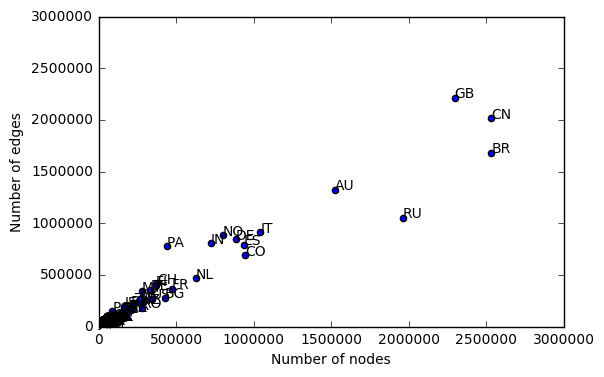

In [216]:
ax = stat.plot.scatter(x='no_nodes',y='no_edges')
stat[['no_nodes','no_edges','country']].apply(lambda x: ax.text(*x),axis=1)
plt.xlabel('Number of nodes')
plt.ylabel('Number of edges')
plt.xlim((0, 3000000))
plt.ylim((0, 3000000))

### Ave degree

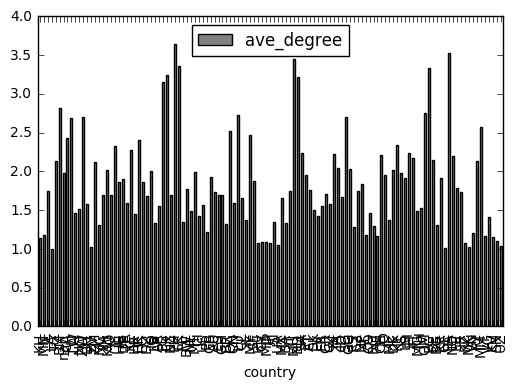

In [219]:
stat.sort_values('ave_degree', ascending=False)
stat.plot(kind='bar',x='country', y= 'ave_degree', color = 'grey')

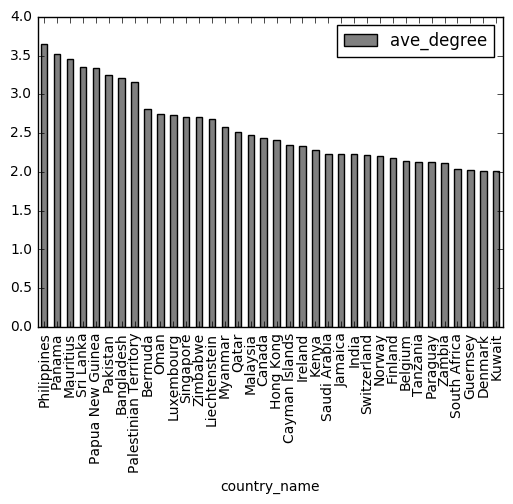

In [221]:
# Take top cases
df5 = stat.loc[stat['ave_degree'] > 2]
df5.sort_values('ave_degree', ascending=False).plot(kind='bar',x='country_name', y= 'ave_degree', color = 'grey')

## Clustering

### Robins-Alexander

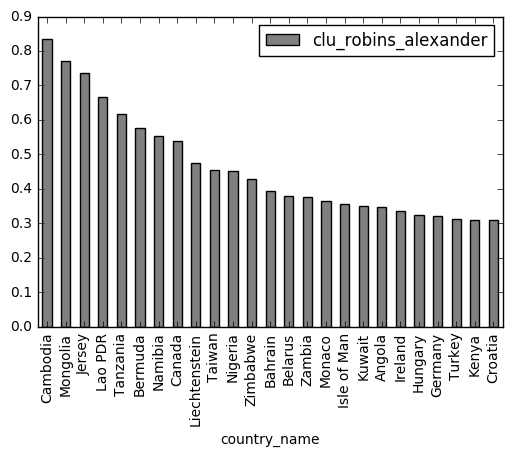

In [226]:
df6 = stat.loc[stat['clu_robins_alexander'] > 0.3]
df6.sort_values('clu_robins_alexander', ascending=False).plot(kind='bar',x='country_name', y= 'clu_robins_alexander', color = 'grey')

(0.0, 2700000)

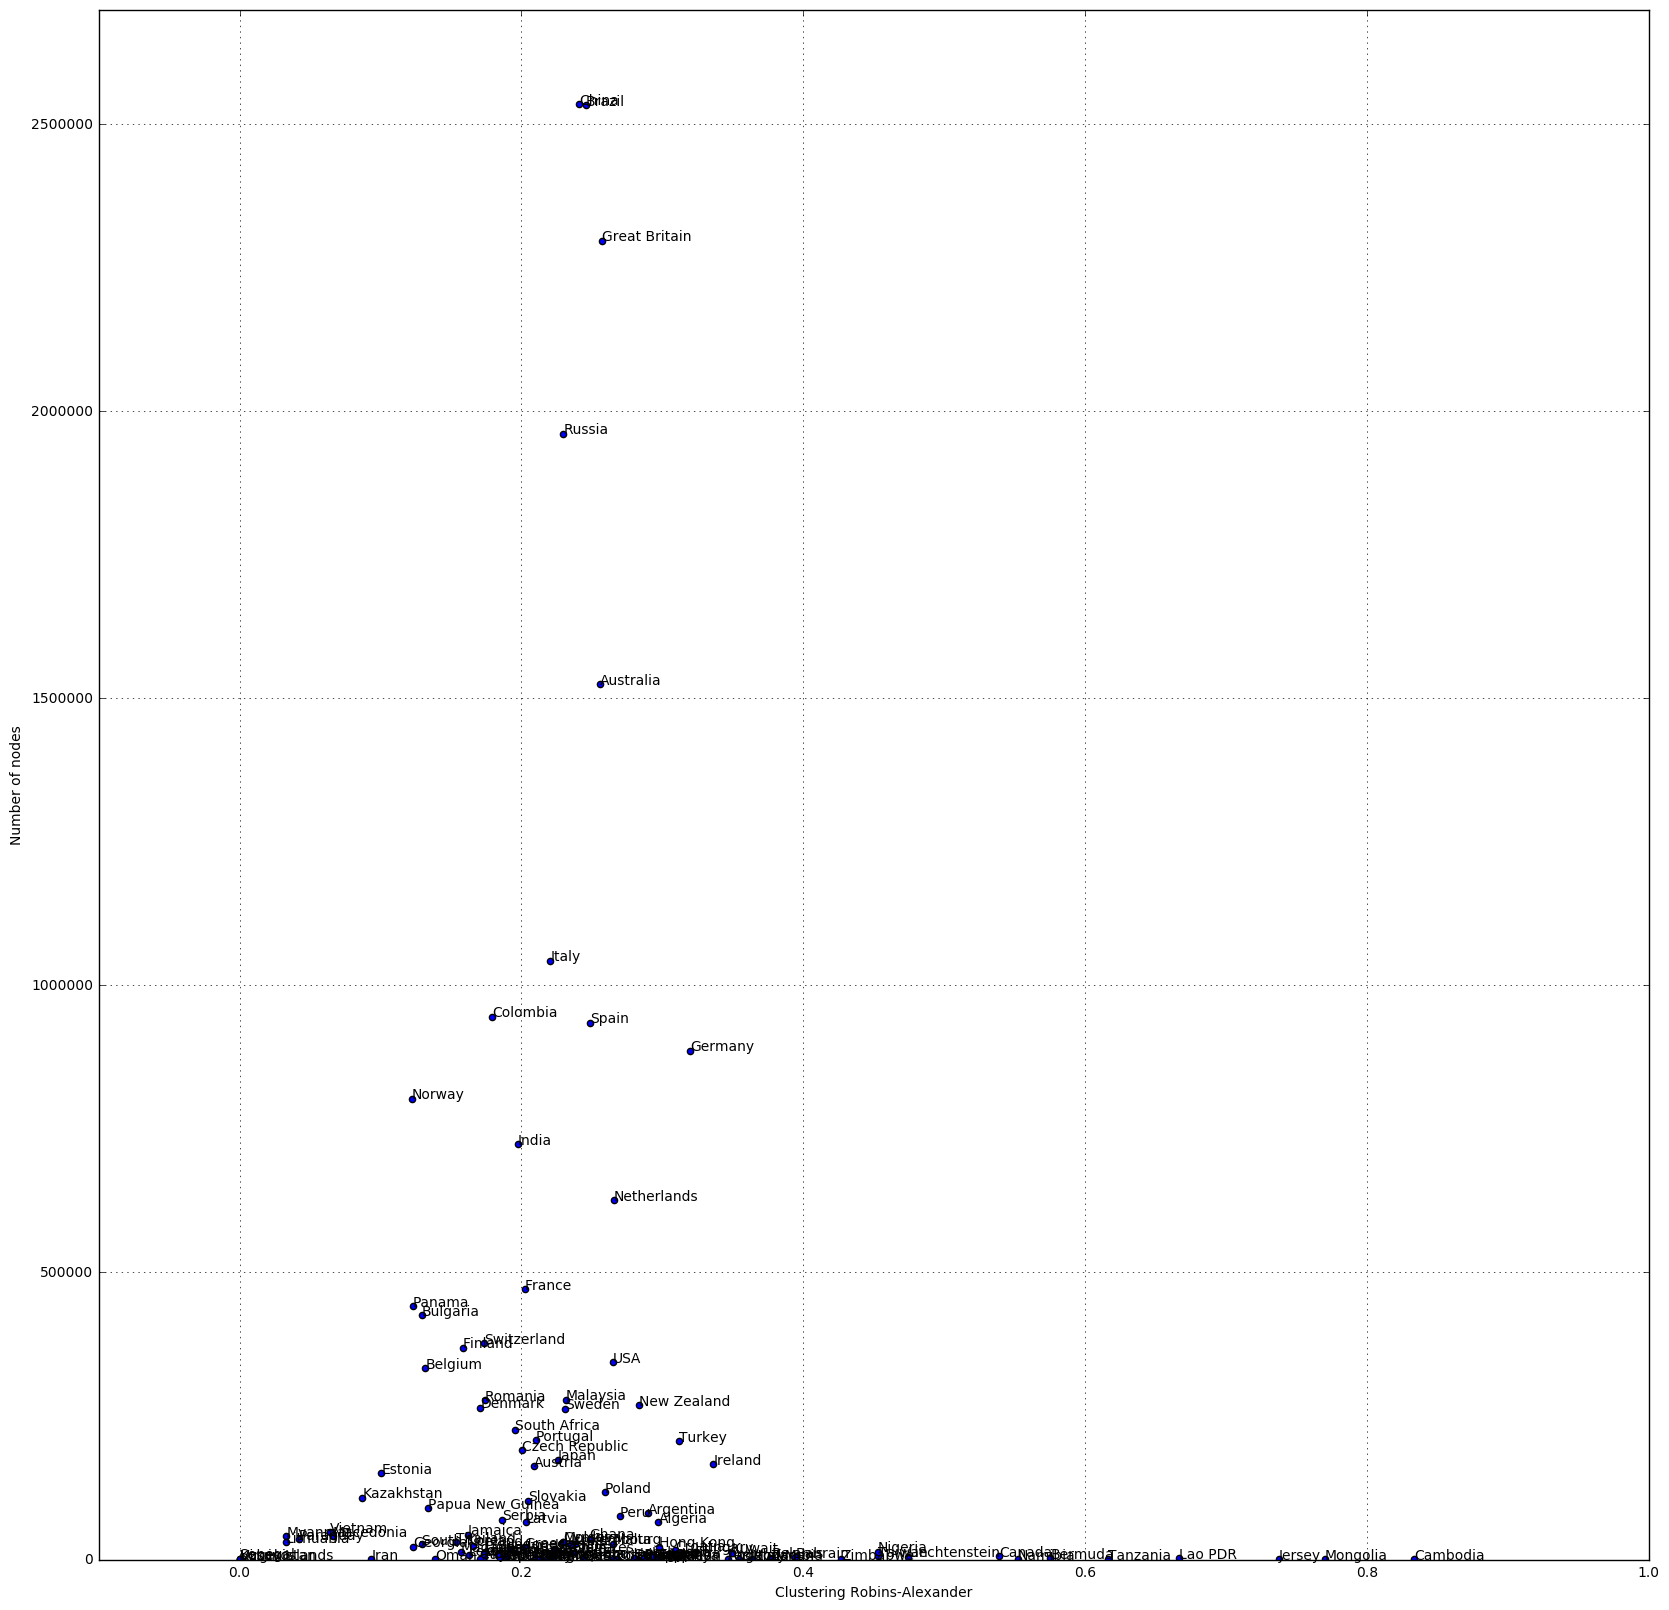

In [232]:
# High clustering is typical for relatively small networks
ax = stat.plot.scatter(x='clu_robins_alexander',y='no_nodes', figsize=(20,20))
ax.grid(True)
stat[['clu_robins_alexander','no_nodes','country_name']].apply(lambda x: ax.text(*x),axis=1)
plt.ylabel('Number of nodes')
plt.xlabel('Clustering Robins-Alexander')
plt.xlim((-0.1, 1.00))
plt.ylim((0.0, 2700000))

In [ ]:
# High clustering is typical for small networks
# Most networks have clustering around 0.2-0.3 and it varies in size of networks

(0.0, 2700000)

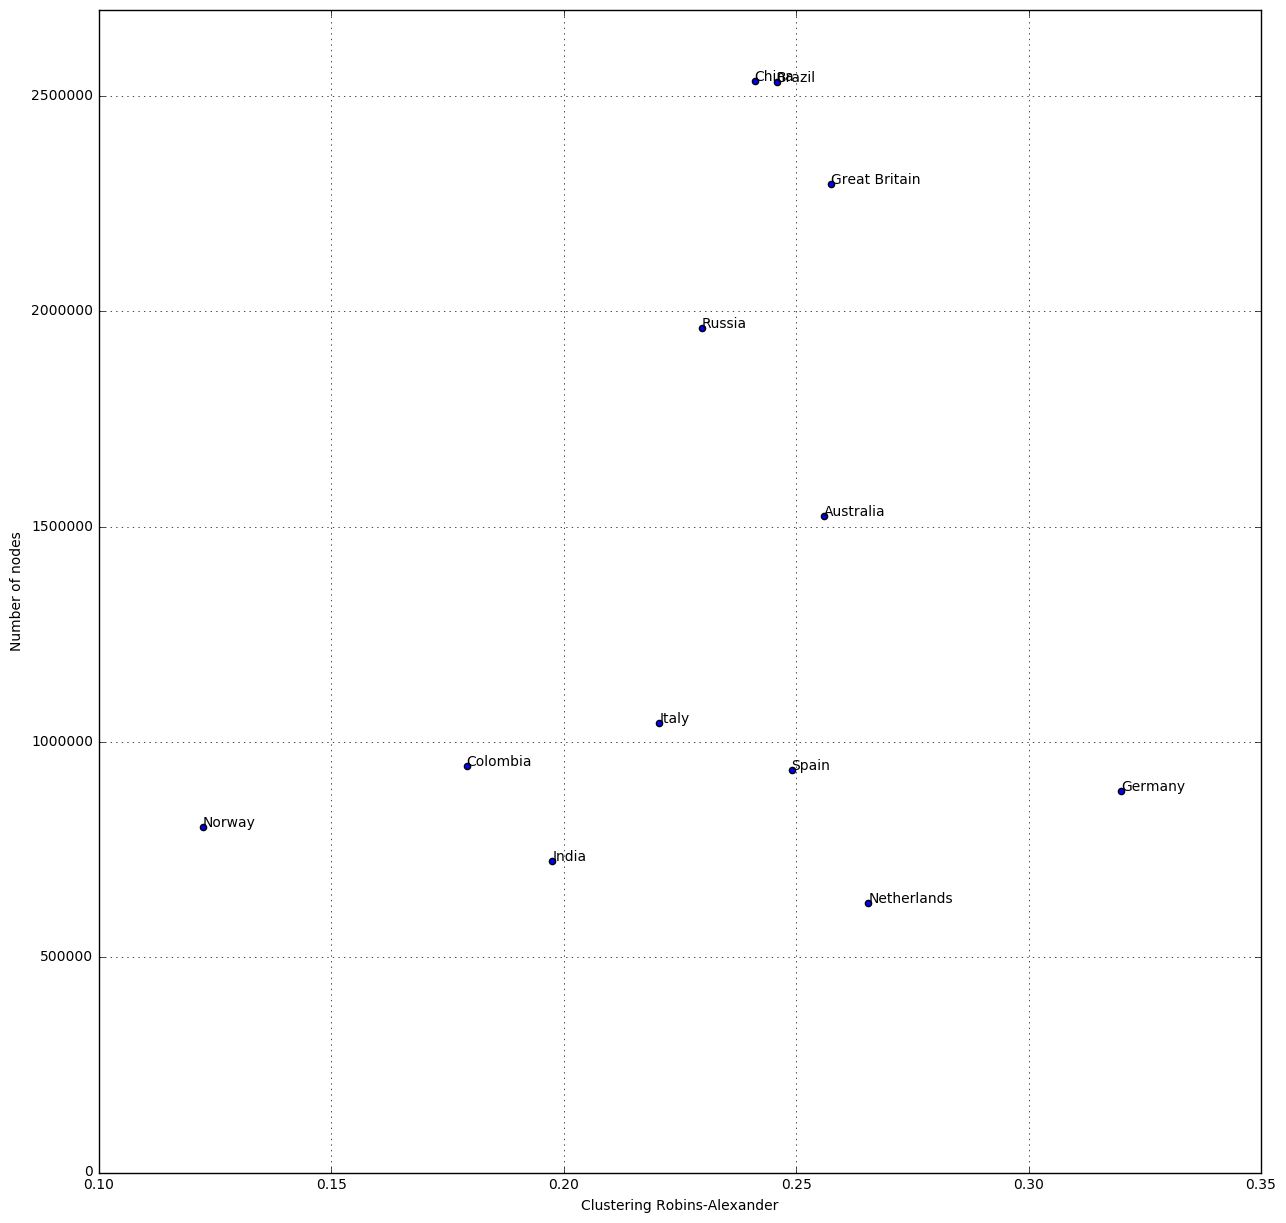

In [243]:
# Take only large networks
df7 = stat.loc[stat['no_nodes'] > 500000]
ax = df7.plot.scatter(x='clu_robins_alexander',y='no_nodes', figsize=(15,15))
ax.grid(True)
df7[['clu_robins_alexander','no_nodes','country_name']].apply(lambda x: ax.text(*x),axis=1)
plt.ylabel('Number of nodes')
plt.xlabel('Clustering Robins-Alexander')
#plt.xlim((-0.1, 1.00))
plt.ylim((0.0, 2700000))

(0.0, 2700000)

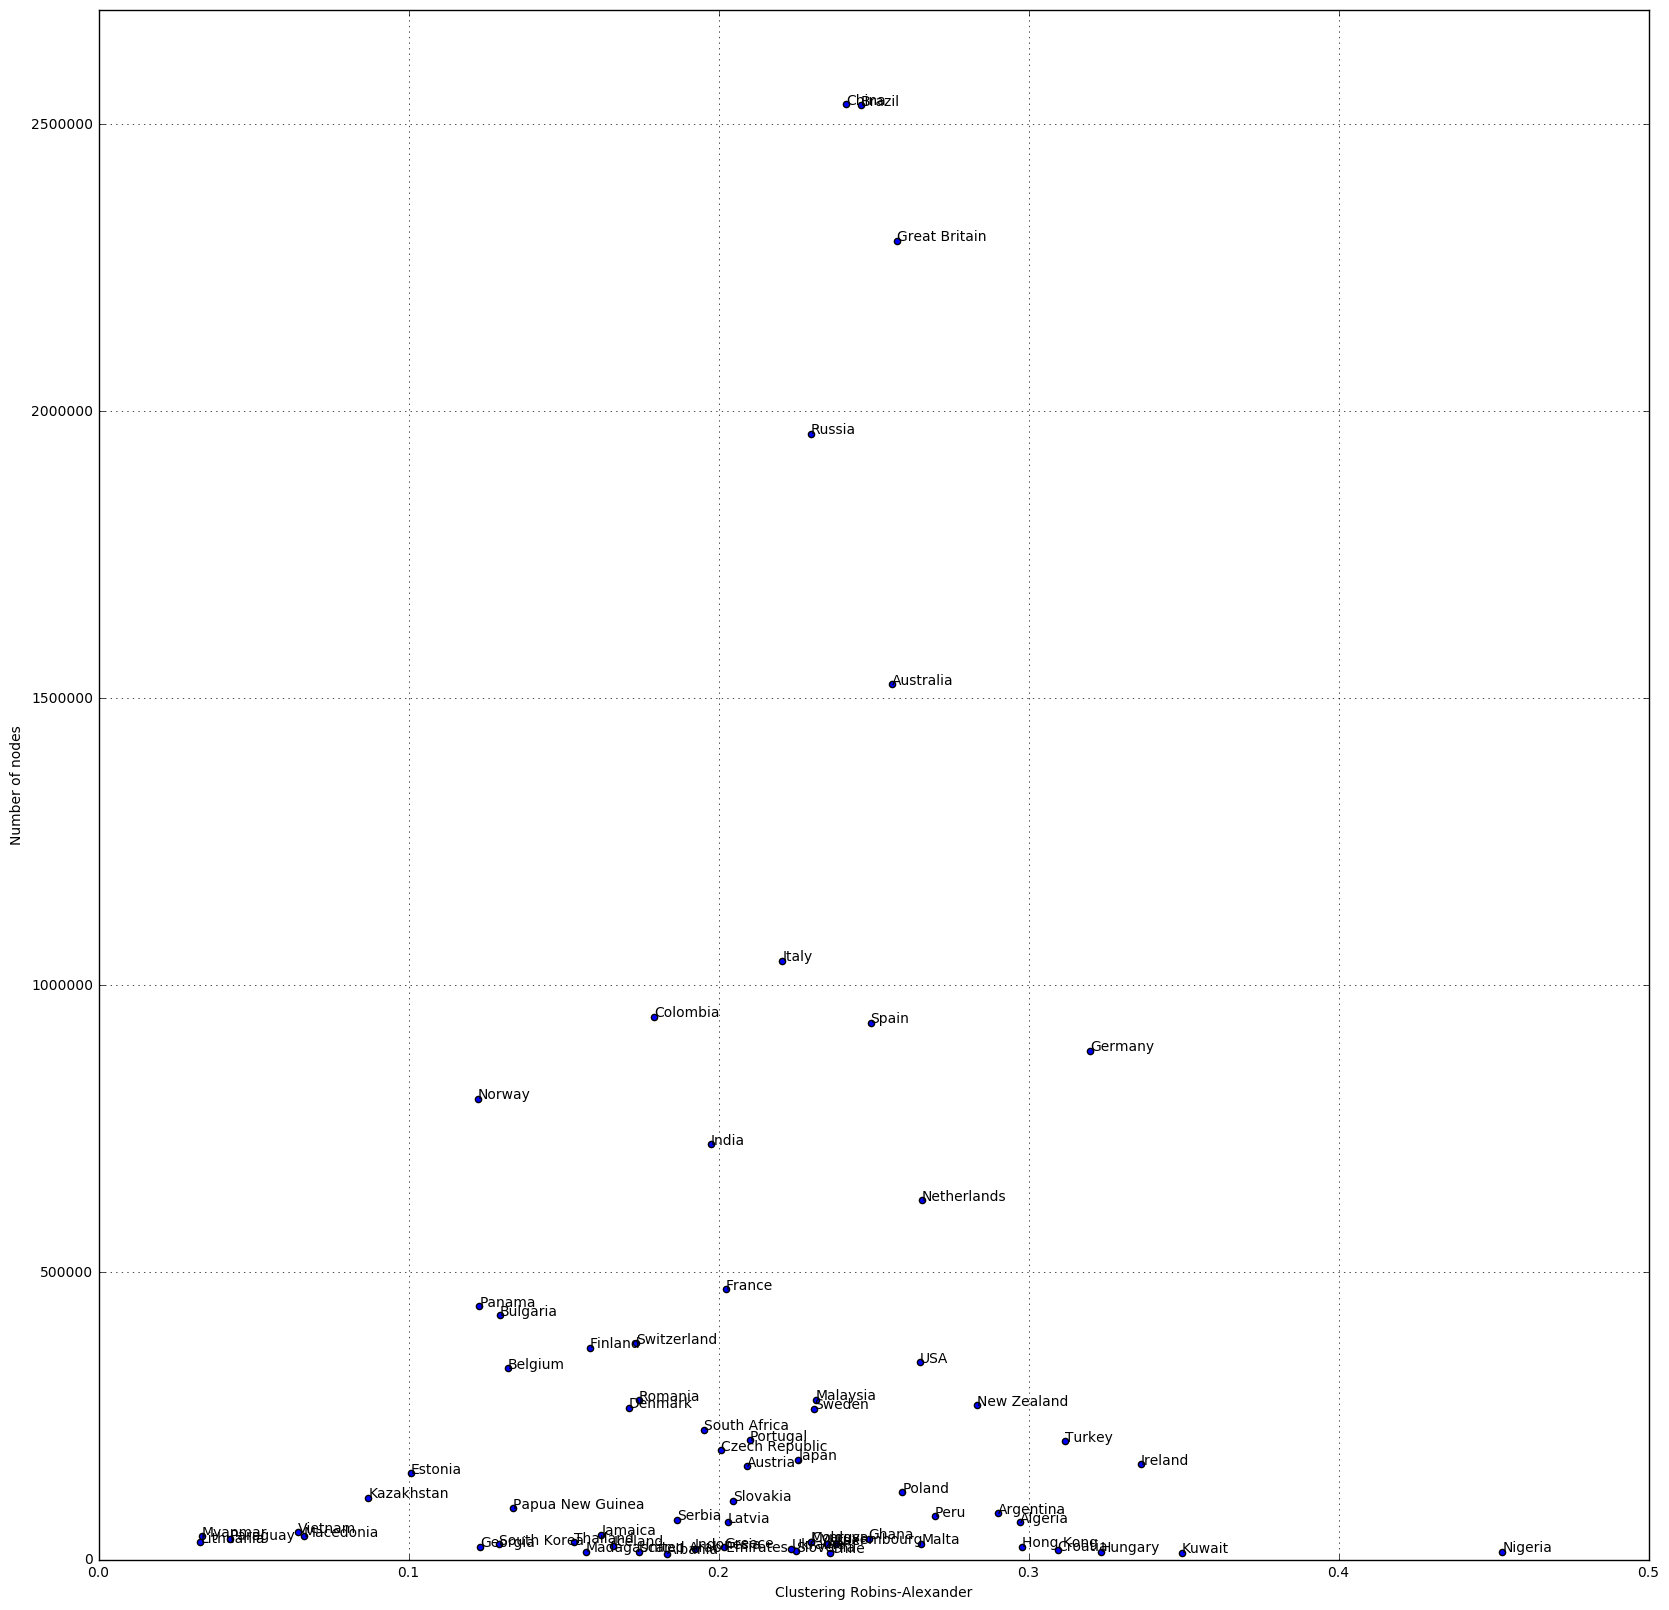

In [240]:
# Take only large networks
df7 = stat.loc[stat['no_nodes'] > 10000]
ax = df7.plot.scatter(x='clu_robins_alexander',y='no_nodes', figsize=(20,20))
ax.grid(True)
df7[['clu_robins_alexander','no_nodes','country_name']].apply(lambda x: ax.text(*x),axis=1)
plt.ylabel('Number of nodes')
plt.xlabel('Clustering Robins-Alexander')
#plt.xlim((-0.1, 1.00))
plt.ylim((0.0, 2700000))

### Clustering average (full graph)

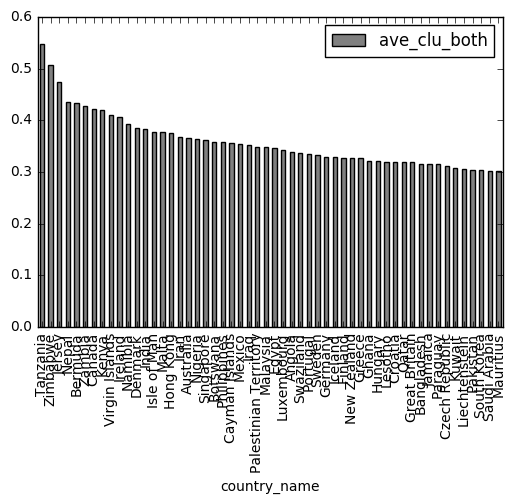

In [242]:
df6 = stat.loc[stat['ave_clu_both'] > 0.3]
df6.sort_values('ave_clu_both', ascending=False).plot(kind='bar',x='country_name', y= 'ave_clu_both', color = 'grey')

(0.0, 2700000)

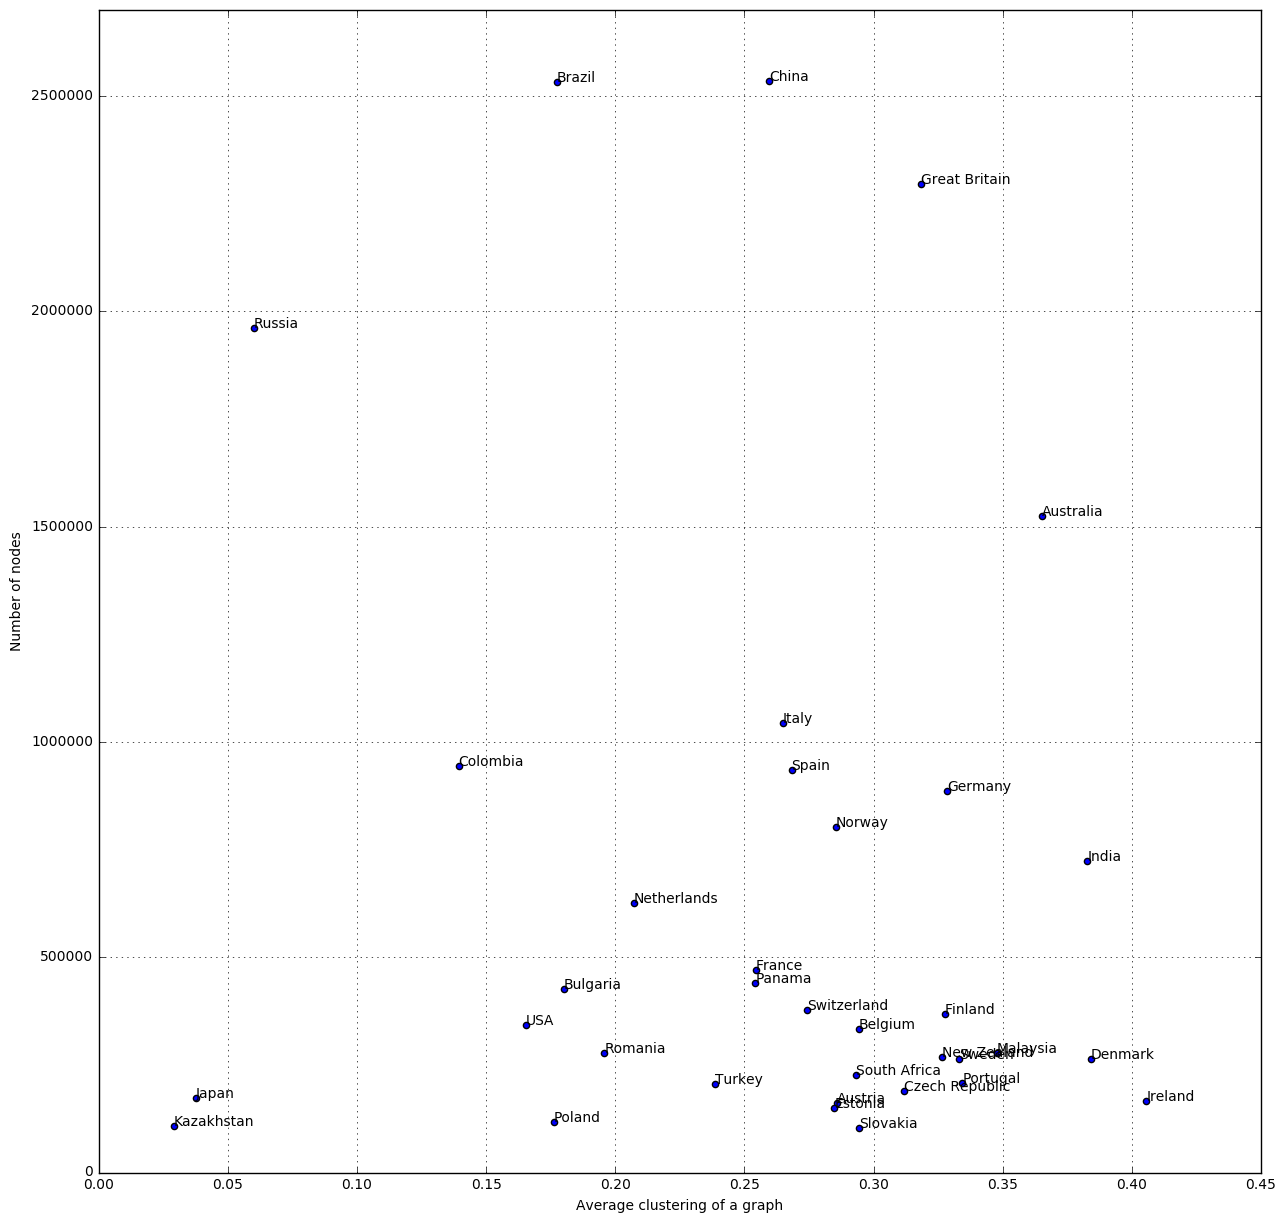

In [248]:
# Take only large networks
df7 = stat.loc[stat['no_nodes'] > 100000]
ax = df7.plot.scatter(x='ave_clu_both',y='no_nodes', figsize=(15,15))
ax.grid(True)
df7[['ave_clu_both','no_nodes','country_name']].apply(lambda x: ax.text(*x),axis=1)
plt.ylabel('Number of nodes')
plt.xlabel('Average clustering of a graph')
#plt.xlim((-0.1, 1.00))
plt.ylim((0.0, 2700000))

(0.0, 2700000)

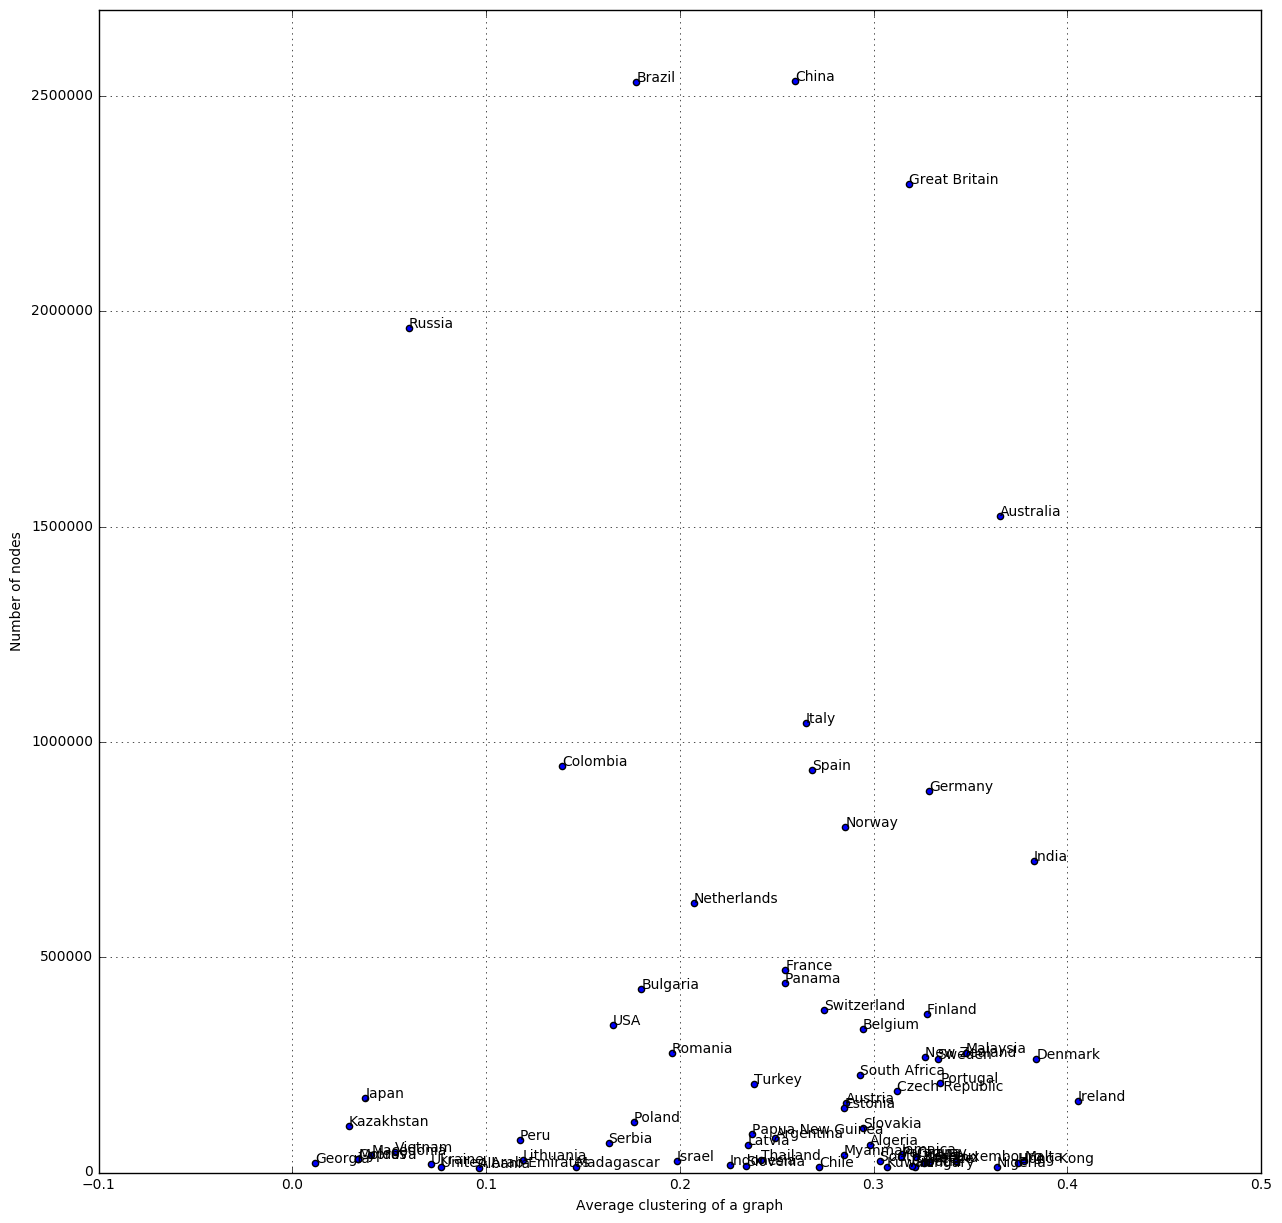

In [249]:
# Take only large networks
df7 = stat.loc[stat['no_nodes'] > 10000]
ax = df7.plot.scatter(x='ave_clu_both',y='no_nodes', figsize=(15,15))
ax.grid(True)
df7[['ave_clu_both','no_nodes','country_name']].apply(lambda x: ax.text(*x),axis=1)
plt.ylabel('Number of nodes')
plt.xlabel('Average clustering of a graph')
#plt.xlim((-0.1, 1.00))
plt.ylim((0.0, 2700000))

### Correlate both clustering measures

(-0.01, 1.0)

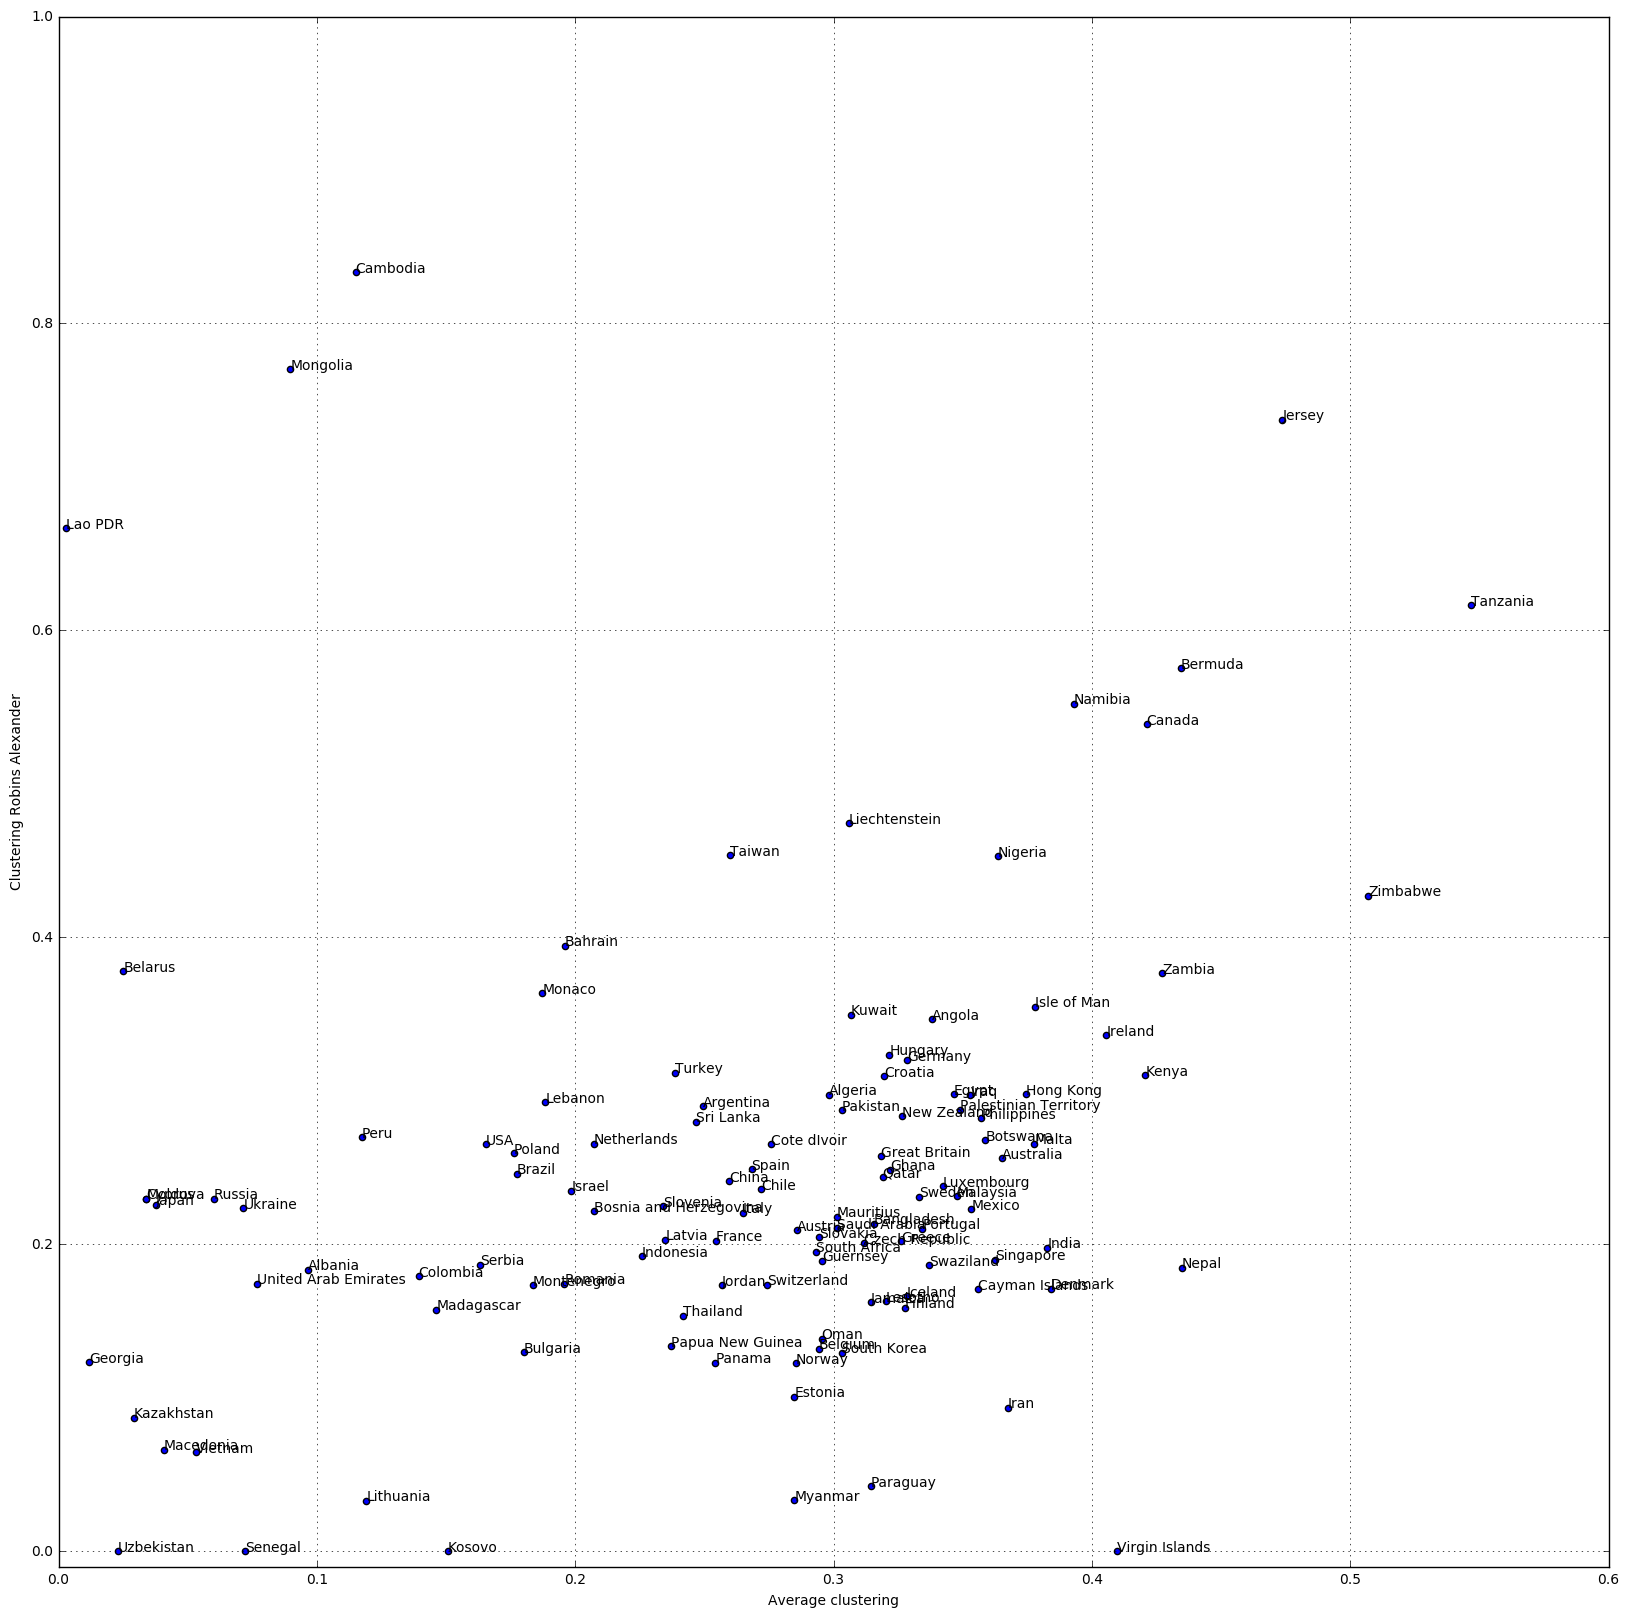

In [258]:
ax = stat.plot.scatter(x='ave_clu_both',y='clu_robins_alexander', figsize=(20,20))
ax.grid(True)
stat[['ave_clu_both','clu_robins_alexander','country_name']].apply(lambda x: ax.text(*x),axis=1)
plt.ylabel('Clustering Robins Alexander')
plt.xlabel('Average clustering')
plt.xlim((0.0, 0.6))
plt.ylim((-0.01, 1.00))

### Clustering firms and inds

(-0.01, 0.6)

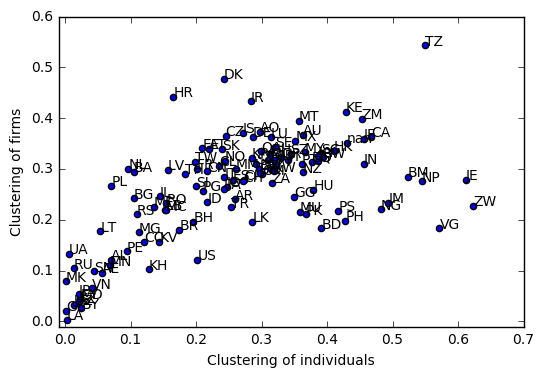

In [262]:
ax = stat.plot.scatter(x='ave_clu_inds',y='ave_clu_firms')
stat[['ave_clu_inds','ave_clu_firms','country']].apply(lambda x: ax.text(*x),axis=1)
plt.ylabel('Clustering of firms')
plt.xlabel('Clustering of individuals')
plt.xlim((-0.01, 0.70))
plt.ylim((-0.01, 0.60))

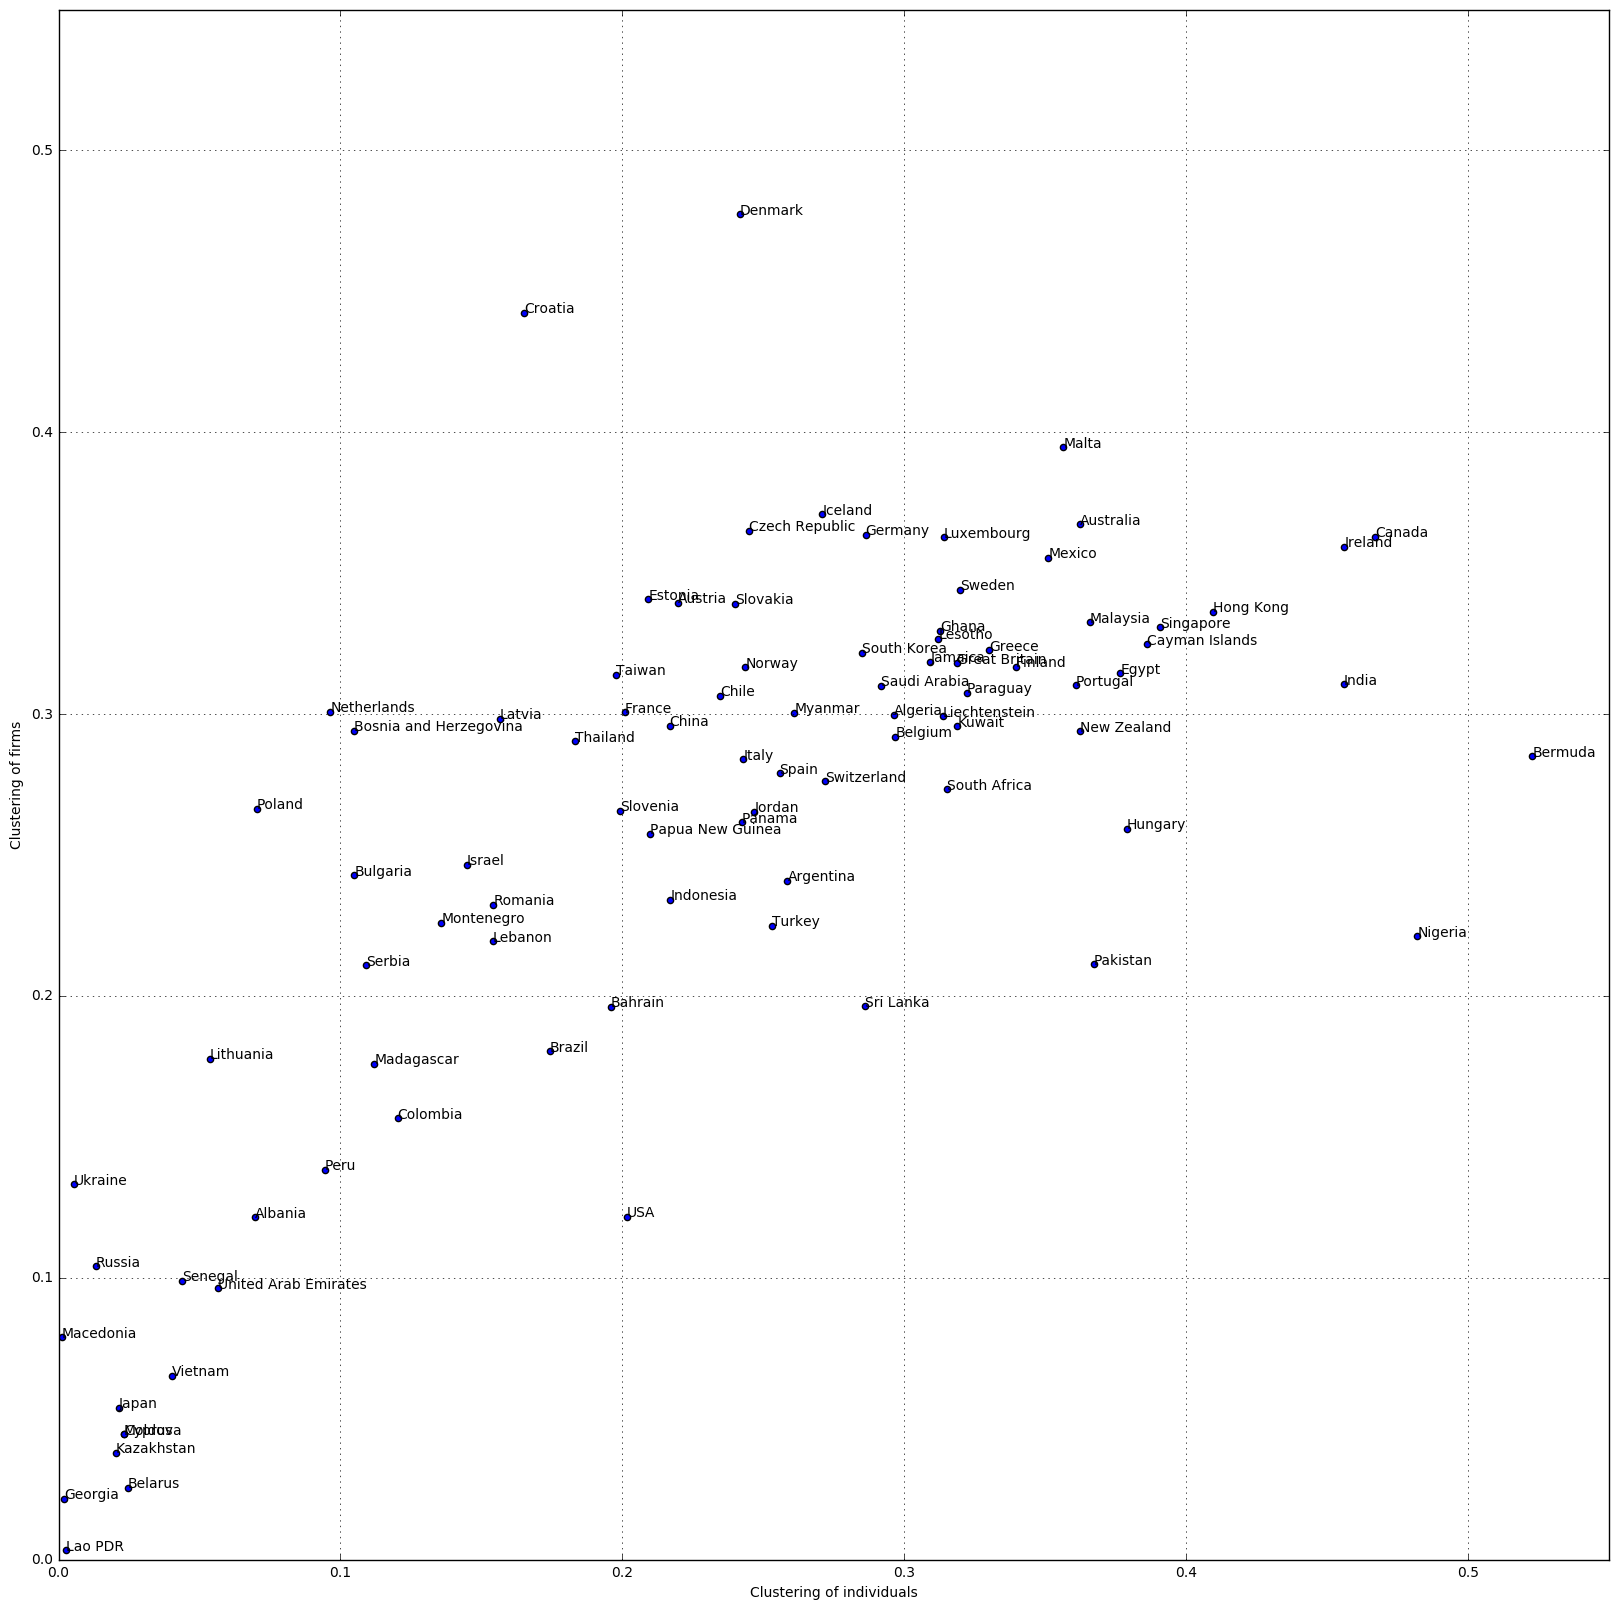

In [265]:
## Take the largest networks
df2 = stat.loc[stat['no_nodes'] > 1000]
ax = df2.plot.scatter(x='ave_clu_inds',y='ave_clu_firms', figsize=(20,20))
ax.grid(True)
df2[['ave_clu_inds','ave_clu_firms','country_name']].apply(lambda x: ax.text(*x),axis=1)
plt.ylabel('Clustering of firms')
plt.xlabel('Clustering of individuals')
plt.xlim((0.0, 0.55))
plt.ylim((0.0, 0.55))
plt.savefig('clu_firms_inds.png')


In [ ]:
## High clu firms, low - inds:
# IS - Iceland
# DK - Denmark
# NO - Norway
# CZ - Czech Republic
# EE - Estonia
# SK - Slovakia
# HR - Croatia
# IR - Iran
# AT - Austria


## High clu inds, low - firms 
# IE - Ireland
# BM - Bermuda
# IM - Isle of Man
# NG - Nigeria
# PH - Philippines
# BD - Bangladesh
# PK - Pakistan
# MU - Mauritius
# HU - Hungary
# GG - Guernsey (British island)
# LK - Sri Lanka

In [ ]:
## Interpretation:

# It captures the fact that a node which has a neighbour in common with another node
# generally has a significant portion of neighbours in common with it.

# For firms: If 2 firms have an interlock, they probably also have interlocks with the interlocking partners
# of each other = interlocks are densely clustered

# For individuals: If 2 individuals work in the same firms, they probably also sit together on other boards = elites

##  High clustering of firms:
# Eastern Europe + Nordic countries

## High clustering of inds:
# US, Ireland, India, Sout Africa, New Zealand

## Degree and clustering of a node

### Countries with high firm clustering

In [ ]:
## clu f > 0.1, clu ind < 0.1
# Ukraine, Ru, Albania, Peru, Lithuania

TypeError: 'str' object is not callable

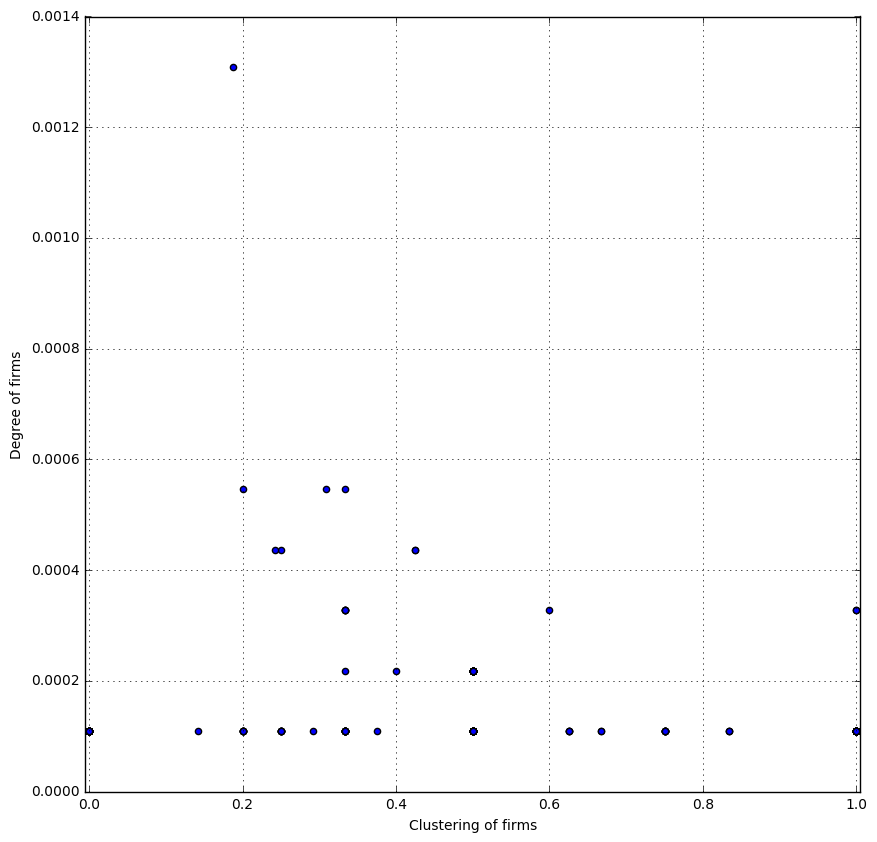

In [83]:
# Ukraine
BvD_nodes = set(n for n, d in UAG.nodes(data=True) if d['bipartite']==0)
UCI_nodes = set(UAG) - BvD_nodes

fcluUA = nx.bipartite.latapy_clustering(UAG, BvD_nodes)
icluUA = nx.bipartite.latapy_clustering(UAG, UCI_nodes)
fdegcenUA = nx.bipartite.degree_centrality(UAG, BvD_nodes)

# dict to df
df_fcluUA = pd.DataFrame(list(fcluUA.items()), columns=['firm', 'clu'])
df_icluUA = pd.DataFrame(list(icluUA.items()), columns=['ind', 'clu'])
df_degUA = pd.DataFrame(list(fdegcenUA.items()), columns=['node', 'degree'])
df_fcluUA['mode'] = 'upper'
df_icluUA['mode'] = 'lower'

df1 = pd.merge(df_degUA, df_fcluUA, left_on='node', right_on='firm', how='left')
df2 = pd.merge(df1, df_icluUA, left_on='node', right_on='ind', how='left')

# take cases where non NaN in firm = take only firms
df3 = df2.dropna(subset = ['firm'])

ax = df3.plot.scatter(x='clu_x',y='degree' , figsize=(10,10))
ax.grid(True)
plt.ylabel('Degree of firms')
plt.xlabel('Clustering of firms')
plt.xlim((-0.005, 1.005))
plt.ylim((0, 0.0014))
# plt.title('UA')

(0, 0.0001)

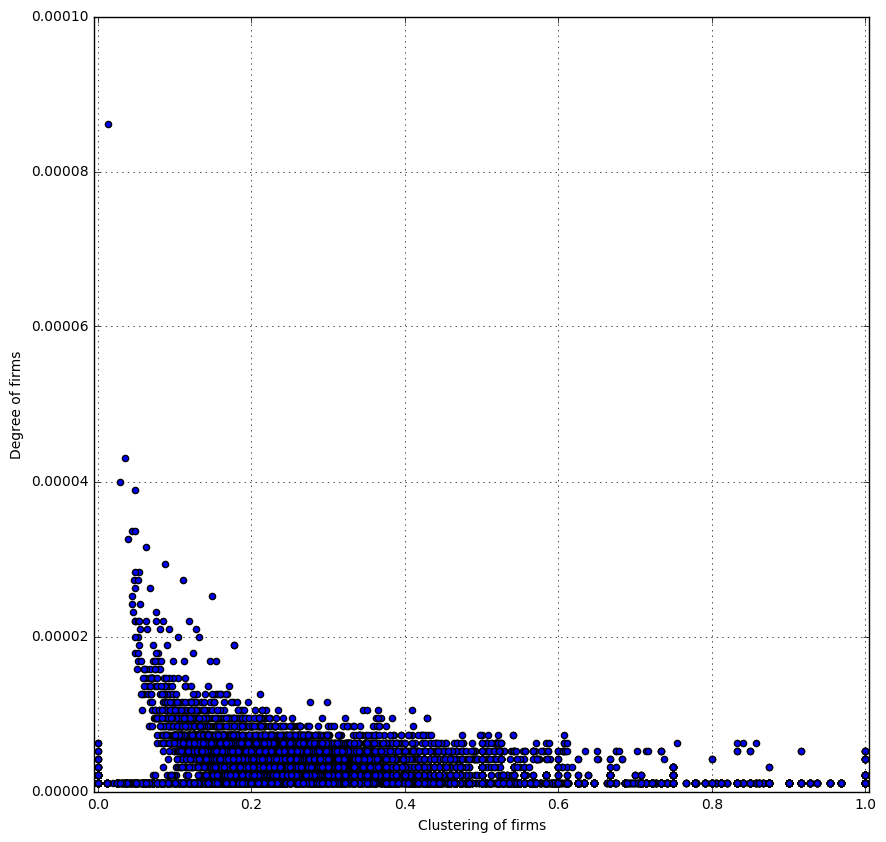

In [87]:
# Russia
BvD_nodes = set(n for n, d in RUG.nodes(data=True) if d['bipartite']==0)
UCI_nodes = set(RUG) - BvD_nodes

fcluRU = nx.bipartite.latapy_clustering(RUG, BvD_nodes)
icluRU = nx.bipartite.latapy_clustering(RUG, UCI_nodes)
fdegcenRU = nx.bipartite.degree_centrality(RUG, BvD_nodes)

# dict to df
df_fcluRU = pd.DataFrame(list(fcluRU.items()), columns=['firm', 'clu'])
df_icluRU = pd.DataFrame(list(icluRU.items()), columns=['ind', 'clu'])
df_degRU = pd.DataFrame(list(fdegcenRU.items()), columns=['node', 'degree'])
df_fcluRU['mode'] = 'upper'
df_icluRU['mode'] = 'lower'

df1 = pd.merge(df_degRU, df_fcluRU, left_on='node', right_on='firm', how='left')
df2 = pd.merge(df1, df_icluRU, left_on='node', right_on='ind', how='left')

# take cases where non NaN in firm = take only firms
df3 = df2.dropna(subset = ['firm'])

ax = df3.plot.scatter(x='clu_x',y='degree' , figsize=(10,10))
ax.grid(True)
plt.ylabel('Degree of firms')
plt.xlabel('Clustering of firms')
plt.xlim((-0.005, 1.005))
plt.ylim((0, 0.0001))
# plt.title('RU')

In [86]:
df3['degree'].describe()

count    1.009397e+06
mean     1.095287e-06
std      4.530250e-07
min      1.050462e-06
25%      1.050462e-06
50%      1.050462e-06
75%      1.050462e-06
max      8.613789e-05
Name: degree, dtype: float64

(0, 0.0015)

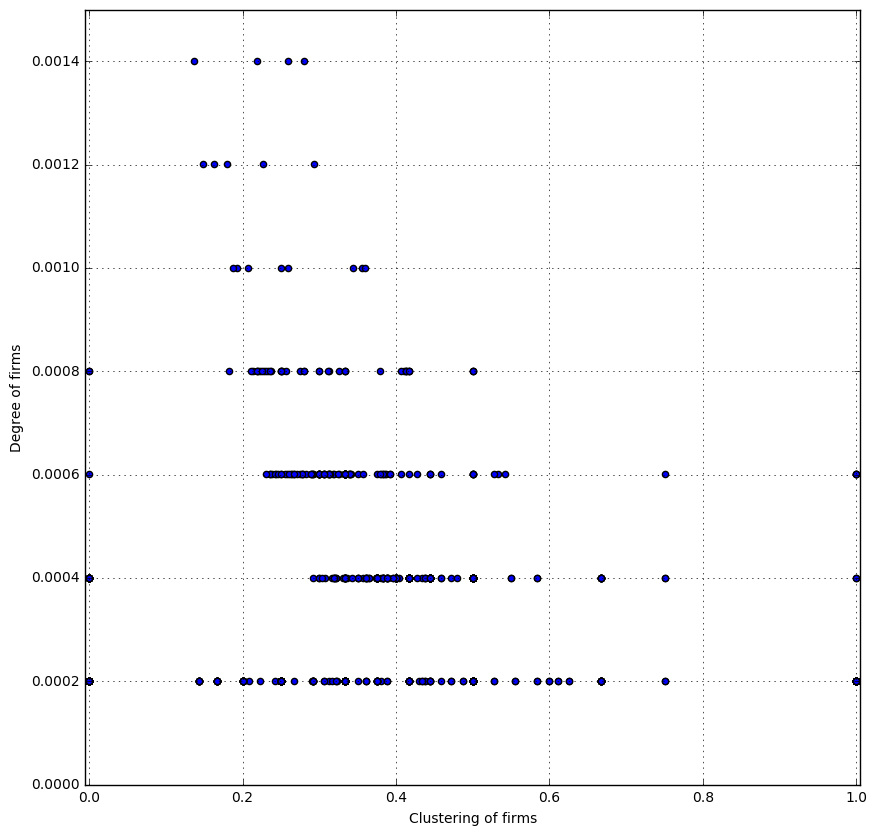

In [91]:
# Albania
BvD_nodes = set(n for n, d in ALG.nodes(data=True) if d['bipartite']==0)
UCI_nodes = set(ALG) - BvD_nodes

fcluAL = nx.bipartite.latapy_clustering(ALG, BvD_nodes)
icluAL = nx.bipartite.latapy_clustering(ALG, UCI_nodes)
fdegcenAL = nx.bipartite.degree_centrality(ALG, BvD_nodes)

# dict to df
df_fcluAL = pd.DataFrame(list(fcluAL.items()), columns=['firm', 'clu'])
df_icluAL = pd.DataFrame(list(icluAL.items()), columns=['ind', 'clu'])
df_degAL = pd.DataFrame(list(fdegcenAL.items()), columns=['node', 'degree'])
df_fcluAL['mode'] = 'upper'
df_icluAL['mode'] = 'lower'

df1 = pd.merge(df_degAL, df_fcluAL, left_on='node', right_on='firm', how='left')
df2 = pd.merge(df1, df_icluAL, left_on='node', right_on='ind', how='left')

# take cases where non NaN in firm = take only firms
df3 = df2.dropna(subset = ['firm'])

ax = df3.plot.scatter(x='clu_x',y='degree' , figsize=(10,10))
ax.grid(True)
plt.ylabel('Degree of firms')
plt.xlabel('Clustering of firms')
plt.xlim((-0.005, 1.005))
plt.ylim((0, 0.0015))
# plt.title('AL')

(0, 0.0004)

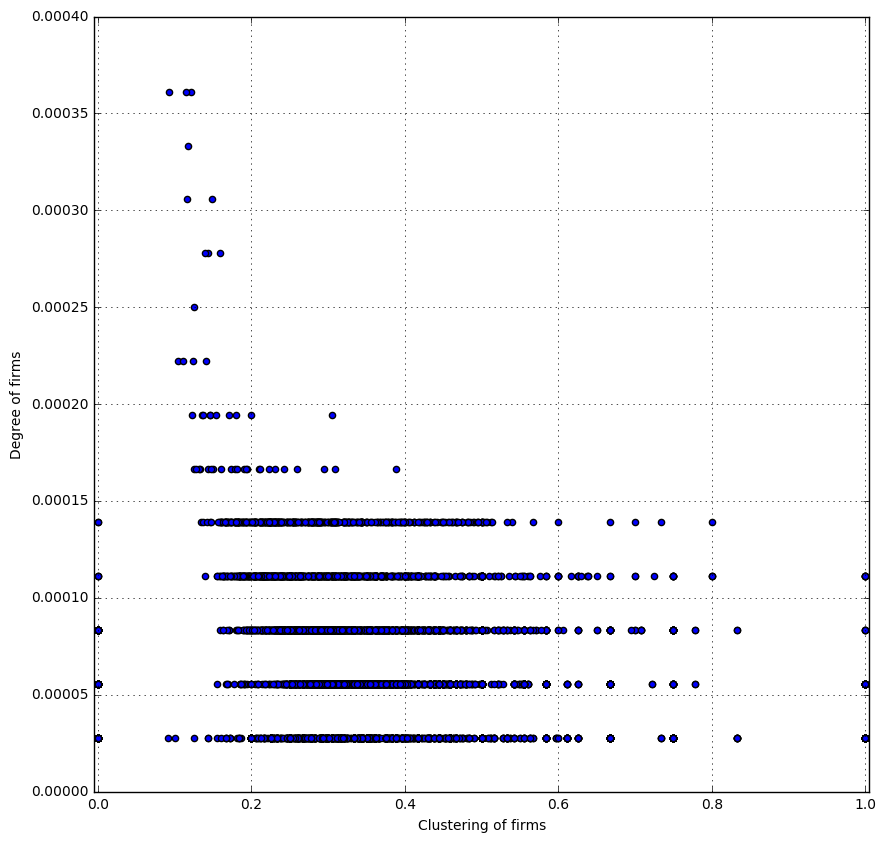

In [93]:
# Peru
BvD_nodes = set(n for n, d in PEG.nodes(data=True) if d['bipartite']==0)
UCI_nodes = set(PEG) - BvD_nodes

fcluPE = nx.bipartite.latapy_clustering(PEG, BvD_nodes)
icluPE = nx.bipartite.latapy_clustering(PEG, UCI_nodes)
fdegcenPE = nx.bipartite.degree_centrality(PEG, BvD_nodes)

# dict to df
df_fcluPE = pd.DataFrame(list(fcluPE.items()), columns=['firm', 'clu'])
df_icluPE = pd.DataFrame(list(icluPE.items()), columns=['ind', 'clu'])
df_degPE = pd.DataFrame(list(fdegcenPE.items()), columns=['node', 'degree'])
df_fcluPE['mode'] = 'upper'
df_icluPE['mode'] = 'lower'

df1 = pd.merge(df_degPE, df_fcluPE, left_on='node', right_on='firm', how='left')
df2 = pd.merge(df1, df_icluPE, left_on='node', right_on='ind', how='left')

# take cases where non NaN in firm = take only firms
df3 = df2.dropna(subset = ['firm'])

ax = df3.plot.scatter(x='clu_x',y='degree' , figsize=(10,10))
ax.grid(True)
plt.ylabel('Degree of firms')
plt.xlabel('Clustering of firms')
plt.xlim((-0.005, 1.005))
plt.ylim((0, 0.0004))
# plt.title('PE')

(0, 0.0012)

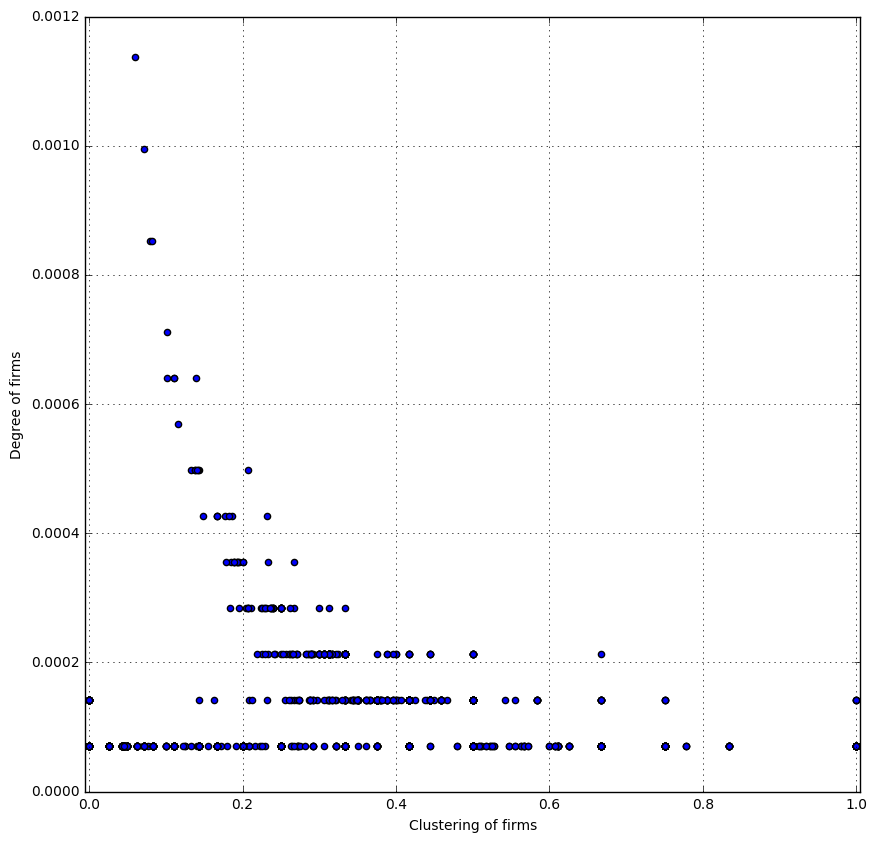

In [95]:
# Lithualina
BvD_nodes = set(n for n, d in LTG.nodes(data=True) if d['bipartite']==0)
UCI_nodes = set(LTG) - BvD_nodes

fcluLT = nx.bipartite.latapy_clustering(LTG, BvD_nodes)
icluLT = nx.bipartite.latapy_clustering(LTG, UCI_nodes)
fdegcenLT = nx.bipartite.degree_centrality(LTG, BvD_nodes)

# dict to df
df_fcluLT = pd.DataFrame(list(fcluLT.items()), columns=['firm', 'clu'])
df_icluLT = pd.DataFrame(list(icluLT.items()), columns=['ind', 'clu'])
df_degLT = pd.DataFrame(list(fdegcenLT.items()), columns=['node', 'degree'])
df_fcluLT['mode'] = 'upper'
df_icluLT['mode'] = 'lower'

df1 = pd.merge(df_degLT, df_fcluLT, left_on='node', right_on='firm', how='left')
df2 = pd.merge(df1, df_icluLT, left_on='node', right_on='ind', how='left')

# take cases where non NaN in firm = take only firms
df3 = df2.dropna(subset = ['firm'])

ax = df3.plot.scatter(x='clu_x',y='degree' , figsize=(10,10))
ax.grid(True)
plt.ylabel('Degree of firms')
plt.xlabel('Clustering of firms')
plt.xlim((-0.005, 1.005))
plt.ylim((0, 0.0012))
# plt.title('LT')

In [ ]:
# Croatia: clu f > 0.4, clu ind < 0.2
# DK: clu f > 0.4, clu ind < 0.3
# NL: clu f > 0.3, clu ind < 0.1
# Poland: clu f > 0.2, clu ind < 0.1

(0, 0.0022)

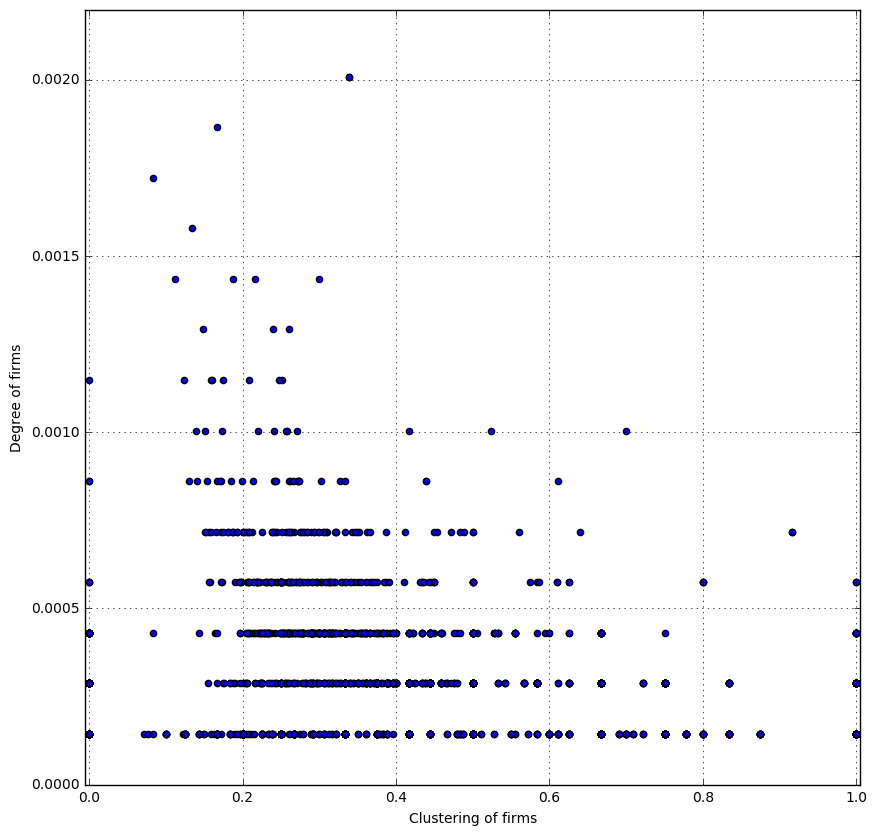

In [98]:
# Croatia
BvD_nodes = set(n for n, d in HRG.nodes(data=True) if d['bipartite']==0)
UCI_nodes = set(HRG) - BvD_nodes

fcluHR = nx.bipartite.latapy_clustering(HRG, BvD_nodes)
icluHR = nx.bipartite.latapy_clustering(HRG, UCI_nodes)
fdegcenHR = nx.bipartite.degree_centrality(HRG, BvD_nodes)

# dict to df
df_fcluHR = pd.DataFrame(list(fcluHR.items()), columns=['firm', 'clu'])
df_icluHR = pd.DataFrame(list(icluHR.items()), columns=['ind', 'clu'])
df_degHR = pd.DataFrame(list(fdegcenHR.items()), columns=['node', 'degree'])
df_fcluHR['mode'] = 'upper'
df_icluHR['mode'] = 'lower'

df1 = pd.merge(df_degHR, df_fcluHR, left_on='node', right_on='firm', how='left')
df2 = pd.merge(df1, df_icluHR, left_on='node', right_on='ind', how='left')

# take cases where non NaN in firm = take only firms
df3 = df2.dropna(subset = ['firm'])

ax = df3.plot.scatter(x='clu_x',y='degree' , figsize=(10,10))
ax.grid(True)
plt.ylabel('Degree of firms')
plt.xlabel('Clustering of firms')
plt.xlim((-0.005, 1.005))
plt.ylim((0, 0.0022))
# plt.title('HR')

(0, 0.0005)

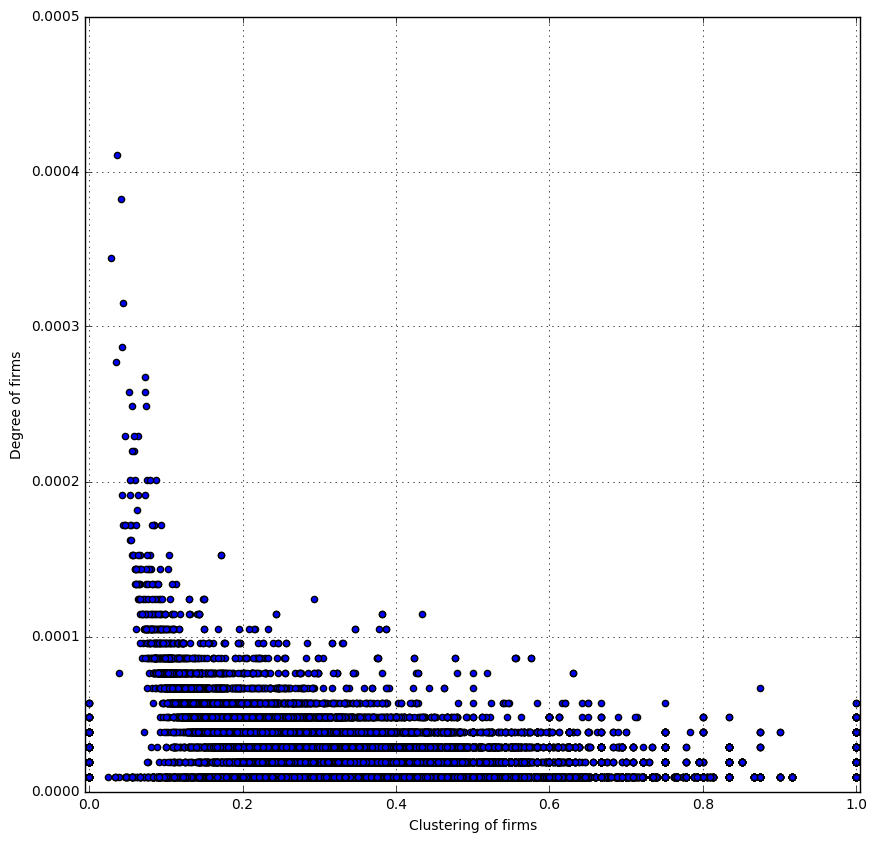

In [101]:
# DK: clu f > 0.4, clu ind < 0.3
BvD_nodes = set(n for n, d in DKG.nodes(data=True) if d['bipartite']==0)
UCI_nodes = set(DKG) - BvD_nodes

fcluDK = nx.bipartite.latapy_clustering(DKG, BvD_nodes)
icluDK = nx.bipartite.latapy_clustering(DKG, UCI_nodes)
fdegcenDK = nx.bipartite.degree_centrality(DKG, BvD_nodes)

# dict to df
df_fcluDK = pd.DataFrame(list(fcluDK.items()), columns=['firm', 'clu'])
df_icluDK = pd.DataFrame(list(icluDK.items()), columns=['ind', 'clu'])
df_degDK = pd.DataFrame(list(fdegcenDK.items()), columns=['node', 'degree'])
df_fcluDK['mode'] = 'upper'
df_icluDK['mode'] = 'lower'

df1 = pd.merge(df_degDK, df_fcluDK, left_on='node', right_on='firm', how='left')
df2 = pd.merge(df1, df_icluDK, left_on='node', right_on='ind', how='left')

# take cases where non NaN in firm = take only firms
df3 = df2.dropna(subset = ['firm'])

ax = df3.plot.scatter(x='clu_x',y='degree' , figsize=(10,10))
ax.grid(True)
plt.ylabel('Degree of firms')
plt.xlabel('Clustering of firms')
plt.xlim((-0.005, 1.005))
plt.ylim((0, 0.0005))
# plt.title('DK')

(0, 0.0008)

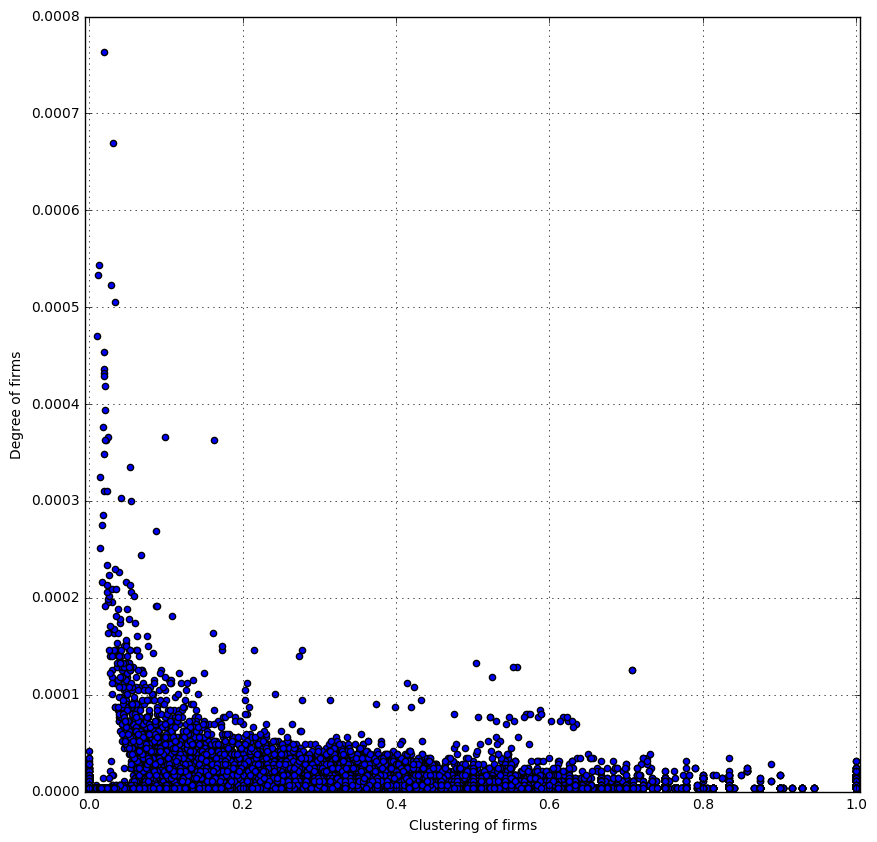

In [104]:
# NL: clu f > 0.3, clu ind < 0.1

BvD_nodes = set(n for n, d in NLG.nodes(data=True) if d['bipartite']==0)
UCI_nodes = set(NLG) - BvD_nodes

fcluNL = nx.bipartite.latapy_clustering(NLG, BvD_nodes)
icluNL = nx.bipartite.latapy_clustering(NLG, UCI_nodes)
fdegcenNL = nx.bipartite.degree_centrality(NLG, BvD_nodes)

# dict to df
df_fcluNL = pd.DataFrame(list(fcluNL.items()), columns=['firm', 'clu'])
df_icluNL = pd.DataFrame(list(icluNL.items()), columns=['ind', 'clu'])
df_degNL = pd.DataFrame(list(fdegcenNL.items()), columns=['node', 'degree'])
df_fcluNL['mode'] = 'upper'
df_icluNL['mode'] = 'lower'

df1 = pd.merge(df_degNL, df_fcluNL, left_on='node', right_on='firm', how='left')
df2 = pd.merge(df1, df_icluNL, left_on='node', right_on='ind', how='left')

# take cases where non NaN in firm = take only firms
df3 = df2.dropna(subset = ['firm'])

ax = df3.plot.scatter(x='clu_x',y='degree' , figsize=(10,10))
ax.grid(True)
plt.ylabel('Degree of firms')
plt.xlabel('Clustering of firms')
plt.xlim((-0.005, 1.005))
plt.ylim((0, 0.0008))
# plt.title('NL')


(0, 0.001)

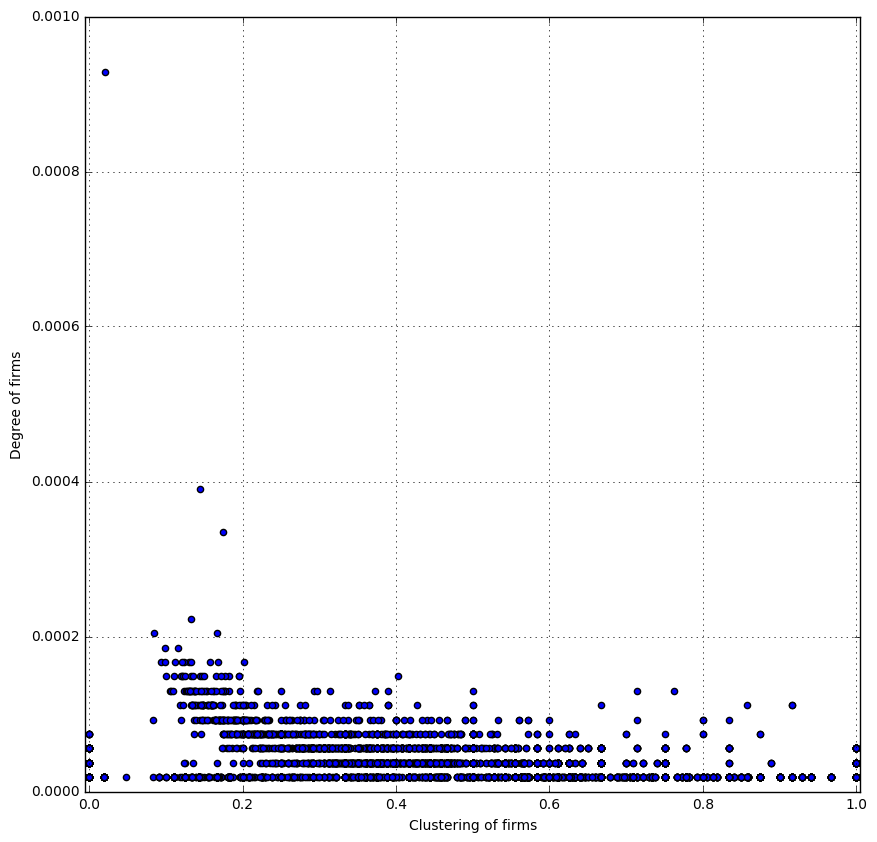

In [106]:
# Poland: clu f > 0.2, clu ind < 0.1
BvD_nodes = set(n for n, d in PLG.nodes(data=True) if d['bipartite']==0)
UCI_nodes = set(PLG) - BvD_nodes

fcluPL = nx.bipartite.latapy_clustering(PLG, BvD_nodes)
icluPL = nx.bipartite.latapy_clustering(PLG, UCI_nodes)
fdegcenPL = nx.bipartite.degree_centrality(PLG, BvD_nodes)

# dict to df
df_fcluPL = pd.DataFrame(list(fcluPL.items()), columns=['firm', 'clu'])
df_icluPL = pd.DataFrame(list(icluPL.items()), columns=['ind', 'clu'])
df_degPL = pd.DataFrame(list(fdegcenPL.items()), columns=['node', 'degree'])
df_fcluPL['mode'] = 'upper'
df_icluPL['mode'] = 'lower'

df1 = pd.merge(df_degPL, df_fcluPL, left_on='node', right_on='firm', how='left')
df2 = pd.merge(df1, df_icluPL, left_on='node', right_on='ind', how='left')

# take cases where non NaN in firm = take only firms
df3 = df2.dropna(subset = ['firm'])

ax = df3.plot.scatter(x='clu_x',y='degree' , figsize=(10,10))
ax.grid(True)
plt.ylabel('Degree of firms')
plt.xlabel('Clustering of firms')
plt.xlim((-0.005, 1.005))
plt.ylim((0, 0.001))
# plt.title('PL')

###  Countries with high ind clustering

(0, 0.0004)

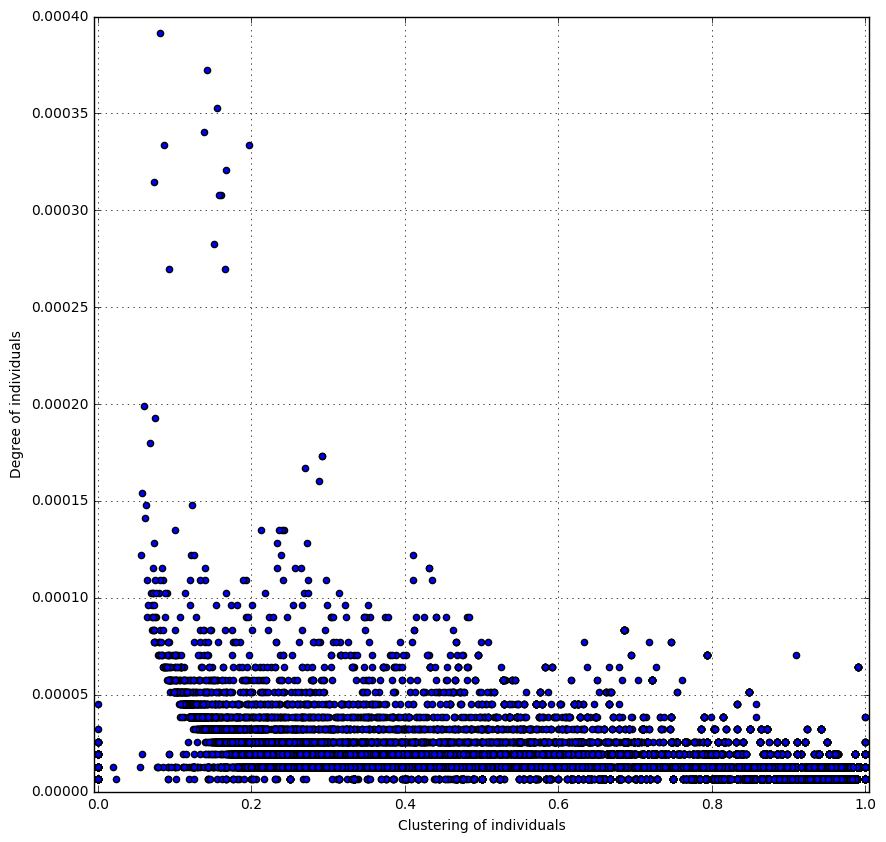

In [112]:
# US: clu i > 0.2, clu f < 0.2
BvD_nodes = set(n for n, d in USG.nodes(data=True) if d['bipartite']==0)
UCI_nodes = set(USG) - BvD_nodes

fcluUS = nx.bipartite.latapy_clustering(USG, BvD_nodes)
icluUS = nx.bipartite.latapy_clustering(USG, UCI_nodes)
fdegcenUS = nx.bipartite.degree_centrality(USG, BvD_nodes)

# dict to df
df_fcluUS = pd.DataFrame(list(fcluUS.items()), columns=['firm', 'clu'])
df_icluUS = pd.DataFrame(list(icluUS.items()), columns=['ind', 'clu'])
df_degUS = pd.DataFrame(list(fdegcenUS.items()), columns=['node', 'degree'])
df_fcluUS['mode'] = 'upper'
df_icluUS['mode'] = 'lower'

df1 = pd.merge(df_degUS, df_fcluUS, left_on='node', right_on='firm', how='left')
df2 = pd.merge(df1, df_icluUS, left_on='node', right_on='ind', how='left')

# take cases where non NaN in firm = take only inds
df3 = df2.dropna(subset = ['ind'])

ax = df3.plot.scatter(x='clu_y',y='degree' , figsize=(10,10))
ax.grid(True)
plt.ylabel('Degree of individuals')
plt.xlabel('Clustering of individuals')
plt.xlim((-0.005, 1.005))
plt.ylim((0, 0.0004))
# plt.title('US')

(0, 0.00015)

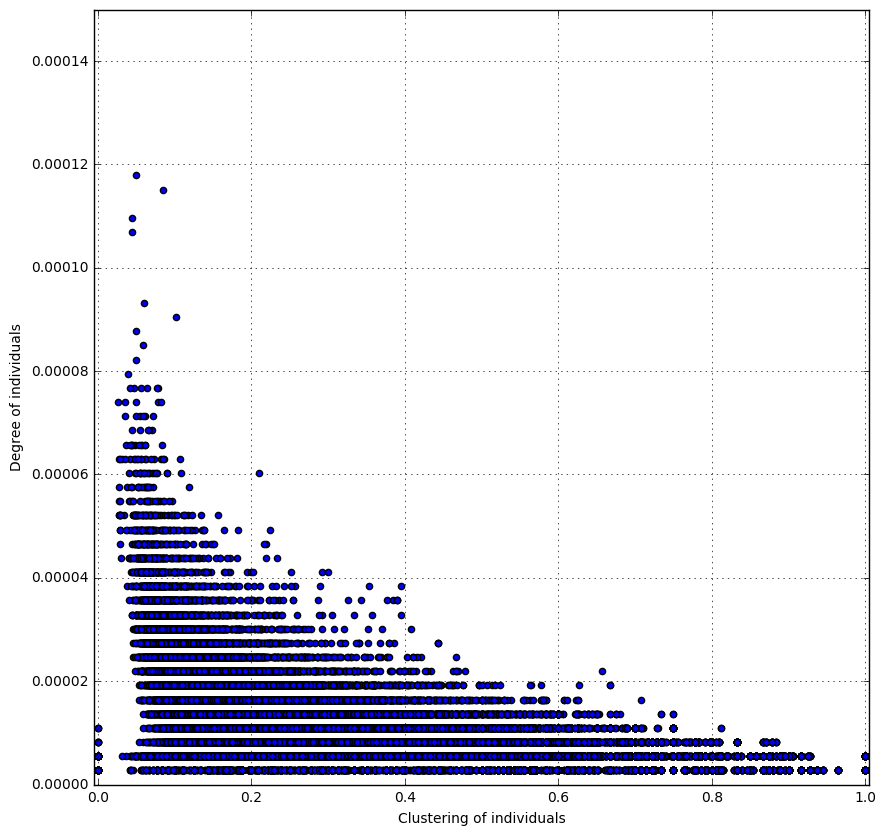

In [125]:
# Indina clu ind > 0.4, clu f < 0.3
BvD_nodes = set(n for n, d in ING.nodes(data=True) if d['bipartite']==0)
UCI_nodes = set(ING) - BvD_nodes

fcluIN = nx.bipartite.latapy_clustering(ING, BvD_nodes)
icluIN = nx.bipartite.latapy_clustering(ING, UCI_nodes)
fdegcenIN = nx.bipartite.degree_centrality(ING, BvD_nodes)

# dict to df
df_fcluIN = pd.DataFrame(list(fcluIN.items()), columns=['firm', 'clu'])
df_icluIN = pd.DataFrame(list(icluIN.items()), columns=['ind', 'clu'])
df_degIN = pd.DataFrame(list(fdegcenIN.items()), columns=['node', 'degree'])
df_fcluIN['mode'] = 'upper'
df_icluIN['mode'] = 'lower'

df1 = pd.merge(df_degIN, df_fcluIN, left_on='node', right_on='firm', how='left')
df2 = pd.merge(df1, df_icluIN, left_on='node', right_on='ind', how='left')

# take cases where non NaN in firm = take only inds
df3 = df2.dropna(subset = ['ind'])

ax = df3.plot.scatter(x='clu_y',y='degree' , figsize=(10,10))
ax.grid(True)
plt.ylabel('Degree of individuals')
plt.xlabel('Clustering of individuals')
plt.xlim((-0.005, 1.005))
plt.ylim((0, 0.00015))
# plt.title('IN')

(0, 0.001)

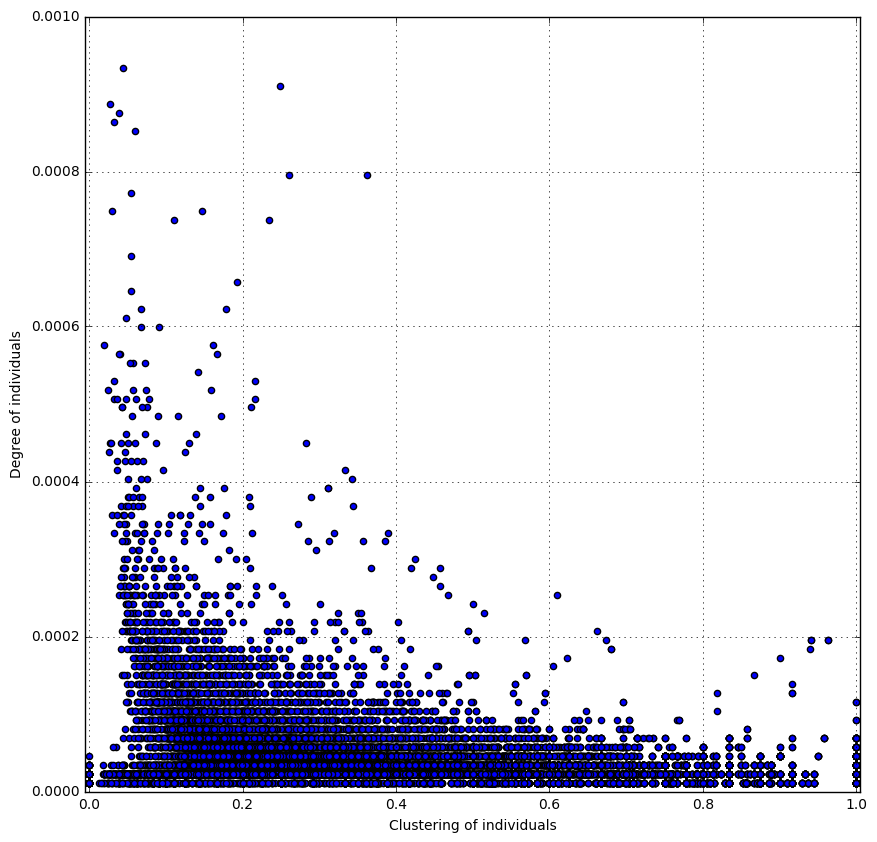

In [129]:
# Ireland clu ind > 0.4, clu f < 0.3
BvD_nodes = set(n for n, d in IEG.nodes(data=True) if d['bipartite']==0)
UCI_nodes = set(IEG) - BvD_nodes

fcluIE = nx.bipartite.latapy_clustering(IEG, BvD_nodes)
icluIE = nx.bipartite.latapy_clustering(IEG, UCI_nodes)
fdegcenIE = nx.bipartite.degree_centrality(IEG, BvD_nodes)

# dict to df
df_fcluIE = pd.DataFrame(list(fcluIE.items()), columns=['firm', 'clu'])
df_icluIE = pd.DataFrame(list(icluIE.items()), columns=['ind', 'clu'])
df_degIE = pd.DataFrame(list(fdegcenIE.items()), columns=['node', 'degree'])
df_fcluIE['mode'] = 'upper'
df_icluIE['mode'] = 'lower'

df1 = pd.merge(df_degIE, df_fcluIE, left_on='node', right_on='firm', how='left')
df2 = pd.merge(df1, df_icluIE, left_on='node', right_on='ind', how='left')

# take cases where non NaN in firm = take only inds
df3 = df2.dropna(subset = ['ind'])

ax = df3.plot.scatter(x='clu_y',y='degree' , figsize=(10,10))
ax.grid(True)
plt.ylabel('Degree of individuals')
plt.xlabel('Clustering of individuals')
plt.xlim((-0.005, 1.005))
plt.ylim((0, 0.001))
# plt.title('IE')

(0, 0.004)

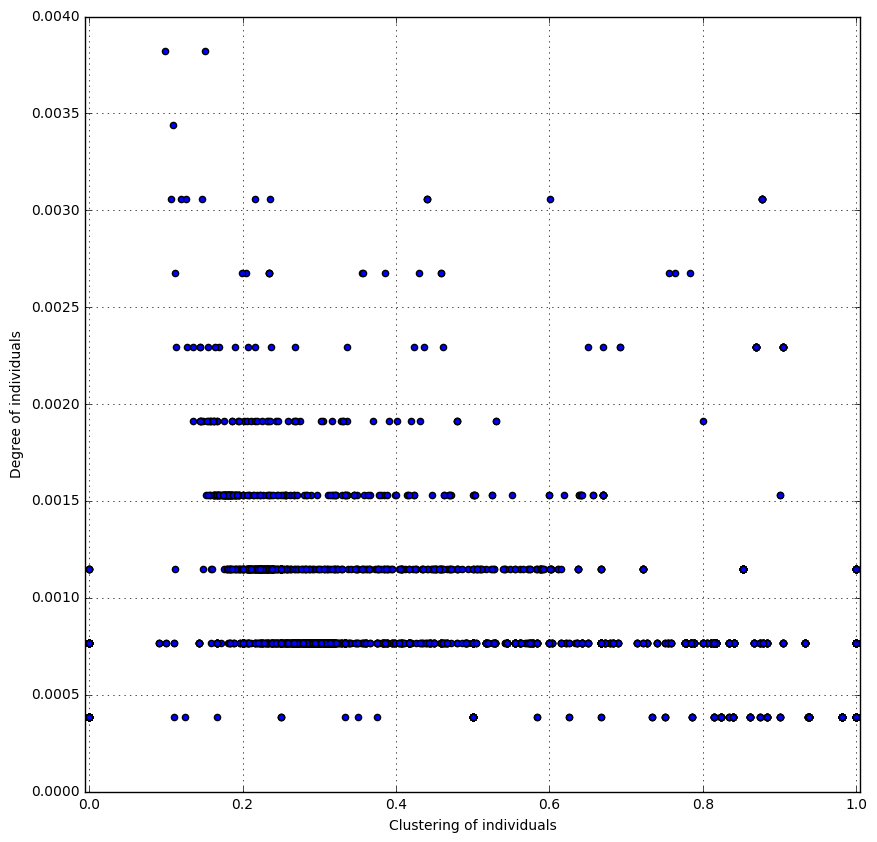

In [131]:
# Canda : clu ind > 0.4, clu f < 0.3

BvD_nodes = set(n for n, d in CAG.nodes(data=True) if d['bipartite']==0)
UCI_nodes = set(CAG) - BvD_nodes

fcluCA = nx.bipartite.latapy_clustering(CAG, BvD_nodes)
icluCA = nx.bipartite.latapy_clustering(CAG, UCI_nodes)
fdegcenCA = nx.bipartite.degree_centrality(CAG, BvD_nodes)

# dict to df
df_fcluCA = pd.DataFrame(list(fcluCA.items()), columns=['firm', 'clu'])
df_icluCA = pd.DataFrame(list(icluCA.items()), columns=['ind', 'clu'])
df_degCA = pd.DataFrame(list(fdegcenCA.items()), columns=['node', 'degree'])
df_fcluCA['mode'] = 'upper'
df_icluCA['mode'] = 'lower'

df1 = pd.merge(df_degCA, df_fcluCA, left_on='node', right_on='firm', how='left')
df2 = pd.merge(df1, df_icluCA, left_on='node', right_on='ind', how='left')

# take cases where non NaN in firm = take only inds
df3 = df2.dropna(subset = ['ind'])

ax = df3.plot.scatter(x='clu_y',y='degree' , figsize=(10,10))
ax.grid(True)
plt.ylabel('Degree of individuals')
plt.xlabel('Clustering of individuals')
plt.xlim((-0.005, 1.005))
plt.ylim((0, 0.004))
# plt.title('CA')

## Average degree and clustering

(1.0, 3.7)

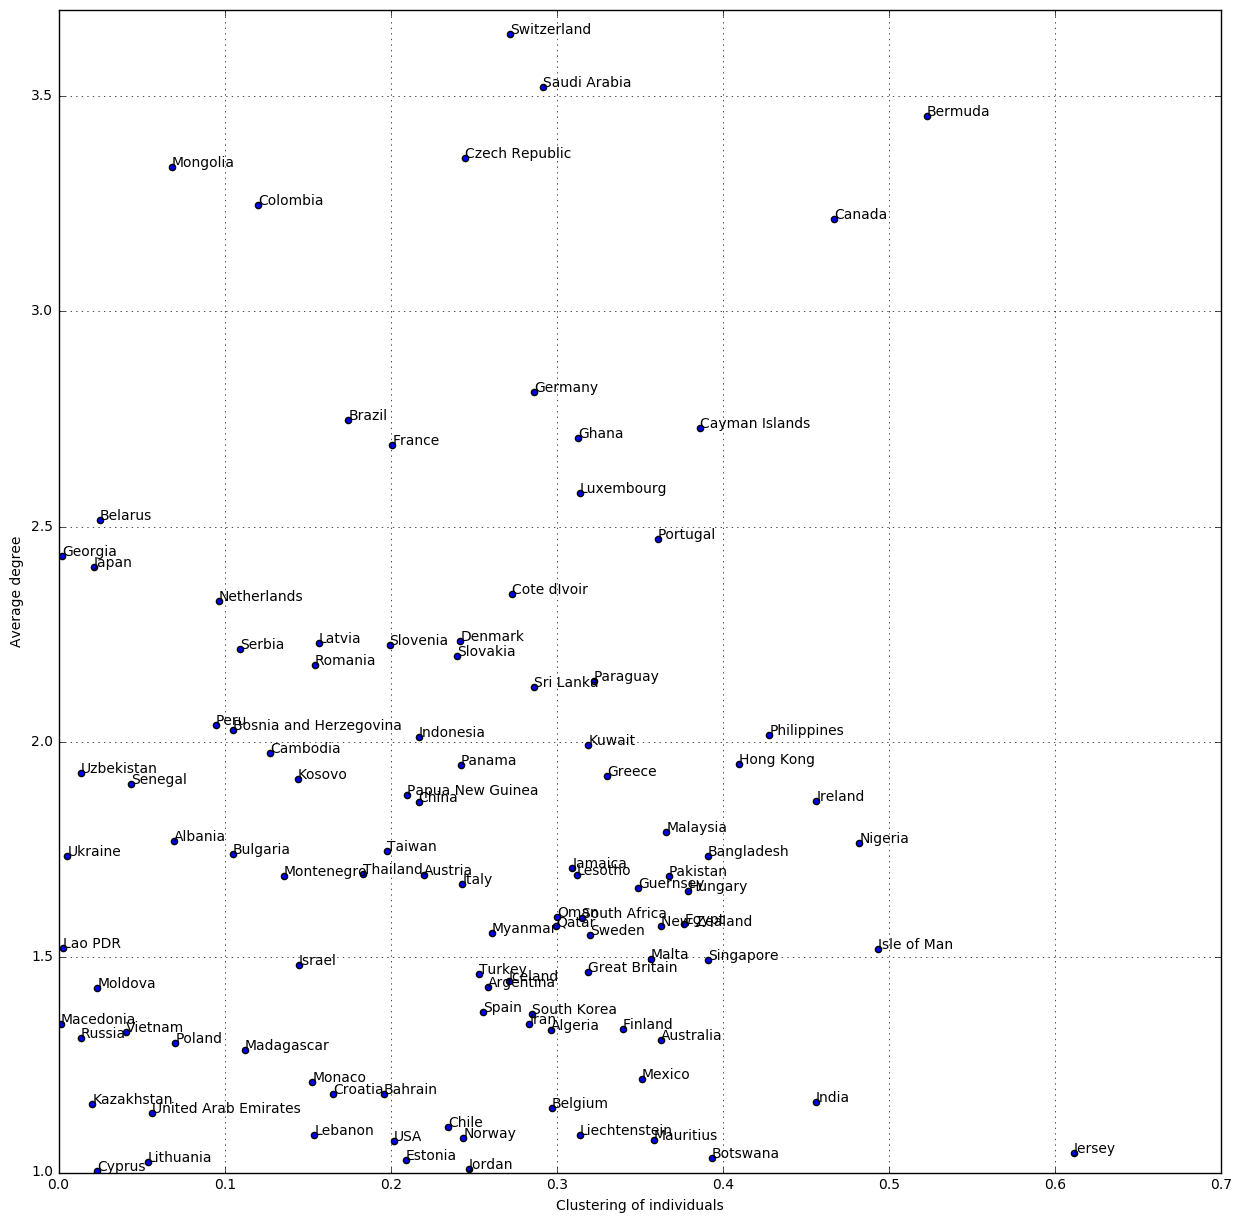

In [147]:
# Inds
ax = stat.plot.scatter(x='clu_inds',y='ave_degree', figsize=(15,15))
ax.grid(True)
stat[['clu_inds','ave_degree','country_name']].apply(lambda x: ax.text(*x),axis=1)
plt.ylabel('Average degree')
plt.xlabel('Clustering of individuals')
plt.xlim((0.00, 0.7))
plt.ylim((1.00, 3.7))

(1.0, 3.7)

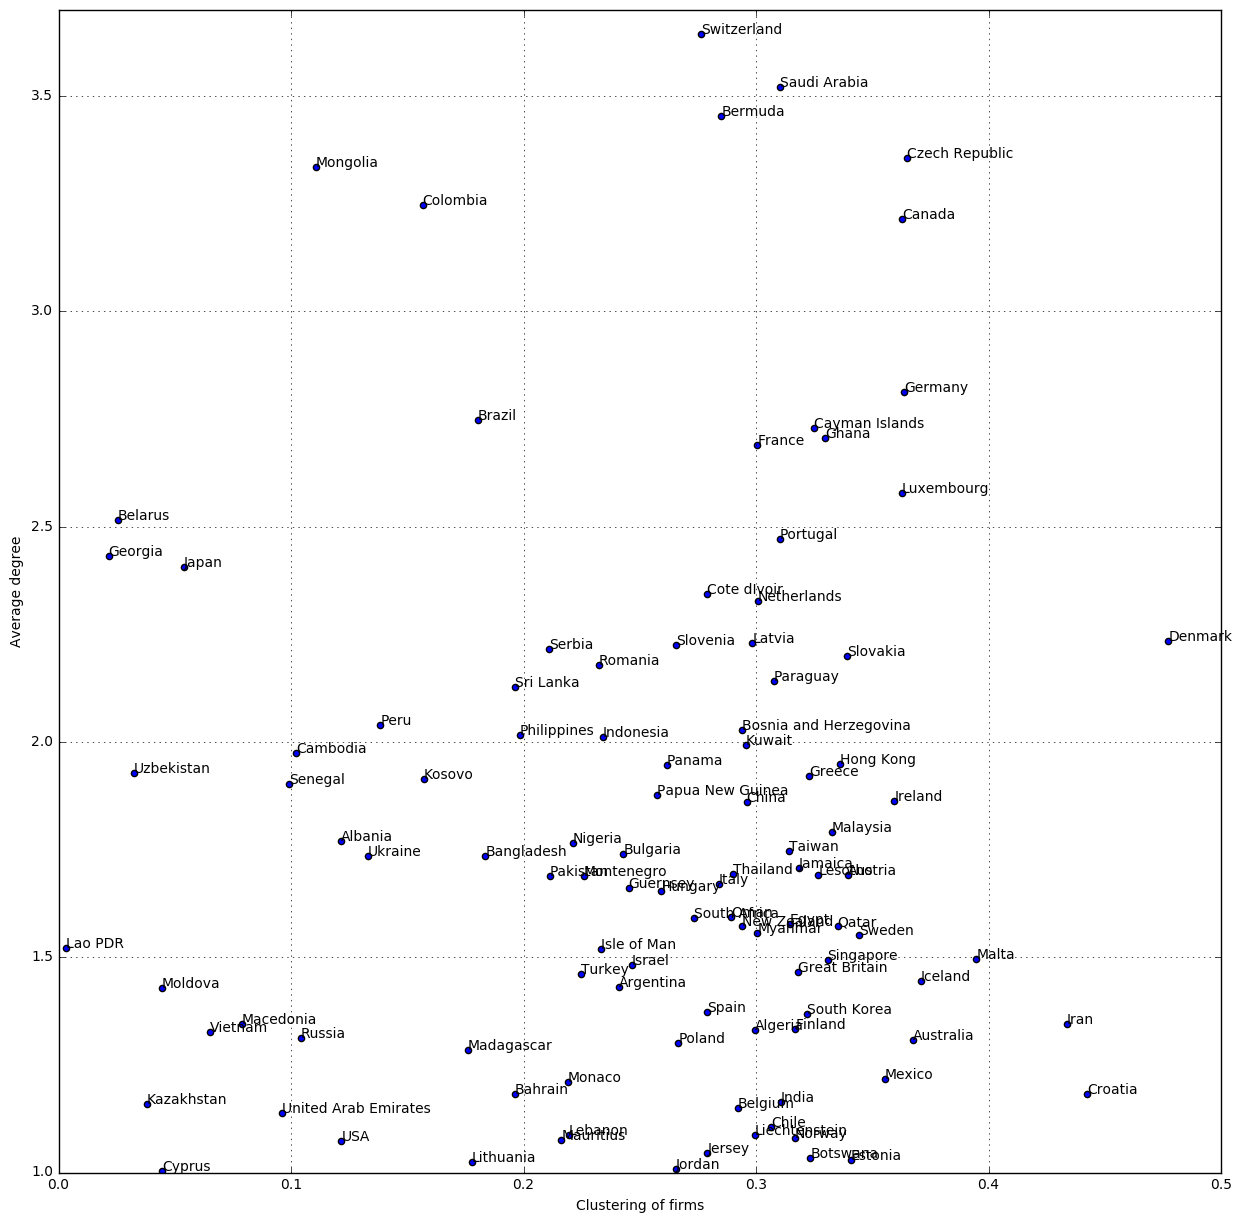

In [146]:
# Firms
ax = stat.plot.scatter(x='clu_firms',y='ave_degree', figsize=(15,15))
ax.grid(True)
stat[['clu_firms','ave_degree','country_name']].apply(lambda x: ax.text(*x),axis=1)
plt.ylabel('Average degree')
plt.xlabel('Clustering of firms')
plt.xlim((0.00, 0.5))
plt.ylim((1.00, 3.7))

In [ ]:
## what does it mean:
# there are highly clustered nodes but they all have a low degree
# (it's easy to be clustered when you don't have lots of neighbors)
# if the node is with a high degree, it's low in clustering
# but low degree nodes can be both high and low clustered

## Assortativity

In [268]:
for i in countries:
    print (nx.degree_assortativity_coefficient(i))
    
# from -1 to 1

0.378713756544
0.491871096707
0.0758533878548
0.301066026494
0.0961726670902
0.100651300156
0.283875961678
-0.303285282786
0.173927039978
0.272051672467
0.344883186409
-0.191427129175
0.230843814796
0.158785478208
0.360193920335
-0.0897835754687
0.0217052975778
0.090679579505
0.332546889071
0.0683758161703
0.371714640527
0.542814671342
0.114026902042
0.0694369081766
0.0637918486474
0.280947780727
0.208940738529
0.120771703981
0.176544189187
0.110766380836
0.243361785539
0.00288756037639
0.285011906717
0.160293066476
0.164470454032
0.140700479791
0.157521426189
0.314950561446
0.0573300827196
0.246303339109
0.00406786823434
0.285297446248
0.0599010951861
0.148011554422
-0.00531552847373
0.204859669358
0.119397226255
0.00775488924731
0.0592165852395
0.12921905236
0.206516176417
0.1615576024
-0.25296544421
0.239219444202
-0.0373857270345
0.0317869415808
0.33733653546
0.0769854222874
0.360079419868
0.856186834198
0.24697456
-0.0368331011502
0.0843362042031
0.201911289838
0.112316772495
-0.0

In [269]:
stat = pd.read_csv("ntw_stats.csv", header=0, sep=',', low_memory=False)
stat.head()

country country.1 country_name  no_edges  firms  individuals  no_nodes  \
0      TZ       TZG     Tanzania       176     74           91       165   
1      ZW       ZWG     Zimbabwe       580    126          303       429   
2      JE       JEG       Jersey       376    179          253       432   
3      NP       NPG        Nepal       101     45           65       110   
4      BM       BMG      Bermuda      3458    916         1542      2458   

    density  ave_clu_firms  ave_clu_inds  ave_clu_both  clu_robins_alexander  \
0  0.026136       0.543017      0.550052      0.546897              0.616438   
1  0.015192       0.227460      0.623150      0.506933              0.426914   
2  0.008303       0.279079      0.611415      0.473711              0.737345   
3  0.034530       0.275700      0.545000      0.434832              0.184615   
4  0.002448       0.284999      0.522960      0.434281              0.575442   

   ave_degree  no_conn_comp  size_1comp  size_2comp  size_3comp    assort  
0    2.133333            29          31          28          12  0.378714  
1    2.703963            17         347          17          12  0.491871  
2    1.740741           113          13          12          11  0.075853  
3    1.836364            15          26          18          13  0.301066  
4    2.813670            94        2016          30          25  0.096173

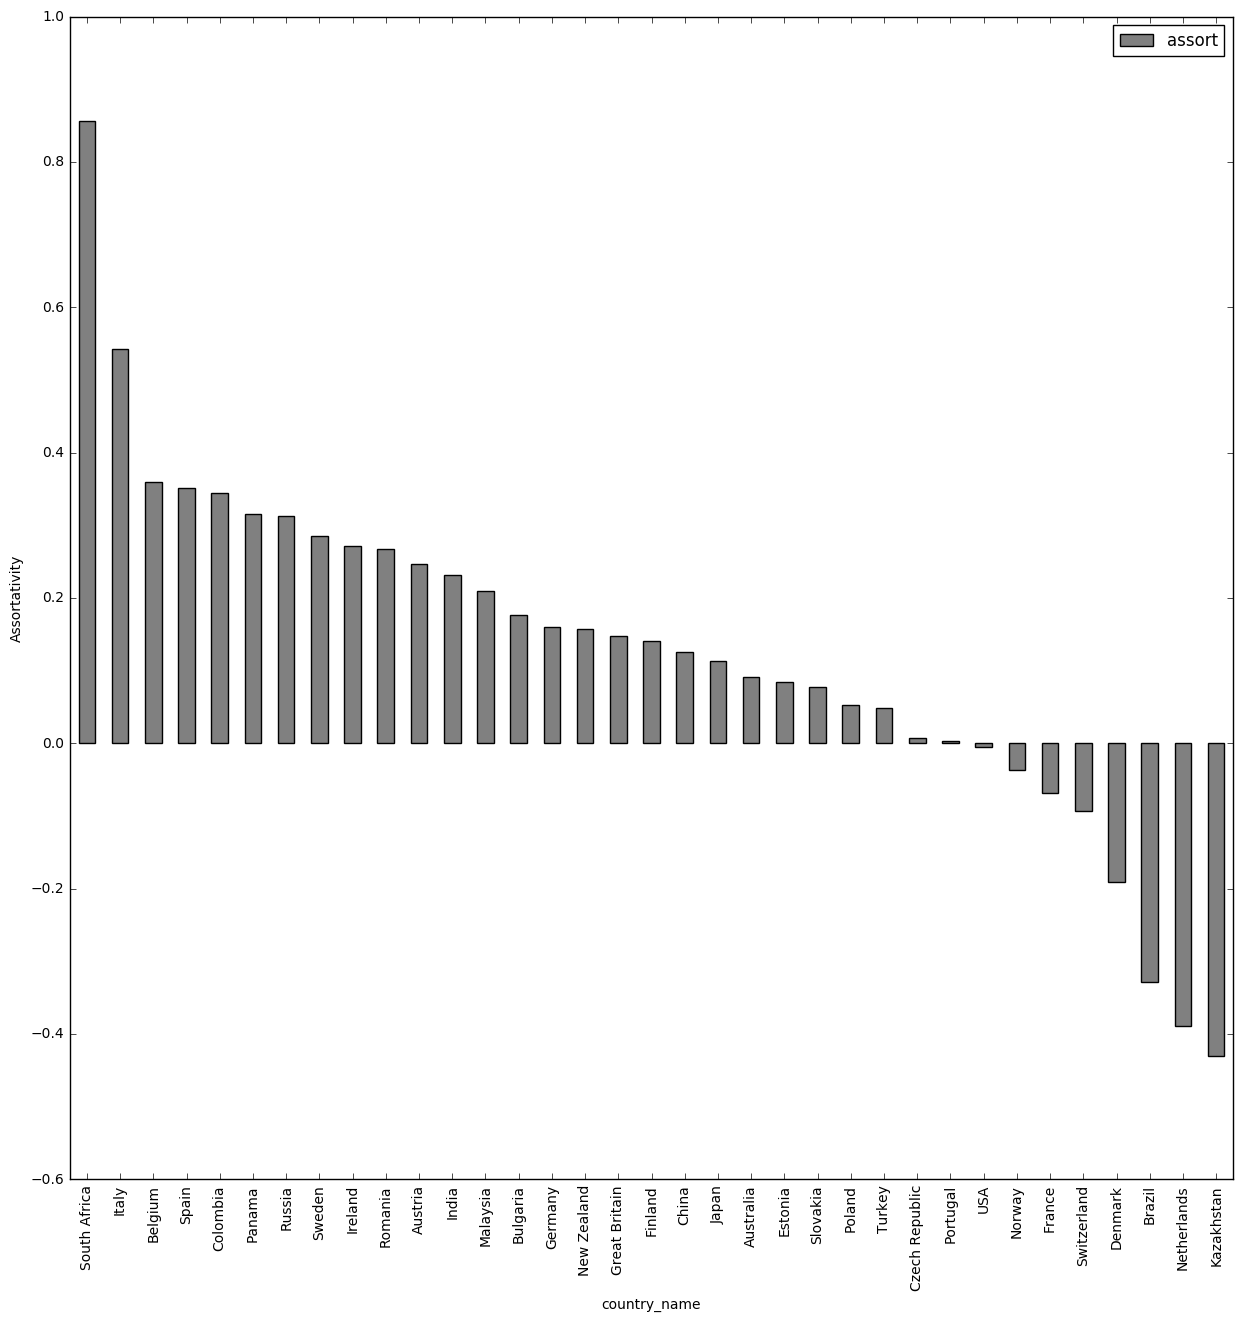

In [553]:
df6 = stat.loc[stat['no_nodes'] > 100000]
df6.sort_values('assort', ascending=False).plot(kind='bar',x='country_name', y= 'assort', color = 'grey', figsize=(15,15))
plt.ylabel('Assortativity')

## Giant components

In [284]:
stat.head()

country country.1 country_name  no_edges  firms  individuals  no_nodes  \
0      TZ       TZG     Tanzania       176     74           91       165   
1      ZW       ZWG     Zimbabwe       580    126          303       429   
2      JE       JEG       Jersey       376    179          253       432   
3      NP       NPG        Nepal       101     45           65       110   
4      BM       BMG      Bermuda      3458    916         1542      2458   

    density  ave_clu_firms  ave_clu_inds  ave_clu_both  clu_robins_alexander  \
0  0.026136       0.543017      0.550052      0.546897              0.616438   
1  0.015192       0.227460      0.623150      0.506933              0.426914   
2  0.008303       0.279079      0.611415      0.473711              0.737345   
3  0.034530       0.275700      0.545000      0.434832              0.184615   
4  0.002448       0.284999      0.522960      0.434281              0.575442   

   ave_degree  no_conn_comp  size_1comp  size_2comp  size_3comp    assort  \
0    2.133333            29          31          28          12  0.378714   
1    2.703963            17         347          17          12  0.491871   
2    1.740741           113          13          12          11  0.075853   
3    1.836364            15          26          18          13  0.301066   
4    2.813670            94        2016          30          25  0.096173   

   giant_prop  
0    0.187879  
1    0.808858  
2    0.030093  
3    0.236364  
4    0.820179

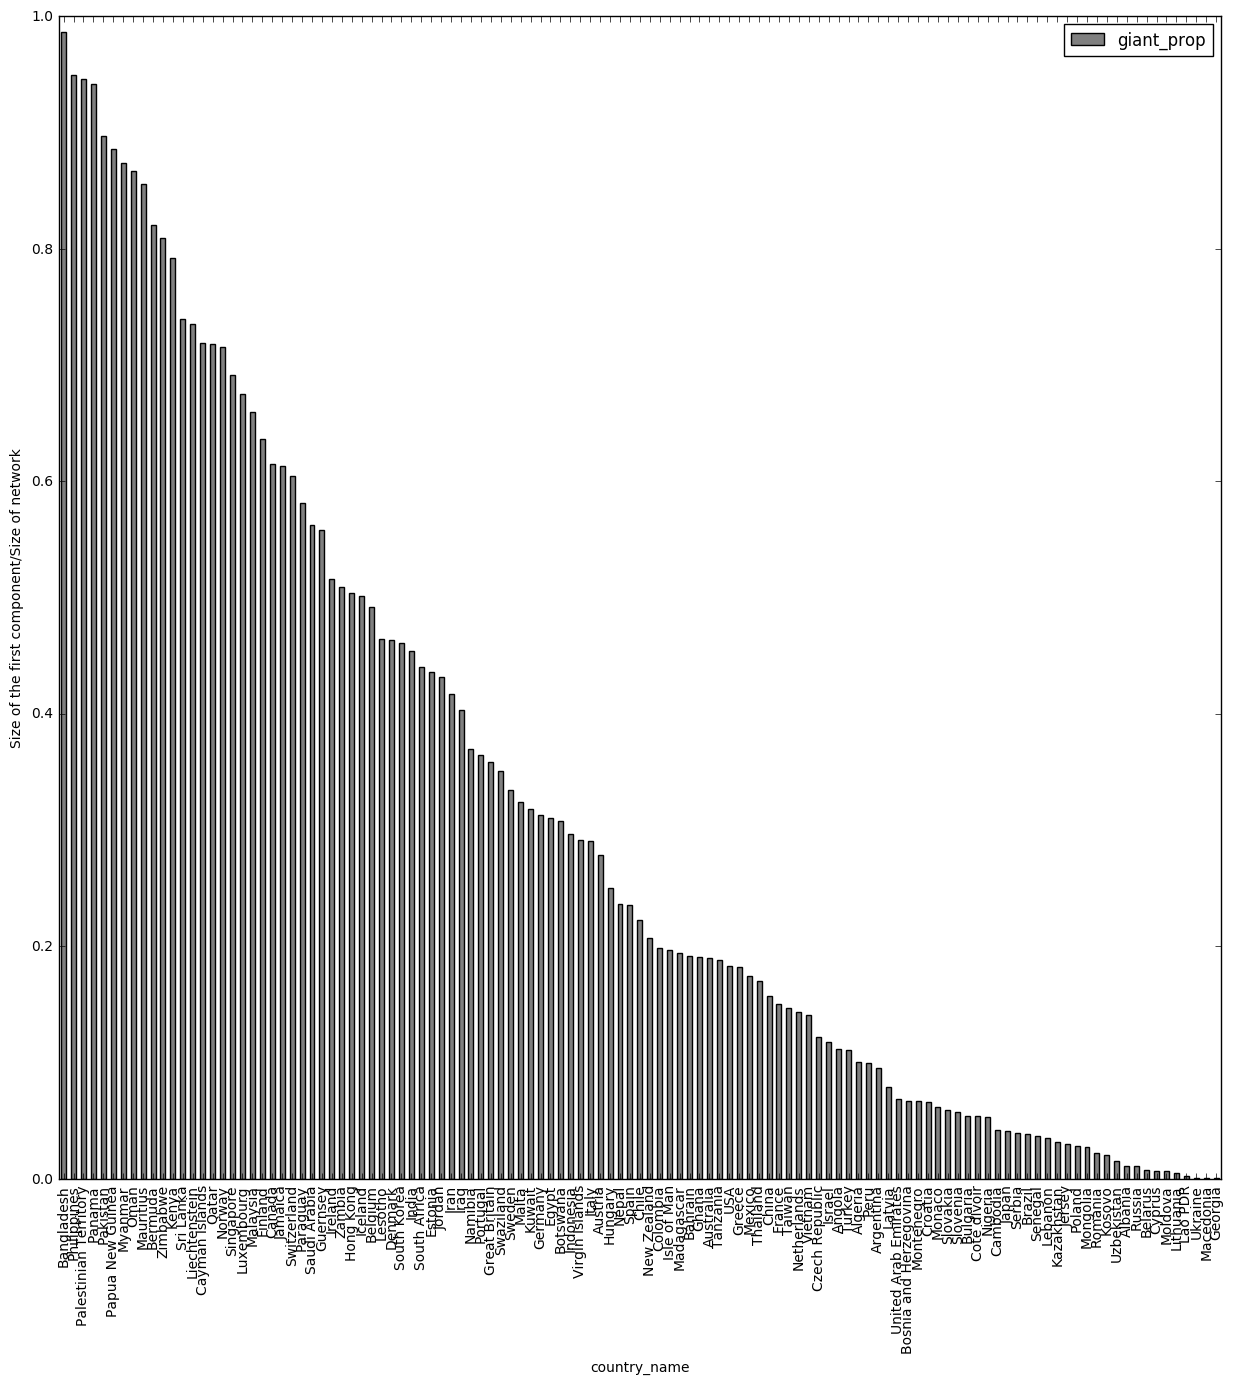

In [288]:
stat['giant_prop1'] = stat['size_1comp'] / stat['no_nodes']
stat.sort_values('giant_prop1', ascending=False).plot(kind='bar',x='country_name', y= 'giant_prop1', color = 'grey', figsize=(15,15))
plt.ylabel('Size of the first component/Size of network')

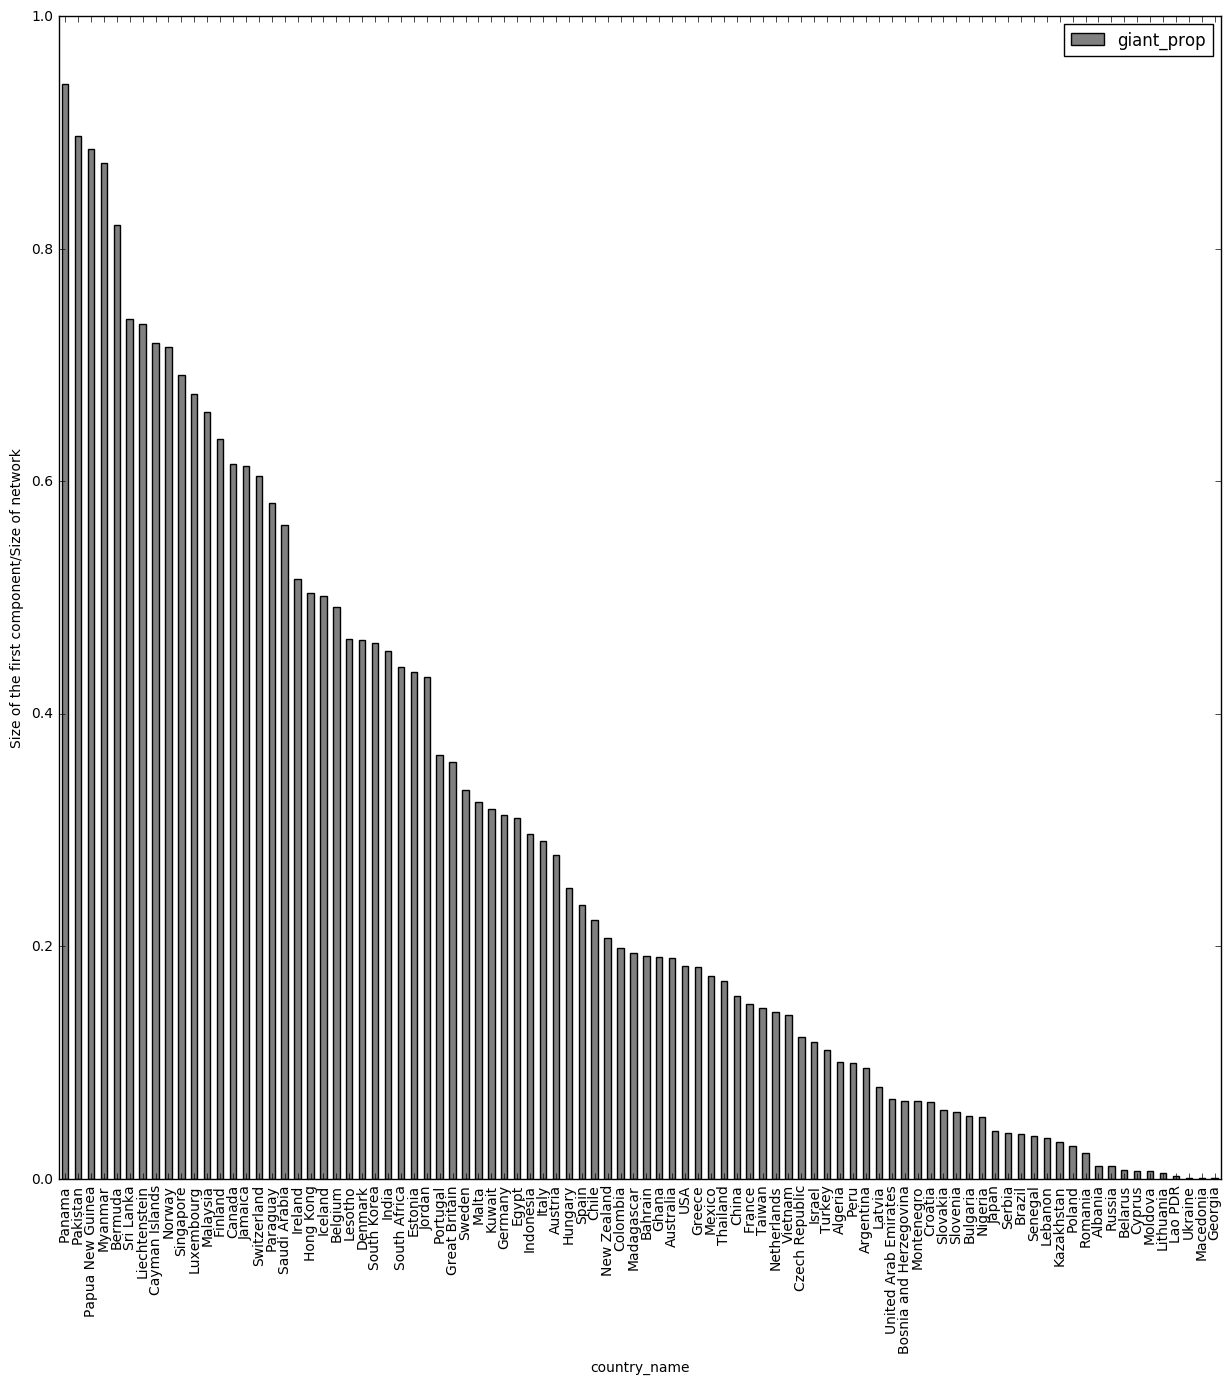

In [286]:
df6 = stat.loc[stat['no_nodes'] > 1000]
df6.sort_values('giant_prop1', ascending=False).plot(kind='bar',x='country_name', y= 'giant_prop1', color = 'grey', figsize=(15,15))
plt.ylabel('Size of the first component/Size of network')

In [ ]:
# but low numbers is ok becuase it deletes isolates too
# e.g. US no of nodes: 343321
#1st comp:62883
#2nd comp: 81
# but =62883/343321 = 0.18    

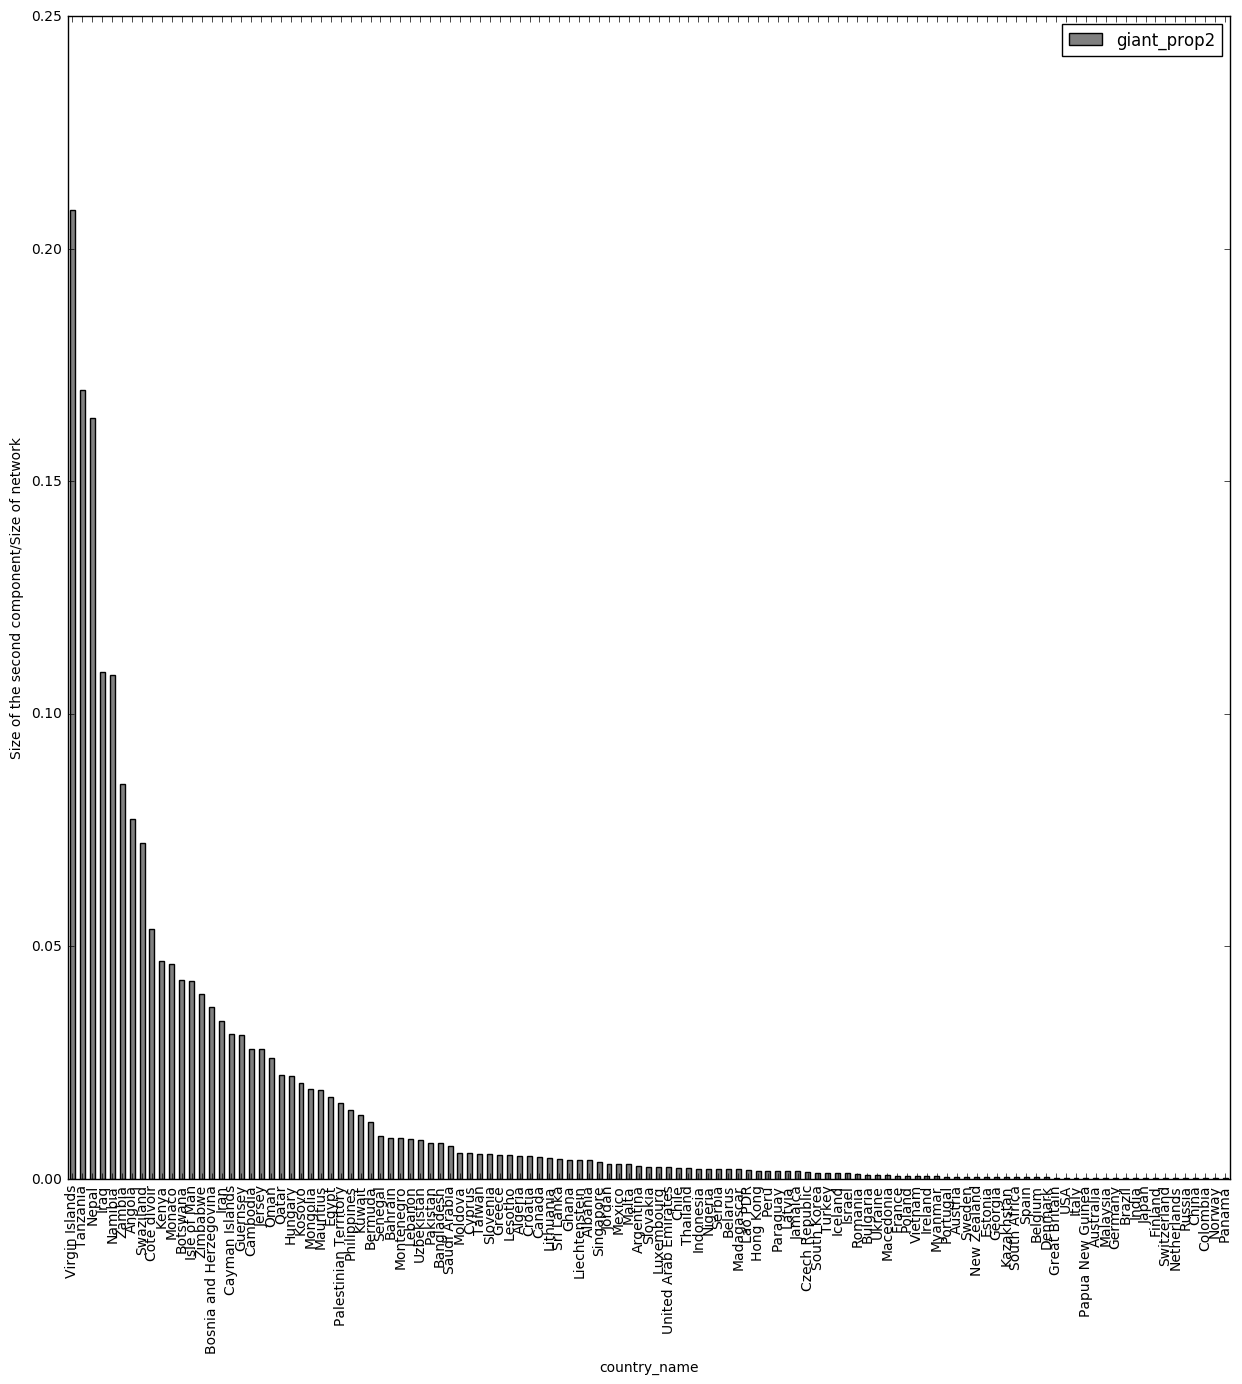

In [289]:
# Size of the second
stat['giant_prop2'] = stat['size_2comp'] / stat['no_nodes']
stat.sort_values('giant_prop2', ascending=False).plot(kind='bar',x='country_name', y= 'giant_prop2', color = 'grey', figsize=(15,15))
plt.ylabel('Size of the second component/Size of network')

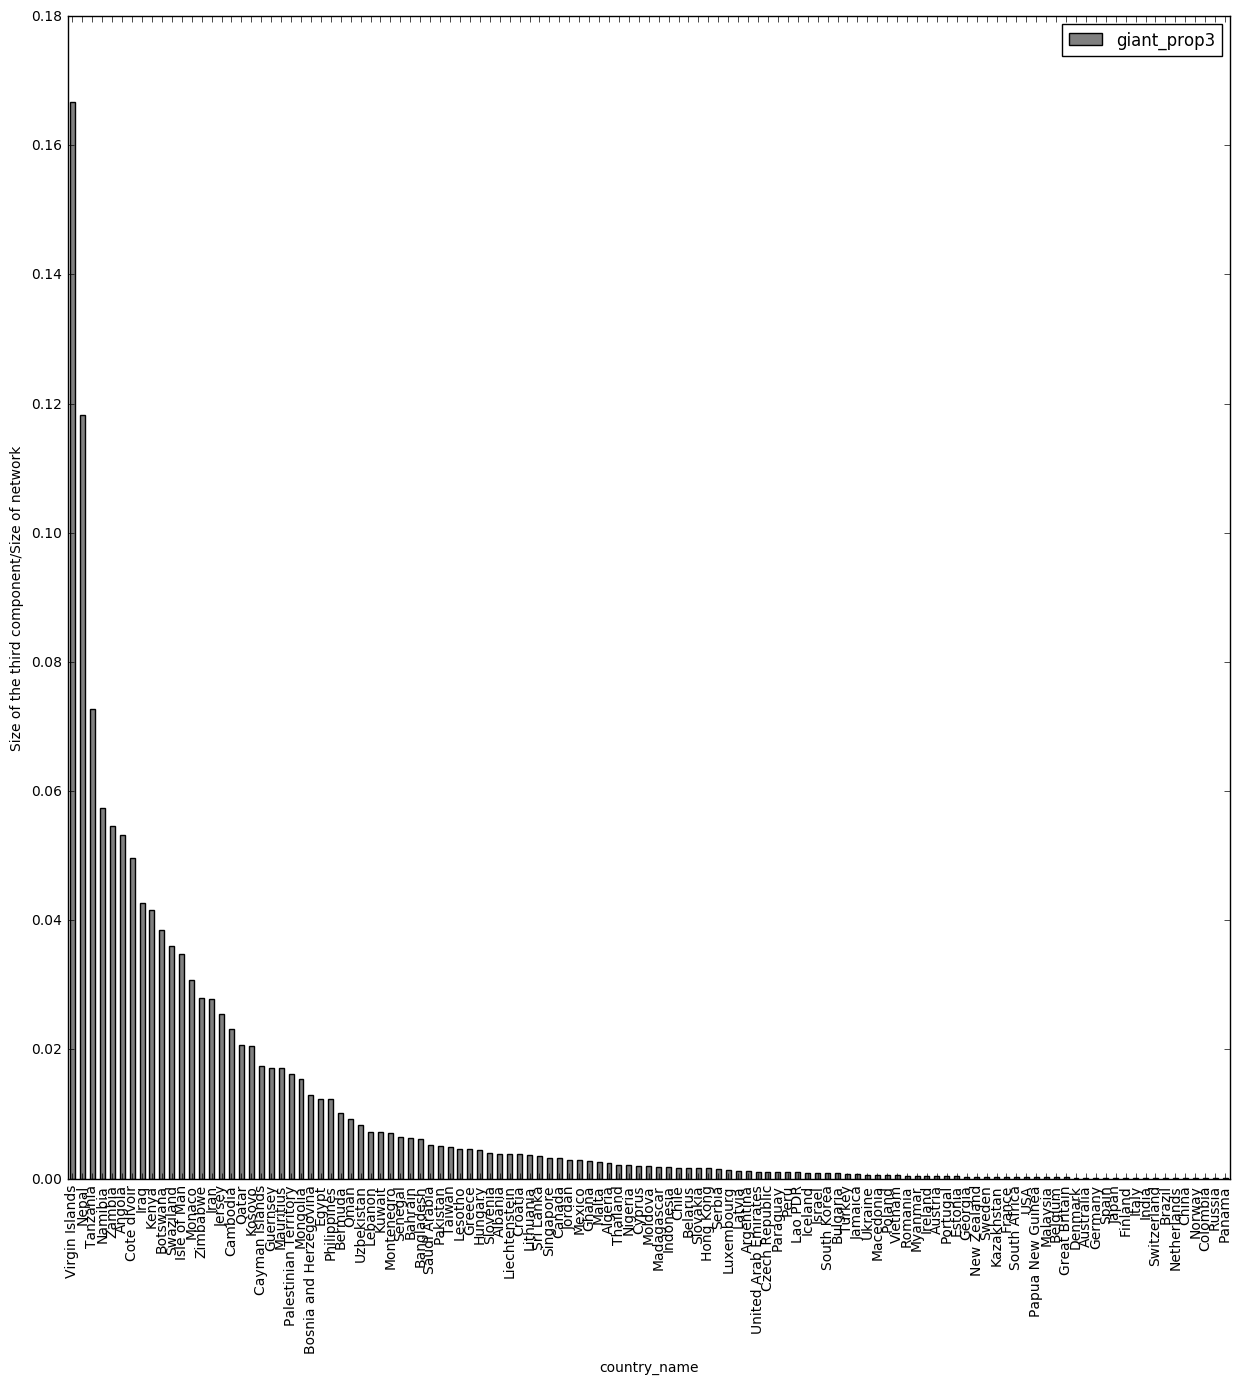

In [290]:
# Size of the third
stat['giant_prop3'] = stat['size_3comp'] / stat['no_nodes']
stat.sort_values('giant_prop3', ascending=False).plot(kind='bar',x='country_name', y= 'giant_prop3', color = 'grey', figsize=(15,15))
plt.ylabel('Size of the third component/Size of network')

In [ ]:
# size of the second comp is relatively large only for small countries
# but for large and eu countries it's very low = 0.1-0.2
# it's ok to take only a giant component

# Take giant components

In [332]:
AEC = max(nx.connected_component_subgraphs(AEG), key=len)

In [349]:
# List of finat component graphs
giant = (
AEC,
ALC,
AOC,
ARC,
ATC,
AUC,
BAC,
BDC,
BEC,
BGC,
BHC,
BMC,
BRC,
BWC,
BYC,
CAC,
CHC,
CIC,
CLC,
CNC,
COC,
CYC,
CZC,
DEC,
DKC,
DZC,
EEC,
EGC,
ESC,
FIC,
FRC,
GBC,
GEC,
GGC,
GHC,
GRC,
HKC,
HRC,
HUC,
IDC,
IEC,
ILC,
IMC,
INC,
IQC,
IRC,
ISC,
ITC,
JEC,
JMC,
JOC,
JPC,
KEC,
KHC,
KRC,
KVC,
KWC,
KYC,
KZC,
LAC,
LBC,
LIC,
LKC,
LSC,
LTC,
LUC,
LVC,
MCC,
MDC,
MEC,
MGC,
MKC,
MMC,
MNC,
MTC,
MUC,
MXC,
MYC,
NAC,
NGC,
NLC,
NOC,
NPC,
NZC,
OMC,
PAC,
PEC,
PGC,
PHC,
PKC,
PLC,
PSC,
PTC,
PYC,
QAC,
ROC,
RSC,
RUC,
SAC,
SEC,
SGC,
SIC,
SKC,
SNC,
SZC,
THC,
TRC,
TWC,
TZC,
UAC,
USC,
UZC,
VGC,
VNC,
ZAC,
ZMC,
ZWG)

In [350]:
# No of edges
for i in (giant):
    print(nx.number_of_edges(i))

1175
128
31
9950
62510
373815
207
1054
231599
25621
979
2984
121400
83
25
5323
315478
13
3653
491581
246174
253
26232
387556
159741
7918
74482
619
287288
296019
94944
1116260
8
214
8123
4944
18000
1370
4261
7130
123446
3938
62
461662
106
142
14930
404133
28
35095
5211
8433
182
13
15807
6
5320
954
4008
4
206
5442
3562
4001
136
30207
5908
18
253
274
3575
31
48932
29
12694
850
1723
263829
69
885
148182
712665
26
73786
686
757807
10116
141888
1434
3027
3820
286
102085
25753
640
7116
3035
30976
2146
116507
7426
958
6965
40
81
6055
34816
979
38
21
111417
8
6
7843
138713
105
580


In [351]:
# No of BvD and UCI
for i in (giant):
    BvD_nodes = set(n for n, d in i.nodes(data=True) if d['bipartite']==0)
    UCI_nodes = set(i) - BvD_nodes
    print (str(len(BvD_nodes)), str(len(UCI_nodes)))

520 421
70 44
16 7
4525 3167
26065 19000
180871 108025
102 83
237 414
84973 78960
14638 8442
344 351
759 1257
58584 37687
34 38
9 12
1544 2106
125515 102558
7 6
1270 1339
231125 166753
104954 82678
103 98
14354 8815
156333 120455
75964 46467
3677 2837
39375 26081
226 253
128394 91600
130368 104069
38752 31838
458540 365258
5 4
94 69
4151 2749
2266 1572
5213 6182
548 485
1623 1678
2731 2715
48049 37419
1660 1445
27 24
183302 144961
38 47
74 61
7385 4802
165740 137477
3 10
15278 10937
2169 1739
3454 3691
73 79
3 6
5351 6933
1 6
2015 1717
405 379
1791 1588
3 2
99 66
1915 1557
723 1003
1932 1434
71 66
11349 7279
3203 1890
8 8
103 98
129 114
1535 1086
18 12
22111 13498
3 11
5536 3401
178 273
525 647
106268 76864
26 32
362 364
48577 41320
333856 240627
13 13
34031 21554
199 269
261838 153678
4565 2953
45765 33192
241 533
712 1043
1944 1344
59 116
43198 32692
11289 9057
244 207
3494 2662
1515 1194
11254 10189
819 716
50416 37469
2215 2501
449 389
3884 2143
22 18
33 35
2984 2104
12821 10036
40

In [514]:
#top_nodes = set(n for n,d in LTC.nodes(data=True) if d['bipartite']==0)
#bottom_nodes = set(LTC) - top_nodes

In [515]:
#len(top_nodes)

71

In [518]:
#top_nodes

{'LT110087517',
 'LT120938642',
 'LT121304349_GUO:LT126180446:LT220152850:LT302890482',
 'LT121480450',
 'LT123125918',
 'LT123819458',
 'LT123930088',
 'LT132751369',
 'LT133393277',
 'LT133963745',
 'LT140089260',
 'LT144133366',
 'LT151104226',
 'LT152447391',
 'LT152812840',
 'LT157531950',
 'LT157544798',
 'LT158275315',
 'LT159702357',
 'LT163994426',
 'LT164702145',
 'LT167524751',
 'LT169236961',
 'LT170639781',
 'LT171265176',
 'LT171283765',
 'LT176523470',
 'LT177059215',
 'LT179249836',
 'LT182743364',
 'LT183633981',
 'LT185304657',
 'LT186496541',
 'LT187920473',
 'LT188710061',
 'LT188724424',
 'LT190742148',
 'LT191592776',
 'LT193290851',
 'LT195431457',
 'LT195551983',
 'LT221487620',
 'LT256564350',
 'LT273073670',
 'LT295758520',
 'LT300051414',
 'LT300851616',
 'LT301135783',
 'LT301733282',
 'LT302305683',
 'LT302469405',
 'LT302627894',
 'LT302718148',
 'LT302781878',
 'LT302899225',
 'LT303122222',
 'LT303197488',
 'NA_GUO:LT110687743:LT132278261',
 'NA_GUO:LT12

## Clustering

### Average bipartite clustering coefficient

In [352]:
# Clustering separately: firms
for i in giant:
    BvD_nodes = set(n for n, d in i.nodes(data=True) if d['bipartite']==0)
    UCI_nodes = set(i) - BvD_nodes
    print (nx.bipartite.average_clustering(i,BvD_nodes))

0.3377423413765564
0.35812706940640626
0.44219114219114225
0.35255030323449543
0.343312134560578
0.3859141910642977
0.38664601657161174
0.18307333428515574
0.278767966840157
0.4000073448131929
0.2556614752780199
0.26146132007033984
0.35095785275851776
0.29306239162331604
0.39584362139917695
0.30424501206004256
0.29898482463939224
0.3841269841269841
0.2697934753416093
0.3481762990806004
0.29395404707320444
0.23058785355894798
0.40374011131025234
0.349009789609323
0.356306043734094
0.34085548577308966
0.3547783831771556
0.2952135746035817
0.3481577623467922
0.3232953669552621
0.31715416767771043
0.33334418793622517
0.3694444444444444
0.33373357617278576
0.38008092160871115
0.35318985765299
0.2912874348749251
0.3308341350102807
0.2967058208171789
0.28567584076498453
0.34121929617941515
0.330905942297248
0.33670581104994685
0.3215873623294743
0.3017306286549708
0.34727503013217303
0.36199131847526933
0.31285501858394443
0.8666666666666667
0.32653900762433963
0.3177055326171288
0.2481189561

In [354]:
# Clustering separately: inds
for i in giant:
    BvD_nodes = set(n for n, d in i.nodes(data=True) if d['bipartite']==0)
    UCI_nodes = set(i) - BvD_nodes
    print (nx.bipartite.average_clustering(i,UCI_nodes))

0.28373215646001315
0.22928705343478067
0.19432452468166753
0.2715398705189018
0.264250438431477
0.25863220673904136
0.3431810682088417
0.38466670736067604
0.27265173938371834
0.22947818733798306
0.33152621694642725
0.4854752045707669
0.2526144985392176
0.3717355889724311
0.5199652777777778
0.4266599757586597
0.26652402403386455
0.35300925925925924
0.3149169793262095
0.2726350508731895
0.25938090274600684
0.2601171104813491
0.2524275835264817
0.28708008788704925
0.25067459573700857
0.2752257966763053
0.2401757899266474
0.3621932455277342
0.27566224094409414
0.2783731913559732
0.2732717408696008
0.30427919359200634
0.3333333333333333
0.2545072313559201
0.26418186236117425
0.2591295412520256
0.407614384336751
0.3056926274000676
0.3605513845564561
0.3164908236131409
0.3089482984913944
0.302078001356848
0.3119502815856983
0.2860249452544179
0.3786776708319262
0.29525459513164437
0.2564215532432456
0.29150207089011393
0.8666666666666665
0.25402471849956965
0.2605174070563379
0.3436610168946

In [355]:
# Clustering for both f and ind
for i in giant:
    print (nx.bipartite.average_clustering(i))

0.31357837979327774
0.3083993439436736
0.3667534759926064
0.31919616381558075
0.30997867785465477
0.33832046752106926
0.36714552622507174
0.31127557154055546
0.27582202355869834
0.3376326850469096
0.2939758987681083
0.40113664388831505
0.3124595927377095
0.33458435689090454
0.4667702821869489
0.37487676919683455
0.2843881174951771
0.3697649572649572
0.2929519160604209
0.31651651954430776
0.2787197670640013
0.2449852027051935
0.3461709485317988
0.322058685439488
0.3162150823429379
0.3122722146696839
0.30911488044911695
0.330591146093792
0.31797244019941306
0.3033539503169478
0.2973620058316003
0.320457264559442
0.353395061728395
0.30019604370429687
0.33390606452588756
0.3146638499973583
0.35439697428458095
0.31903003898806054
0.32916048787398416
0.30103806596379795
0.3270906344289404
0.3174900406357738
0.32505615012559463
0.3058829925356655
0.3442778166822283
0.32376950024304524
0.32039404165208313
0.30317370391455106
0.8666666666666665
0.2962857640554822
0.29225769475883306
0.297474553

In [356]:
# Robins-Alexander
for i in giant:
    print (nx.bipartite.robins_alexander_clustering(i))

0.1283720930232558
0.11023622047244094
0.32786885245901637
0.24305174720863404
0.1992793461230321
0.2372984165044986
0.24667472793228537
0.21325005576622796
0.12730422463868699
0.13600317517140478
0.403030705835438
0.5434744858723425
0.2738985581729528
0.14285714285714285
0.4489795918367347
0.5303903446776123
0.17144015233258056
0.2
0.22249251497005987
0.210327251249206
0.18087461553700332
0.14039125431530494
0.1619266772413485
0.3151914442049026
0.16543602030356547
0.2862670644607178
0.0984725933737901
0.2371452655240236
0.23073537239185182
0.1522243158241281
0.1794256782094224
0.24997589089963324
0.0
0.17932296431838976
0.23129740160660595
0.16178808108967305
0.2834477109786223
0.2739573679332715
0.2935982983187156
0.17636780605001637
0.3227790367297064
0.21320039608017208
0.189873417721519
0.17482746412878236
0.23834196891191708
0.06369426751592357
0.1539704784214241
0.21828526895476788
0.9216589861751152
0.15743270406195903
0.16317950913797466
0.22713761822042078
0.2163833075734157

In [357]:
# Density
for i in (giant):
    BvD_nodes = set(n for n, d in i.nodes(data=True) if d['bipartite']==0)
    UCI_nodes = set(i) - BvD_nodes
    print (nx.bipartite.density(i, BvD_nodes))
    

0.005367257445642244
0.04155844155844156
0.2767857142857143
0.0006943148176900251
0.0001262229042777671
1.913213820980588e-05
0.02445074415308292
0.010742167594121364
3.4518235609520924e-05
0.00020733326451626602
0.00810806334062148
0.0031276760549355754
5.498548979123091e-05
0.06424148606811146
0.23148148148148148
0.0016370080057472112
2.4507776182646616e-05
0.30952380952380953
0.0021481538108707285
1.275482512605793e-05
2.836960081802102e-05
0.0250643946899148
0.00020731758688082423
2.0580644499087602e-05
4.5254725948302594e-05
0.0007590362750893938
7.252813731092939e-05
0.010825842107104132
2.442740219737104e-05
2.1818616191979006e-05
7.695336667477785e-05
6.664819607397414e-06
0.4
0.03299414122725871
0.000711850804203872
0.0013879250520471894
0.0005585419275393628
0.005154639175257732
0.0015645918291661068
0.0009616078406778999
6.865947709291312e-05
0.0016417225997415266
0.09567901234567901
1.7374237298438562e-05
0.0593505039193729
0.03145768719539211
0.0004210049017603532
1.773645

In [358]:
# Assortativity
for i in giant:
    print (nx.degree_assortativity_coefficient(i))

-0.129879566087
-2.48811923067e-05
-0.36563876652
0.0293490272912
-0.0173611713117
-0.0468296469446
-0.164734594265
-0.308679211524
0.0879399722691
-0.0739291633684
0.139012269971
-0.206576364176
0.0221000291277
-0.233081827221
-0.286880100439
-0.151679965768
-0.00507412444527
0.0579710144928
0.0193549090531
-0.00125726298872
0.143205255556
0.100073928564
-0.0928578996558
0.000578417321617
-0.0266829814519
0.15044730439
0.0770991729579
-0.188215125386
0.025443685883
0.0565642575645
0.0142567059514
-0.0121981112015
0.0
-0.137150175764
-0.0403684230659
-0.0713853319622
0.011975980944
0.105489166752
-0.0614071930275
-0.0103107363838
-0.0598813999289
-0.0451797447645
-0.0362116991643
0.0346802214433
-0.287729687364
0.0726594226759
-0.0355532876734
-0.0115867798768
-0.985508967811
0.0595431827256
0.0313125710972
-0.140944401956
-0.194953330829
-0.82280431433
-0.0762595843719
-1.0
0.187879987073
0.0446184122557
0.0662459619142
-0.333333333333
-0.1373497007
-0.0660863541408
-0.000367982418473

## Plots

In [2]:
# read for plots
stat2 = pd.read_csv("ntw_stat_giant.csv", header=0, sep=',', low_memory=False)
stat2.head()

country country.1          country_name  no_edges  no_nodes  firms  \
0      AE       AEG  United Arab Emirates      1175       941    520   
1      AL       ALG               Albania       128       114     70   
2      AO       AOG                Angola        31        23     16   
3      AR       ARG             Argentina      9950      7692   4525   
4      AT       ATG               Austria     62510     45065  26065   

   individuals   density  ave_clu_firms  ave_clu_inds  ave_clu_both  \
0          421  0.005367       0.337742      0.283732      0.313578   
1           44  0.041558       0.358127      0.229287      0.308399   
2            7  0.276786       0.442191      0.194325      0.366753   
3         3167  0.000694       0.352550      0.271540      0.319196   
4        19000  0.000126       0.343312      0.264250      0.309979   

   clu_robins_alexander  ave_degree    assort  
0              0.128372    2.497343 -0.129880  
1              0.110236    2.245614 -0.000025  
2              0.327869    2.695652 -0.365639  
3              0.243052    2.587103  0.029349  
4              0.199279    2.774215 -0.017361

(0, 1500000)

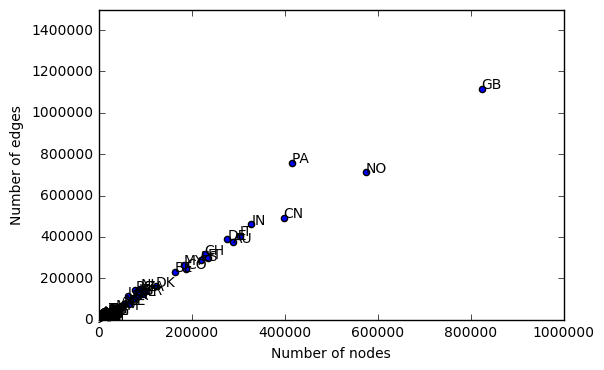

In [363]:
ax = stat2.plot.scatter(x='no_nodes',y='no_edges')
stat2[['no_nodes','no_edges','country']].apply(lambda x: ax.text(*x),axis=1)
plt.xlabel('Number of nodes')
plt.ylabel('Number of edges')
plt.xlim((0, 1000000))
plt.ylim((0, 1500000))

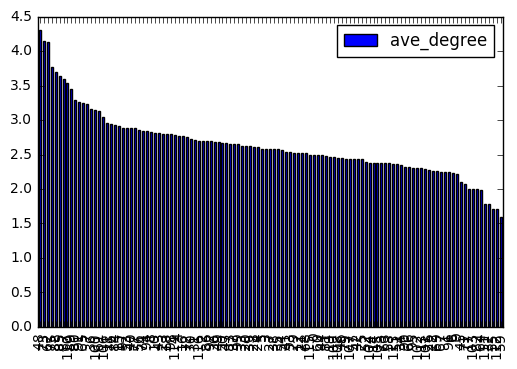

In [364]:
## Average degree

stat2.sort_values('ave_degree', ascending=False)[['country','ave_degree']].plot.bar(stacked=True)


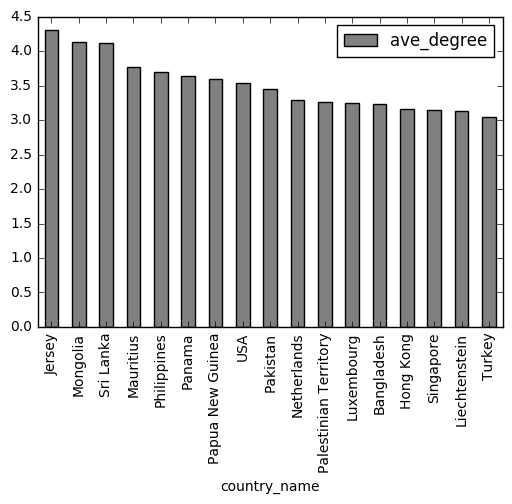

In [371]:
df2 = stat2.loc[stat2['ave_degree'] > 3.0]
df2.sort_values('ave_degree', ascending=False).plot(kind='bar',x='country_name', y= 'ave_degree', color = 'grey')

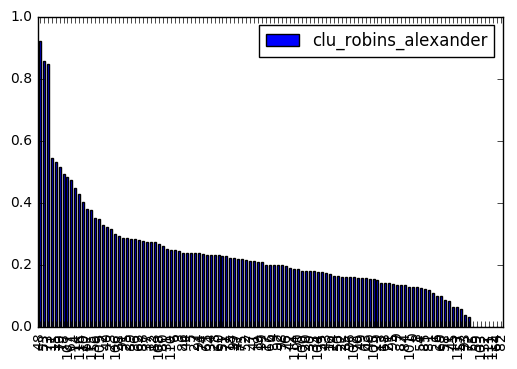

In [367]:
# Clu Robins-Alexander
stat2.sort_values('clu_robins_alexander', ascending=False)[['country','clu_robins_alexander']].plot.bar(stacked=True)

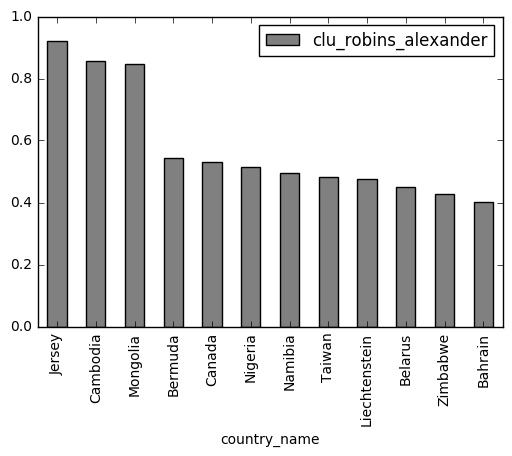

In [373]:
df6 = stat2.loc[stat2['clu_robins_alexander'] > 0.4]
df6.sort_values('clu_robins_alexander', ascending=False).plot(kind='bar',x='country_name', y= 'clu_robins_alexander', color = 'grey')

(0.0, 900000)

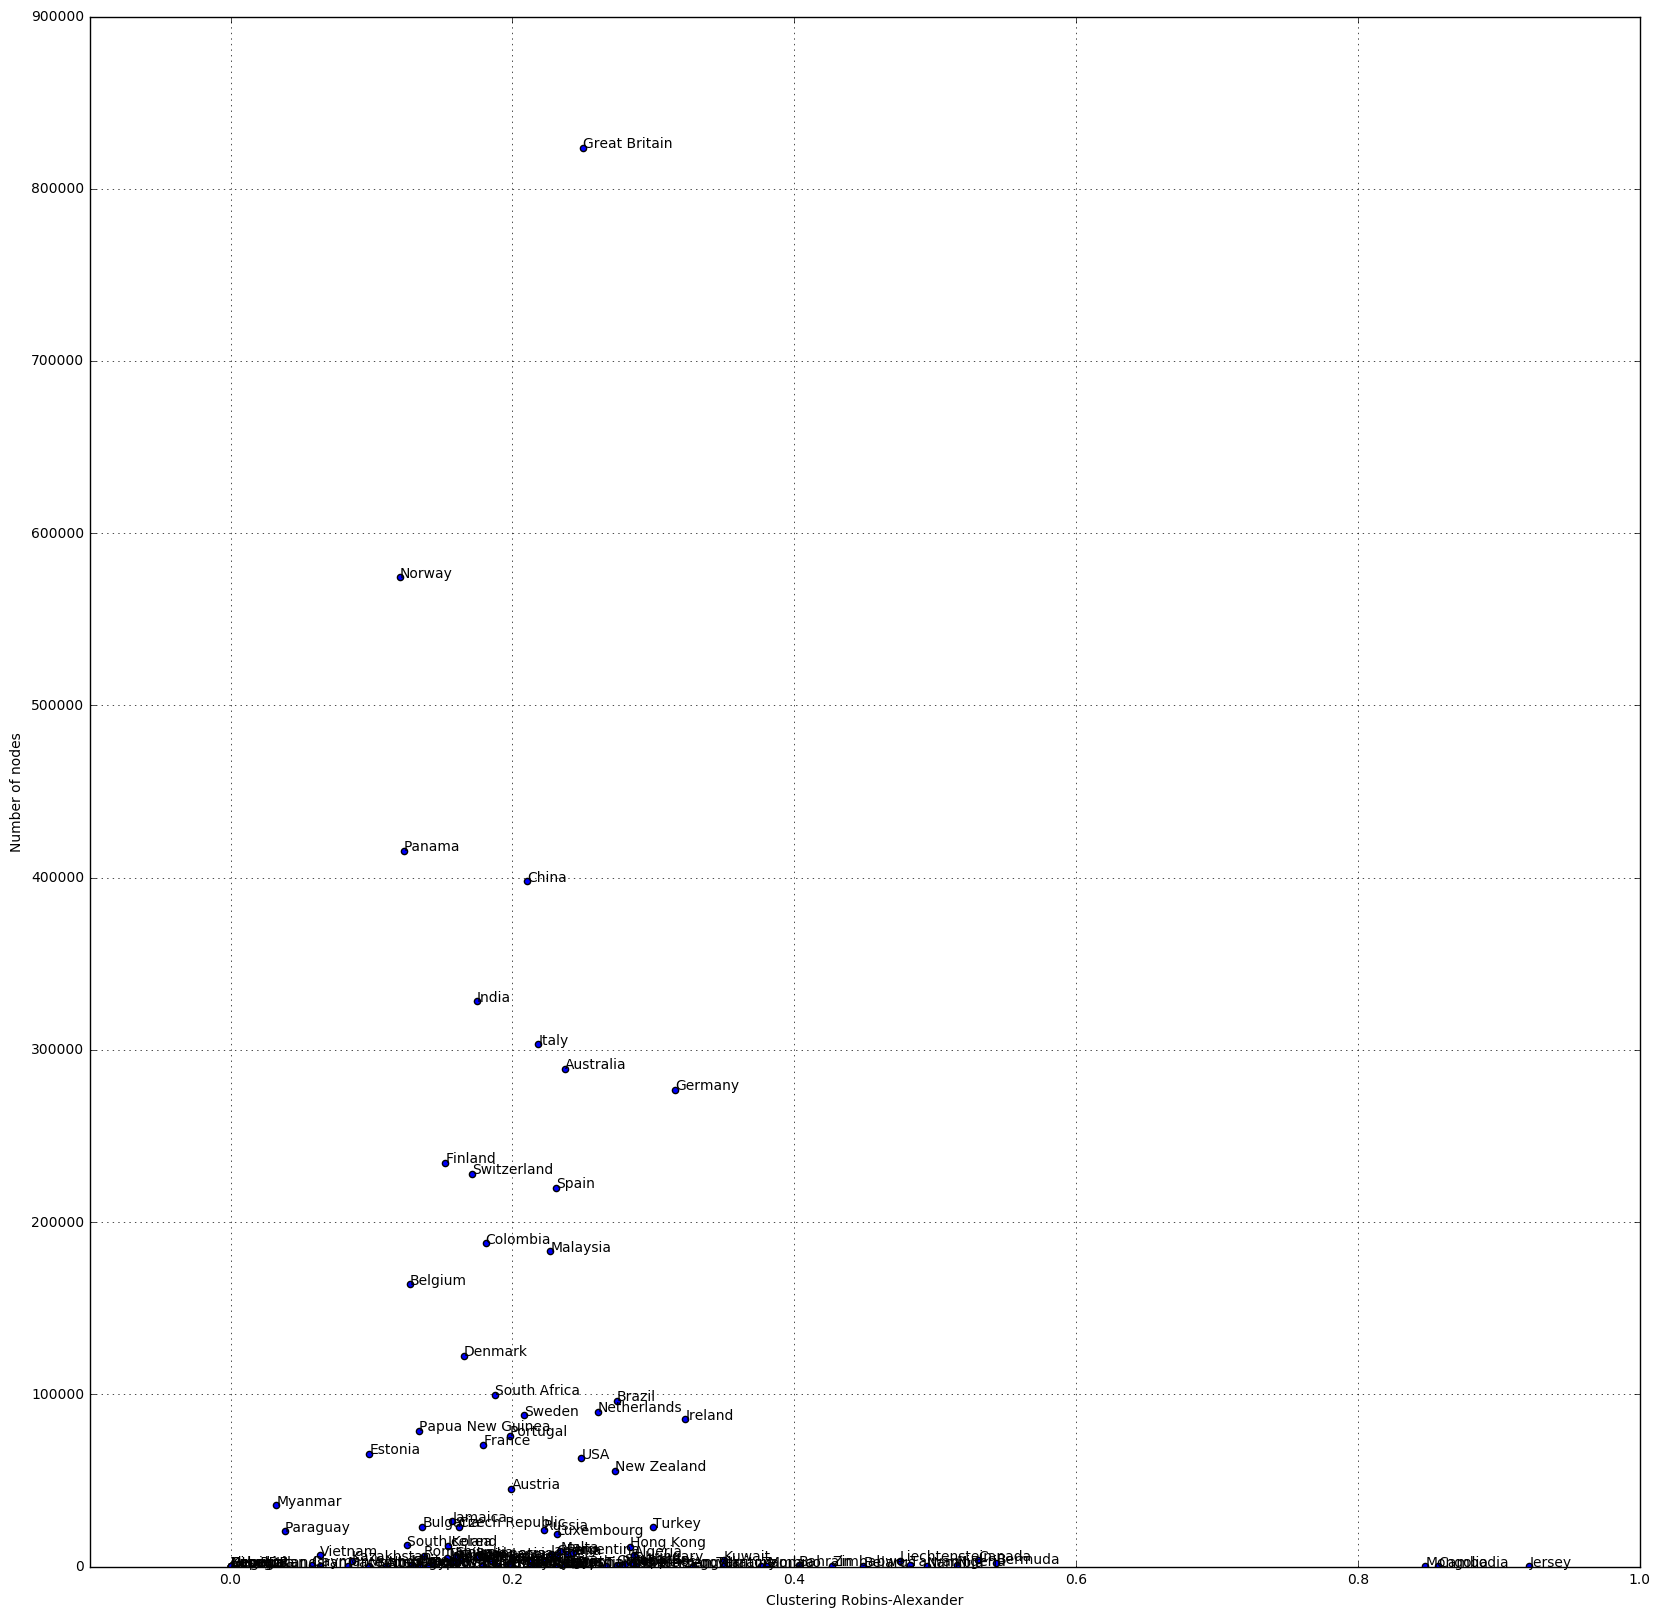

In [375]:

ax = stat2.plot.scatter(x='clu_robins_alexander',y='no_nodes', figsize=(20,20))
ax.grid(True)
stat2[['clu_robins_alexander','no_nodes','country_name']].apply(lambda x: ax.text(*x),axis=1)
plt.ylabel('Number of nodes')
plt.xlabel('Clustering Robins-Alexander')
plt.xlim((-0.1, 1.00))
plt.ylim((0.0, 900000))

(0.0, 900000)

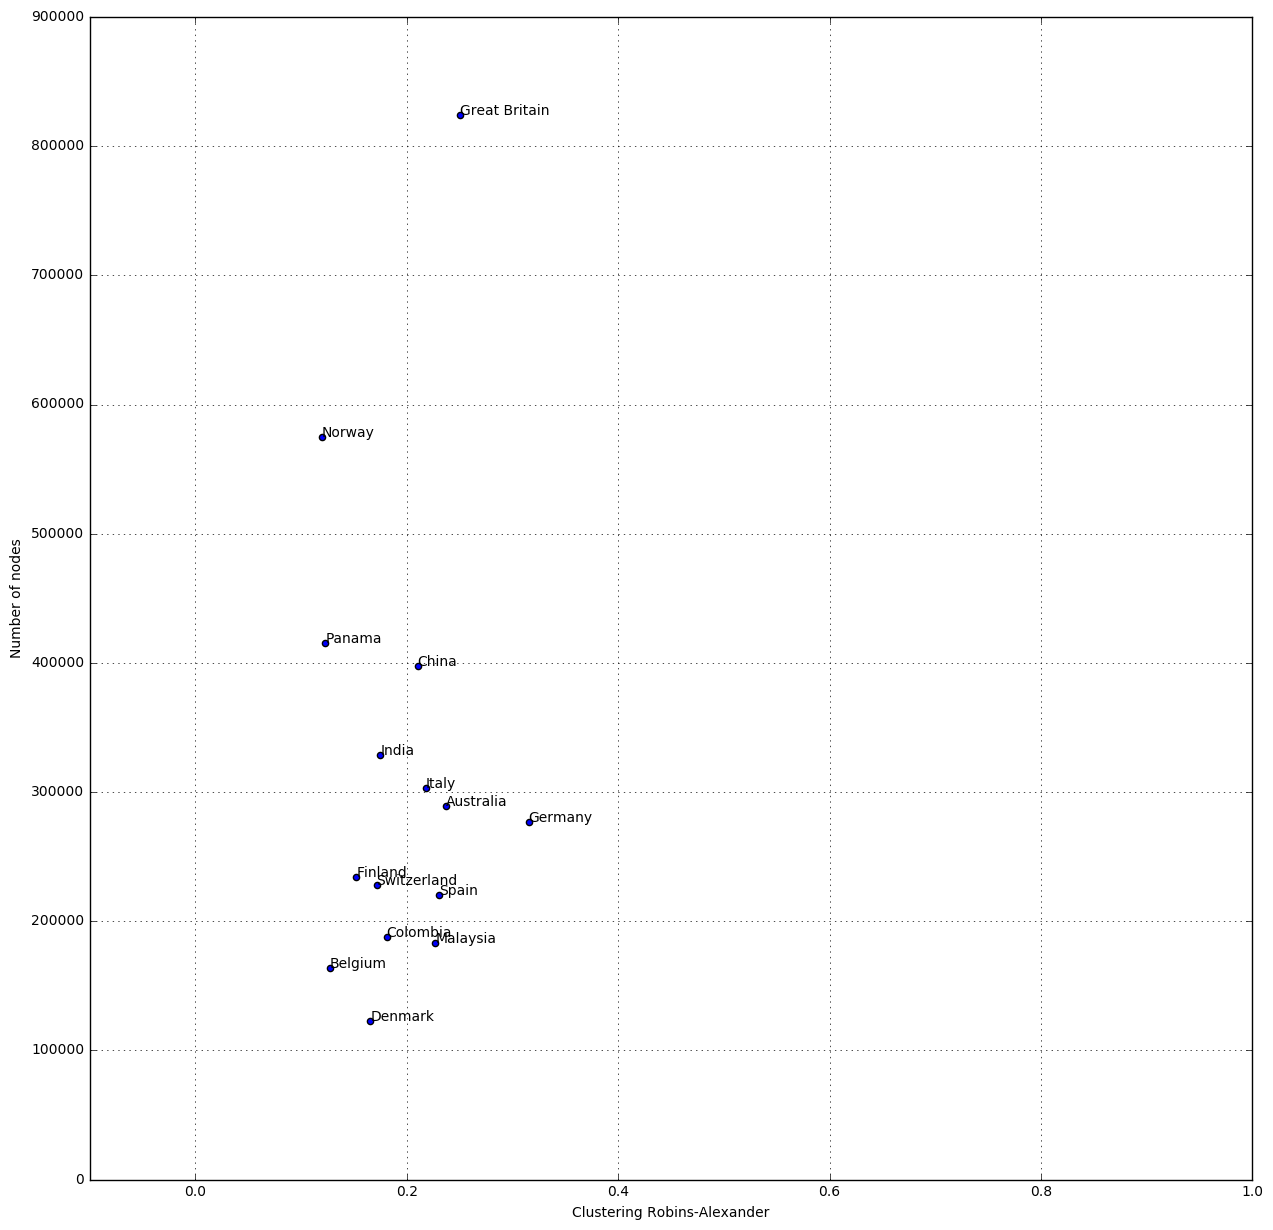

In [377]:
# Take only large networks
df7 = stat2.loc[stat2['no_nodes'] > 100000]
ax = df7.plot.scatter(x='clu_robins_alexander',y='no_nodes', figsize=(15,15))
ax.grid(True)
df7[['clu_robins_alexander','no_nodes','country_name']].apply(lambda x: ax.text(*x),axis=1)
plt.ylabel('Number of nodes')
plt.xlabel('Clustering Robins-Alexander')
plt.xlim((-0.1, 1.00))
plt.ylim((0.0, 900000))
# they are all the same

(0.0, 900000)

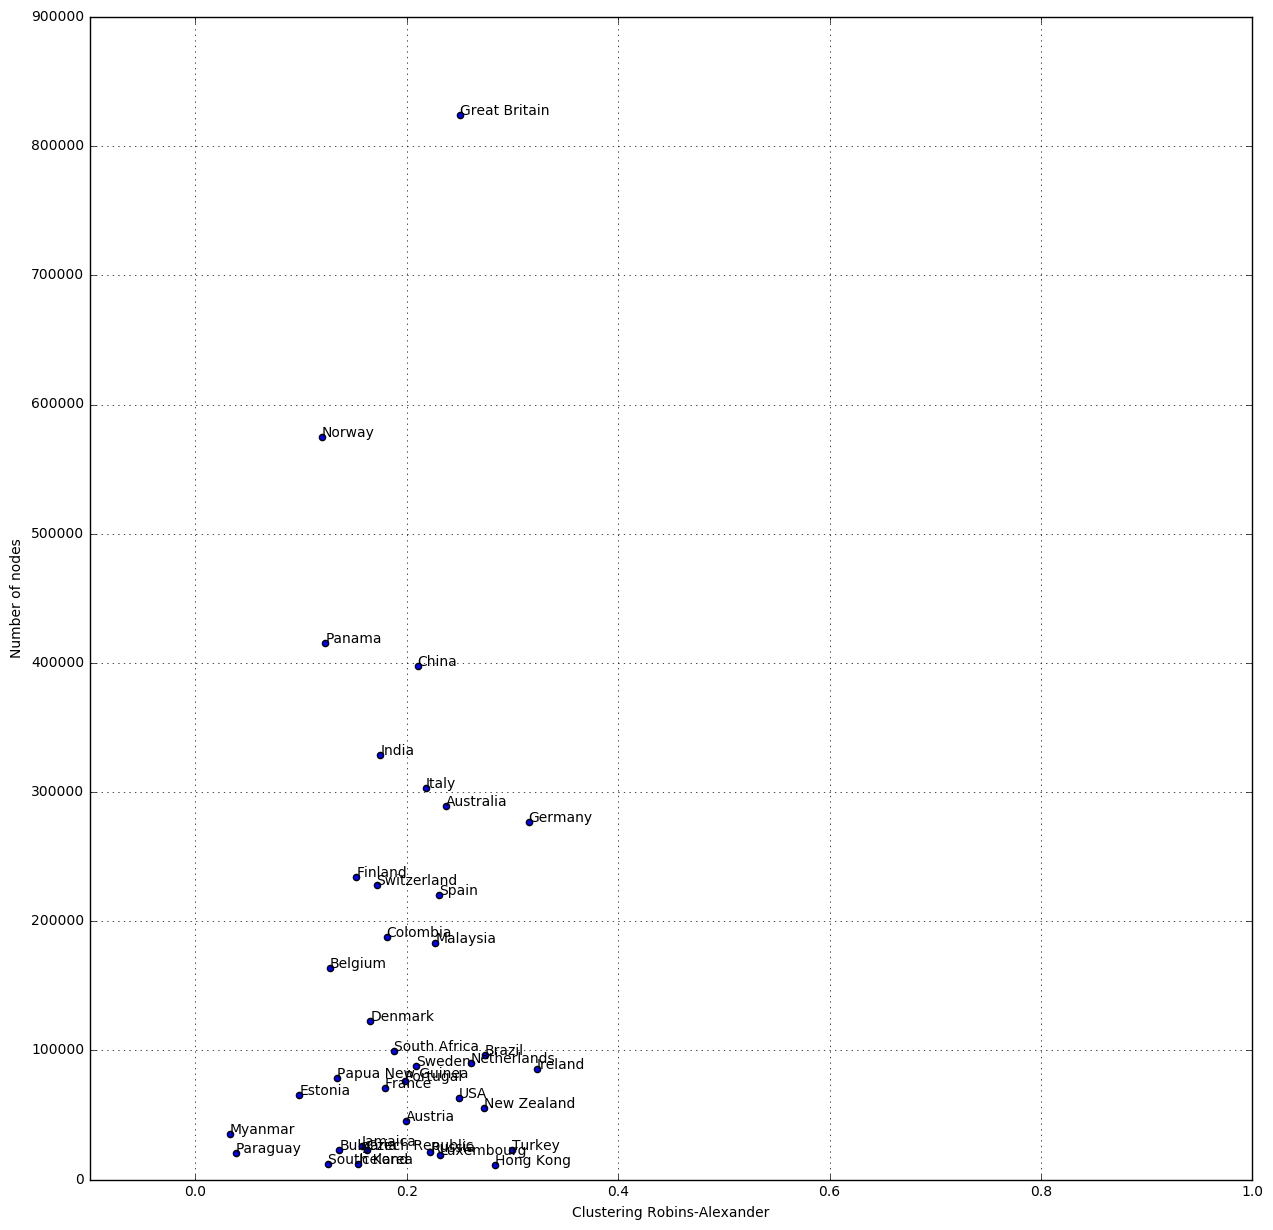

In [378]:
# Take only large networks
df7 = stat2.loc[stat2['no_nodes'] > 10000]
ax = df7.plot.scatter(x='clu_robins_alexander',y='no_nodes', figsize=(15,15))
ax.grid(True)
df7[['clu_robins_alexander','no_nodes','country_name']].apply(lambda x: ax.text(*x),axis=1)
plt.ylabel('Number of nodes')
plt.xlabel('Clustering Robins-Alexander')
plt.xlim((-0.1, 1.00))
plt.ylim((0.0, 900000))
# they are all the same

### Clustering average all graph

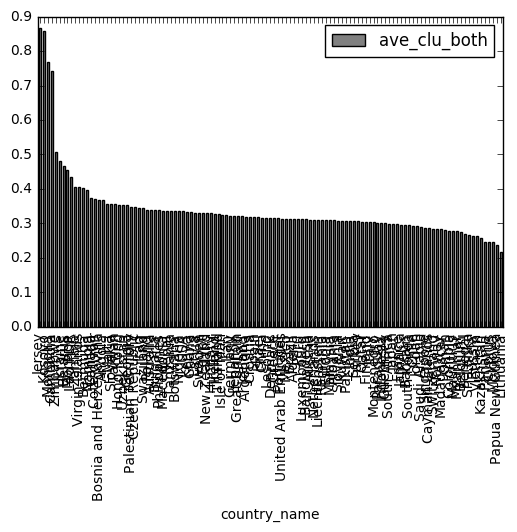

In [379]:
stat2.sort_values('ave_clu_both', ascending=False).plot(kind='bar',x='country_name', y= 'ave_clu_both', color = 'grey')

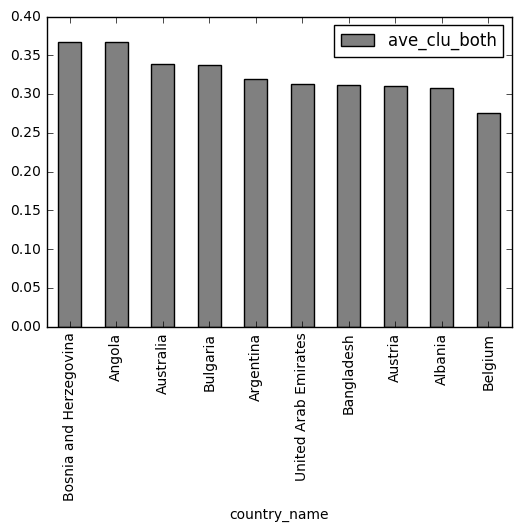

In [380]:
df6 = stat2.loc[stat['ave_clu_both'] > 0.4]
df6.sort_values('ave_clu_both', ascending=False).plot(kind='bar',x='country_name', y= 'ave_clu_both', color = 'grey')

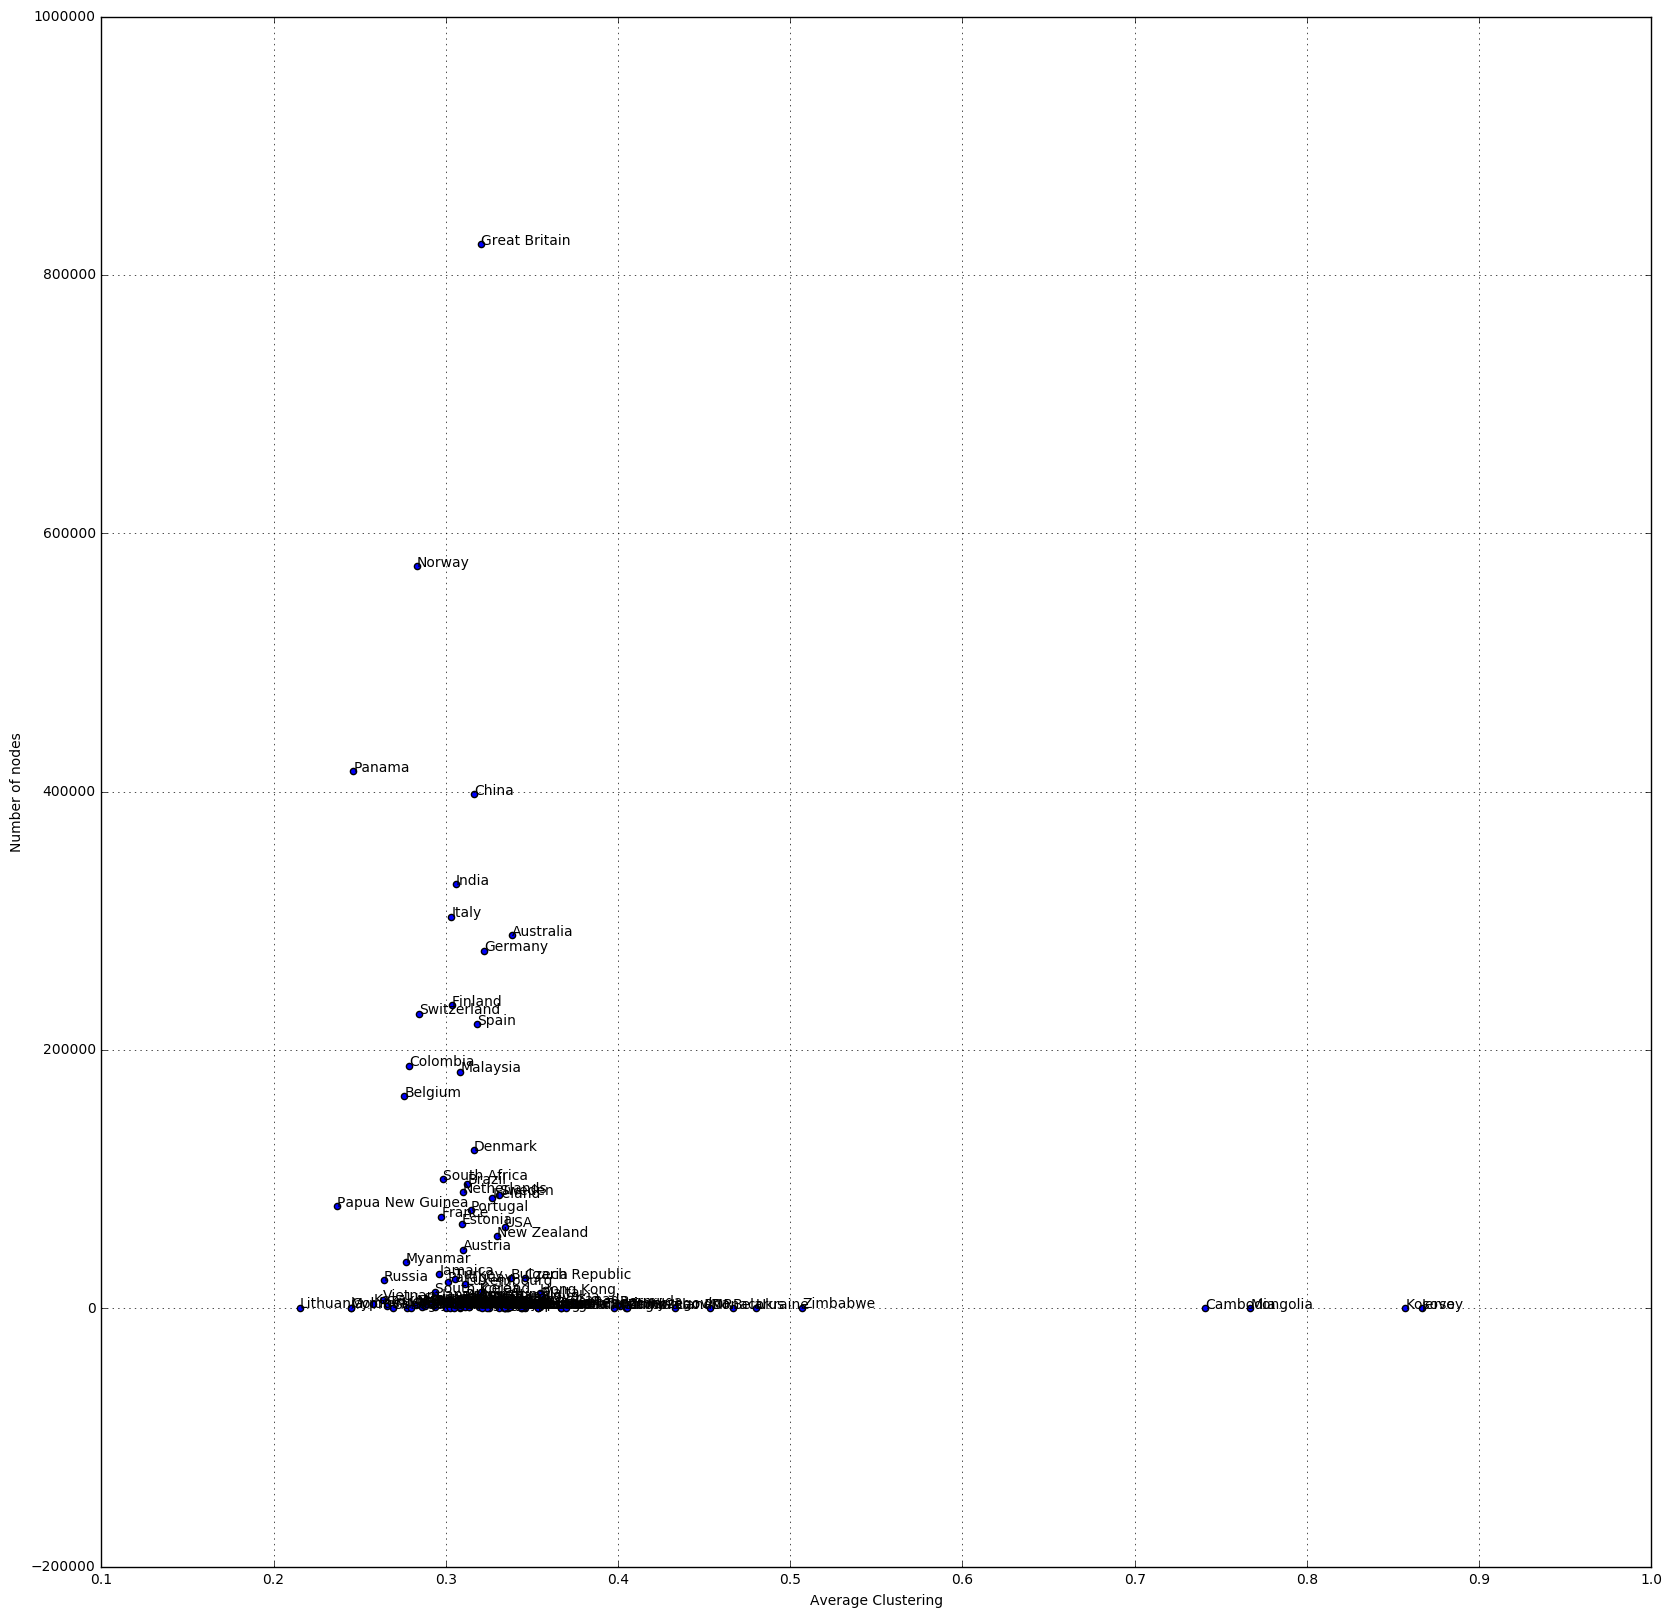

In [381]:
ax = stat2.plot.scatter(x='ave_clu_both',y='no_nodes', figsize=(20,20))
ax.grid(True)
stat2[['ave_clu_both','no_nodes','country_name']].apply(lambda x: ax.text(*x),axis=1)
plt.ylabel('Number of nodes')
plt.xlabel('Average Clustering')
#plt.xlim((-0.1, 1.00))
#plt.ylim((0.0, 900000))

(0.0, 900000)

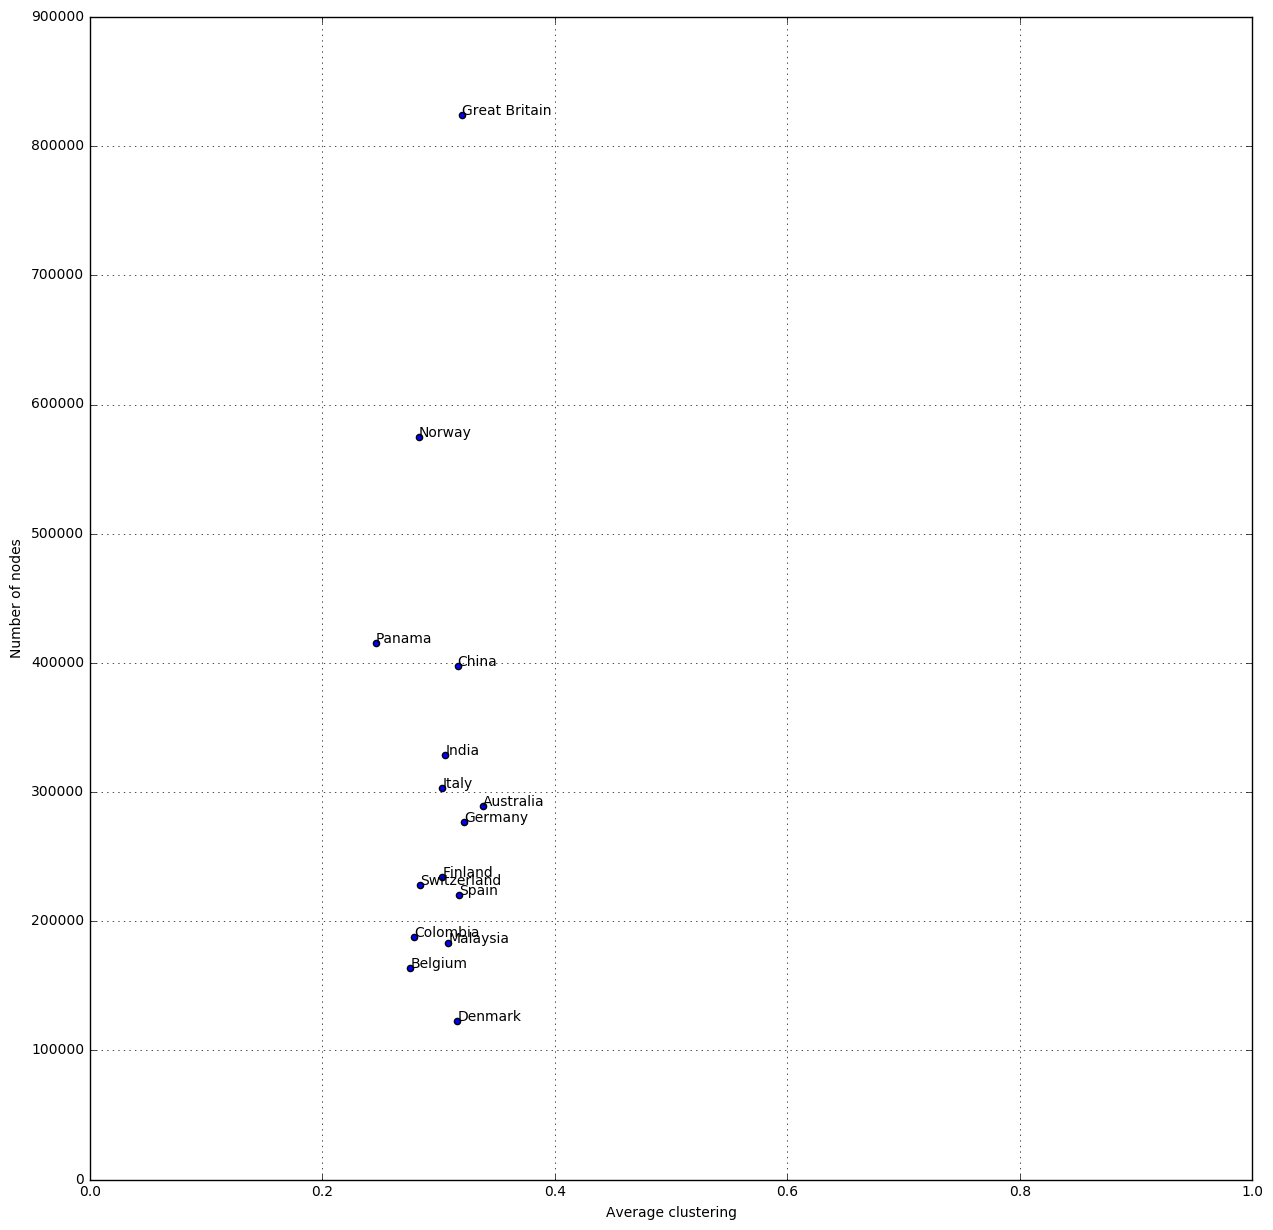

In [388]:
# Take only large networks
df7 = stat2.loc[stat2['no_nodes'] > 100000]
ax = df7.plot.scatter(x='ave_clu_both',y='no_nodes', figsize=(15,15))
ax.grid(True)
df7[['ave_clu_both','no_nodes','country_name']].apply(lambda x: ax.text(*x),axis=1)
plt.ylabel('Number of nodes')
plt.xlabel('Average clustering')
plt.xlim((0.0, 1.00))
plt.ylim((0.0, 900000))

(0.0, 900000)

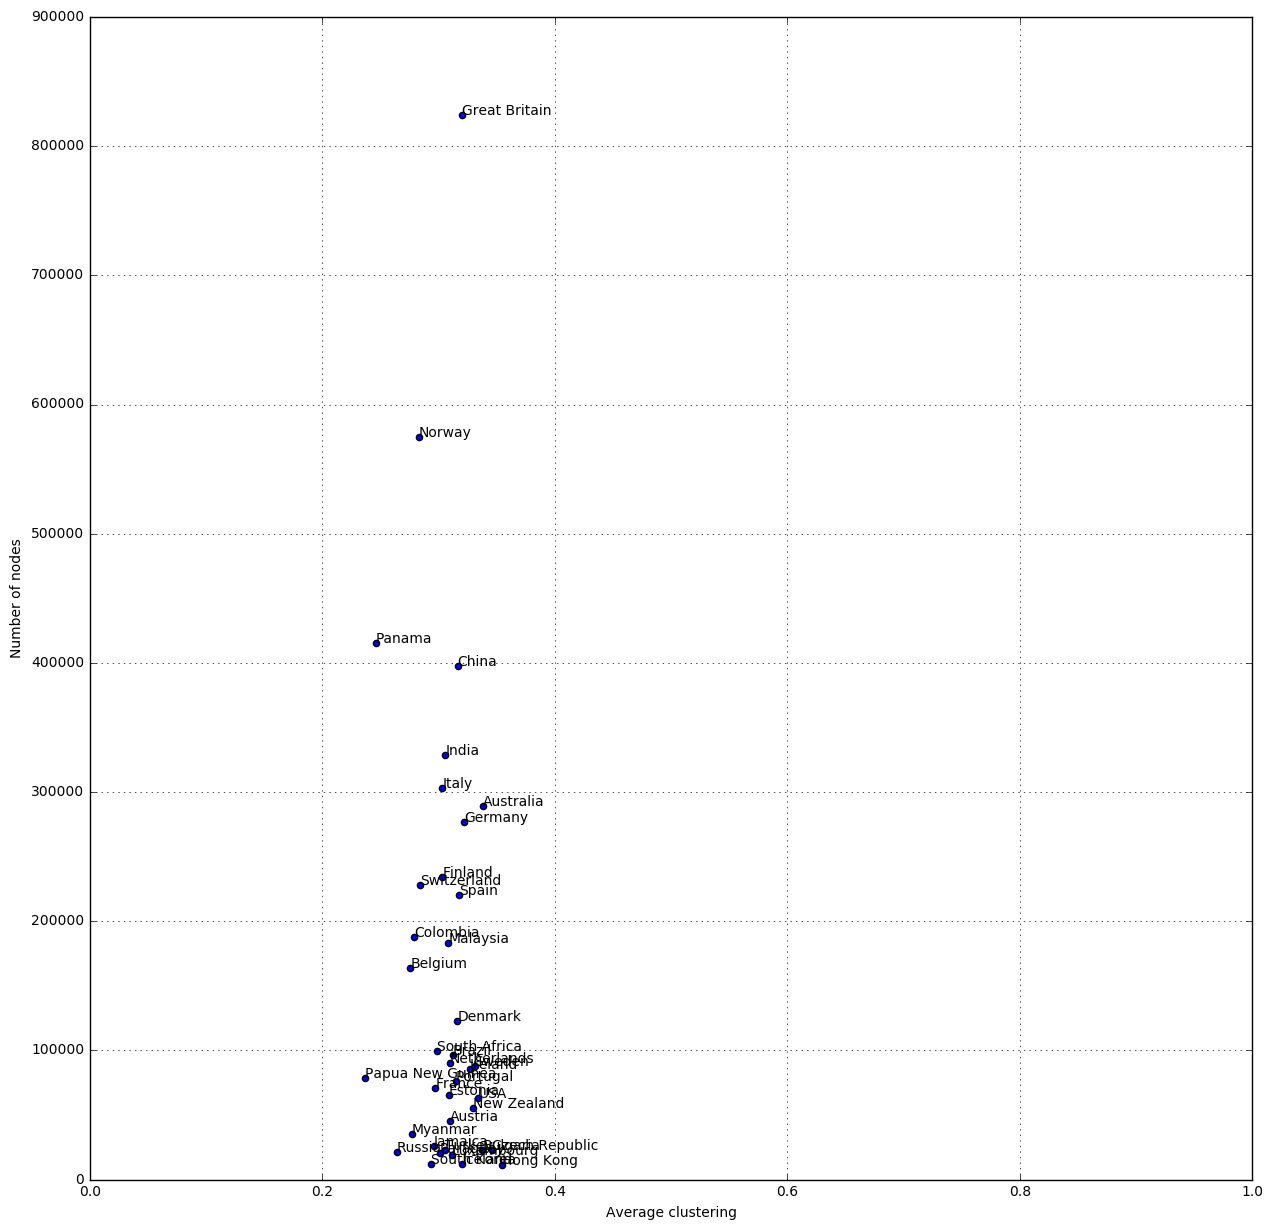

In [389]:
# Take only large networks
df7 = stat2.loc[stat2['no_nodes'] > 10000]
ax = df7.plot.scatter(x='ave_clu_both',y='no_nodes', figsize=(15,15))
ax.grid(True)
df7[['ave_clu_both','no_nodes','country_name']].apply(lambda x: ax.text(*x),axis=1)
plt.ylabel('Number of nodes')
plt.xlabel('Average clustering')
plt.xlim((0.0, 1.00))
plt.ylim((0.0, 900000))

### Correlate both clustering measures

(0.01, 1.0)

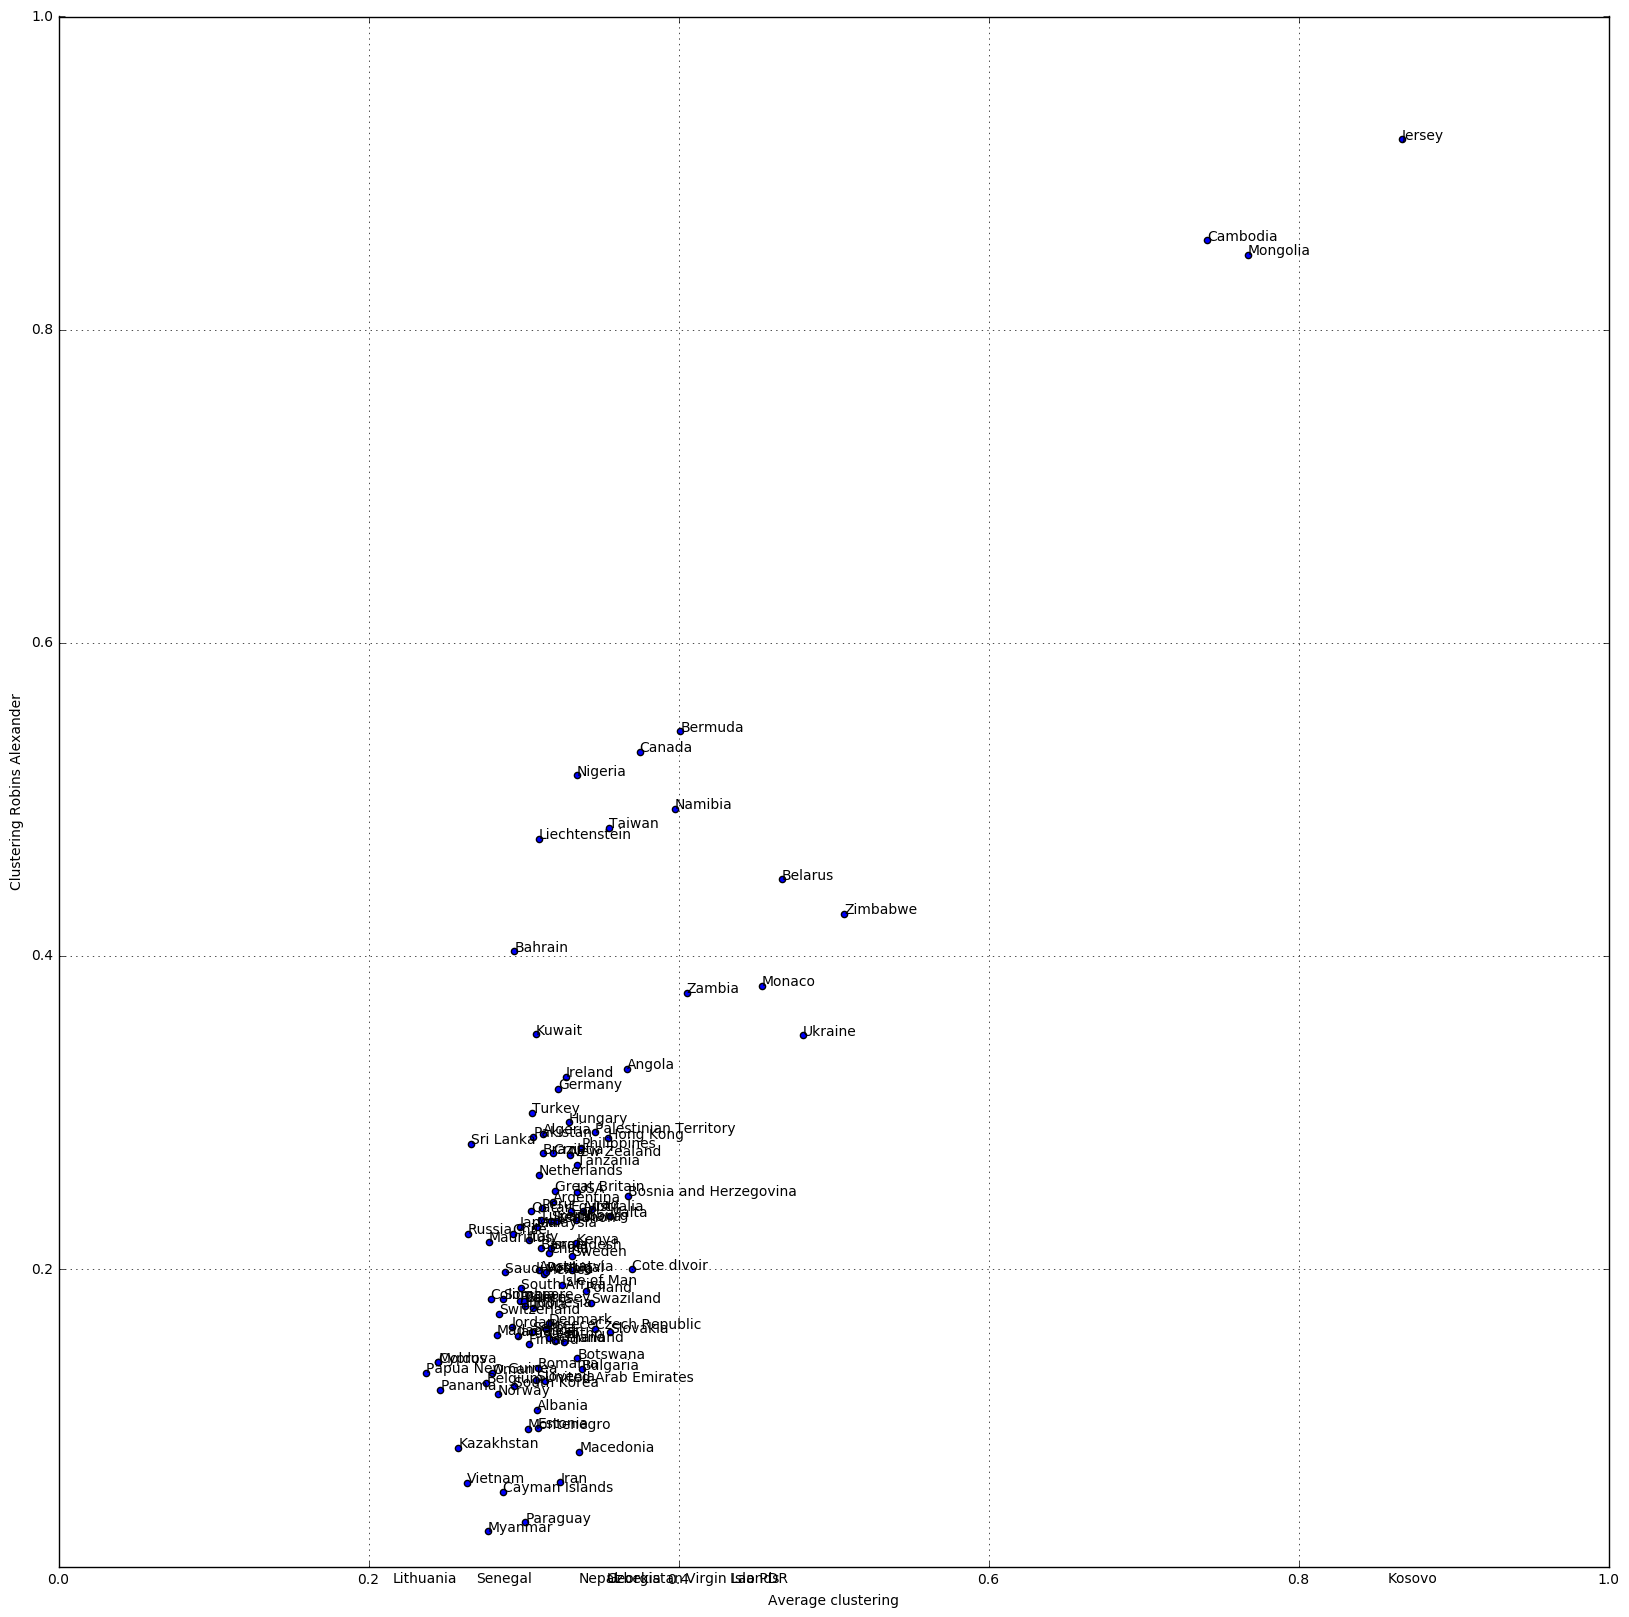

In [390]:
ax = stat2.plot.scatter(x='ave_clu_both',y='clu_robins_alexander', figsize=(20,20))
ax.grid(True)
stat2[['ave_clu_both','clu_robins_alexander','country_name']].apply(lambda x: ax.text(*x),axis=1)
plt.ylabel('Clustering Robins Alexander')
plt.xlabel('Average clustering')
plt.xlim((0.0, 1.00))
plt.ylim((0.01, 1.00))

### Clustering firms and inds

(-0.01, 1.0)

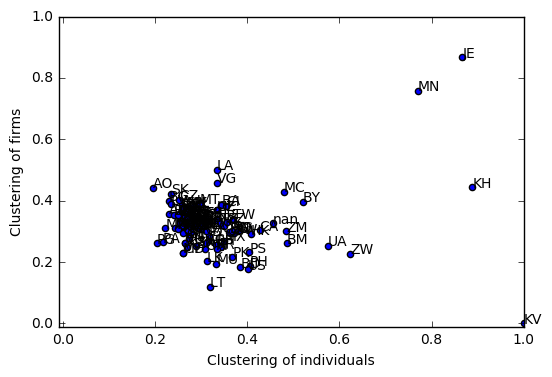

In [391]:
ax = stat2.plot.scatter(x='ave_clu_inds',y='ave_clu_firms')
stat2[['ave_clu_inds','ave_clu_firms','country']].apply(lambda x: ax.text(*x),axis=1)
plt.ylabel('Clustering of firms')
plt.xlabel('Clustering of individuals')
plt.xlim((-0.01, 1.0))
plt.ylim((-0.01, 1.00))

(0.0, 1.0)

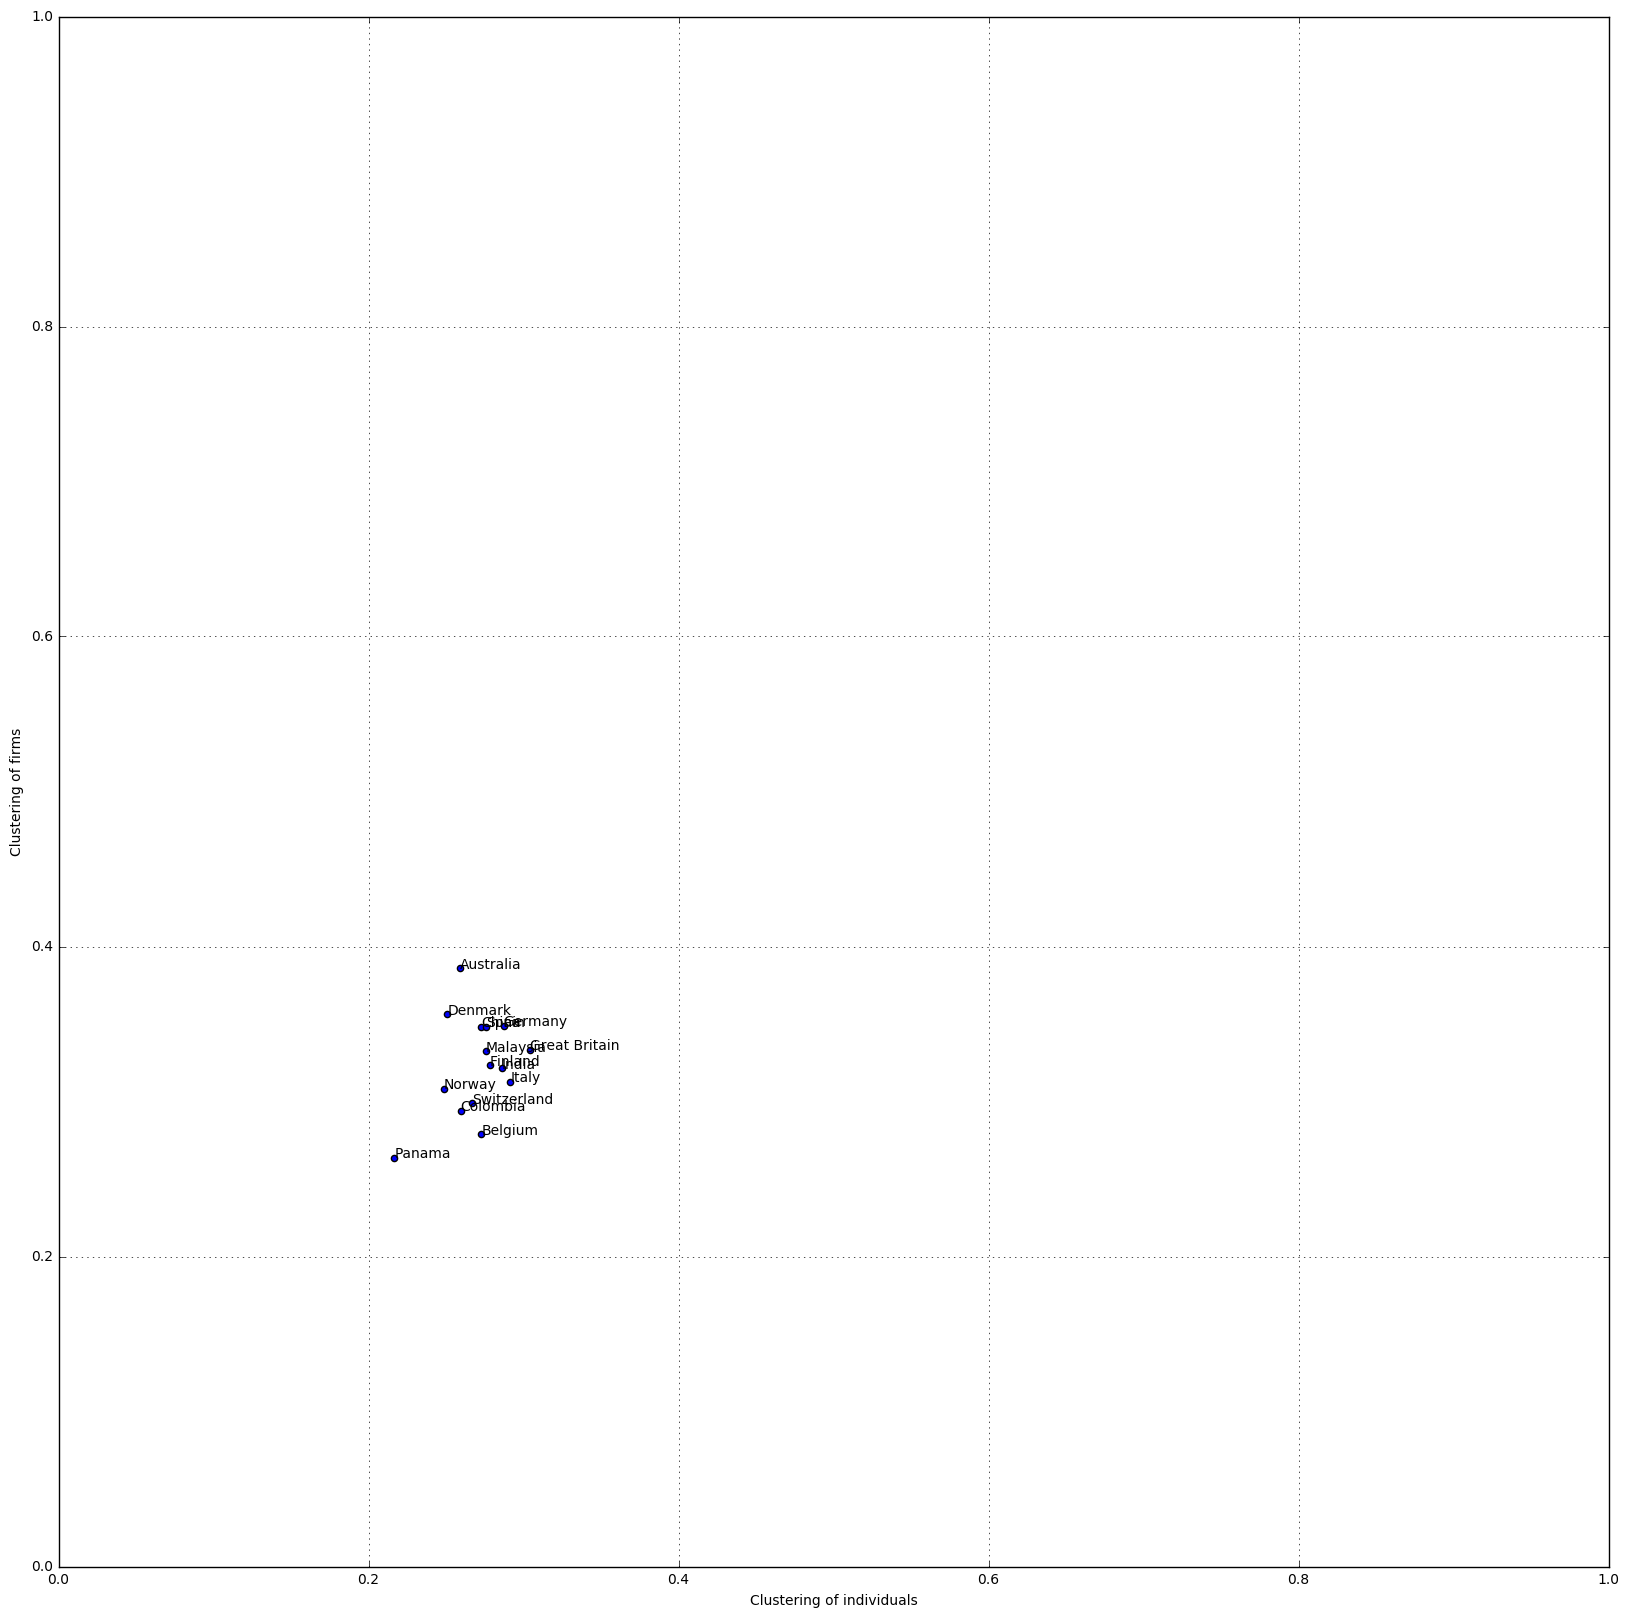

In [392]:
## Take the largest networks
df2 = stat2.loc[stat2['no_nodes'] > 100000]
ax = df2.plot.scatter(x='ave_clu_inds',y='ave_clu_firms', figsize=(20,20))
ax.grid(True)
df2[['ave_clu_inds','ave_clu_firms','country_name']].apply(lambda x: ax.text(*x),axis=1)
plt.ylabel('Clustering of firms')
plt.xlabel('Clustering of individuals')
plt.xlim((0.0, 1.00))
plt.ylim((0.0, 1.00))
# plt.savefig('clu_firms_inds.png')

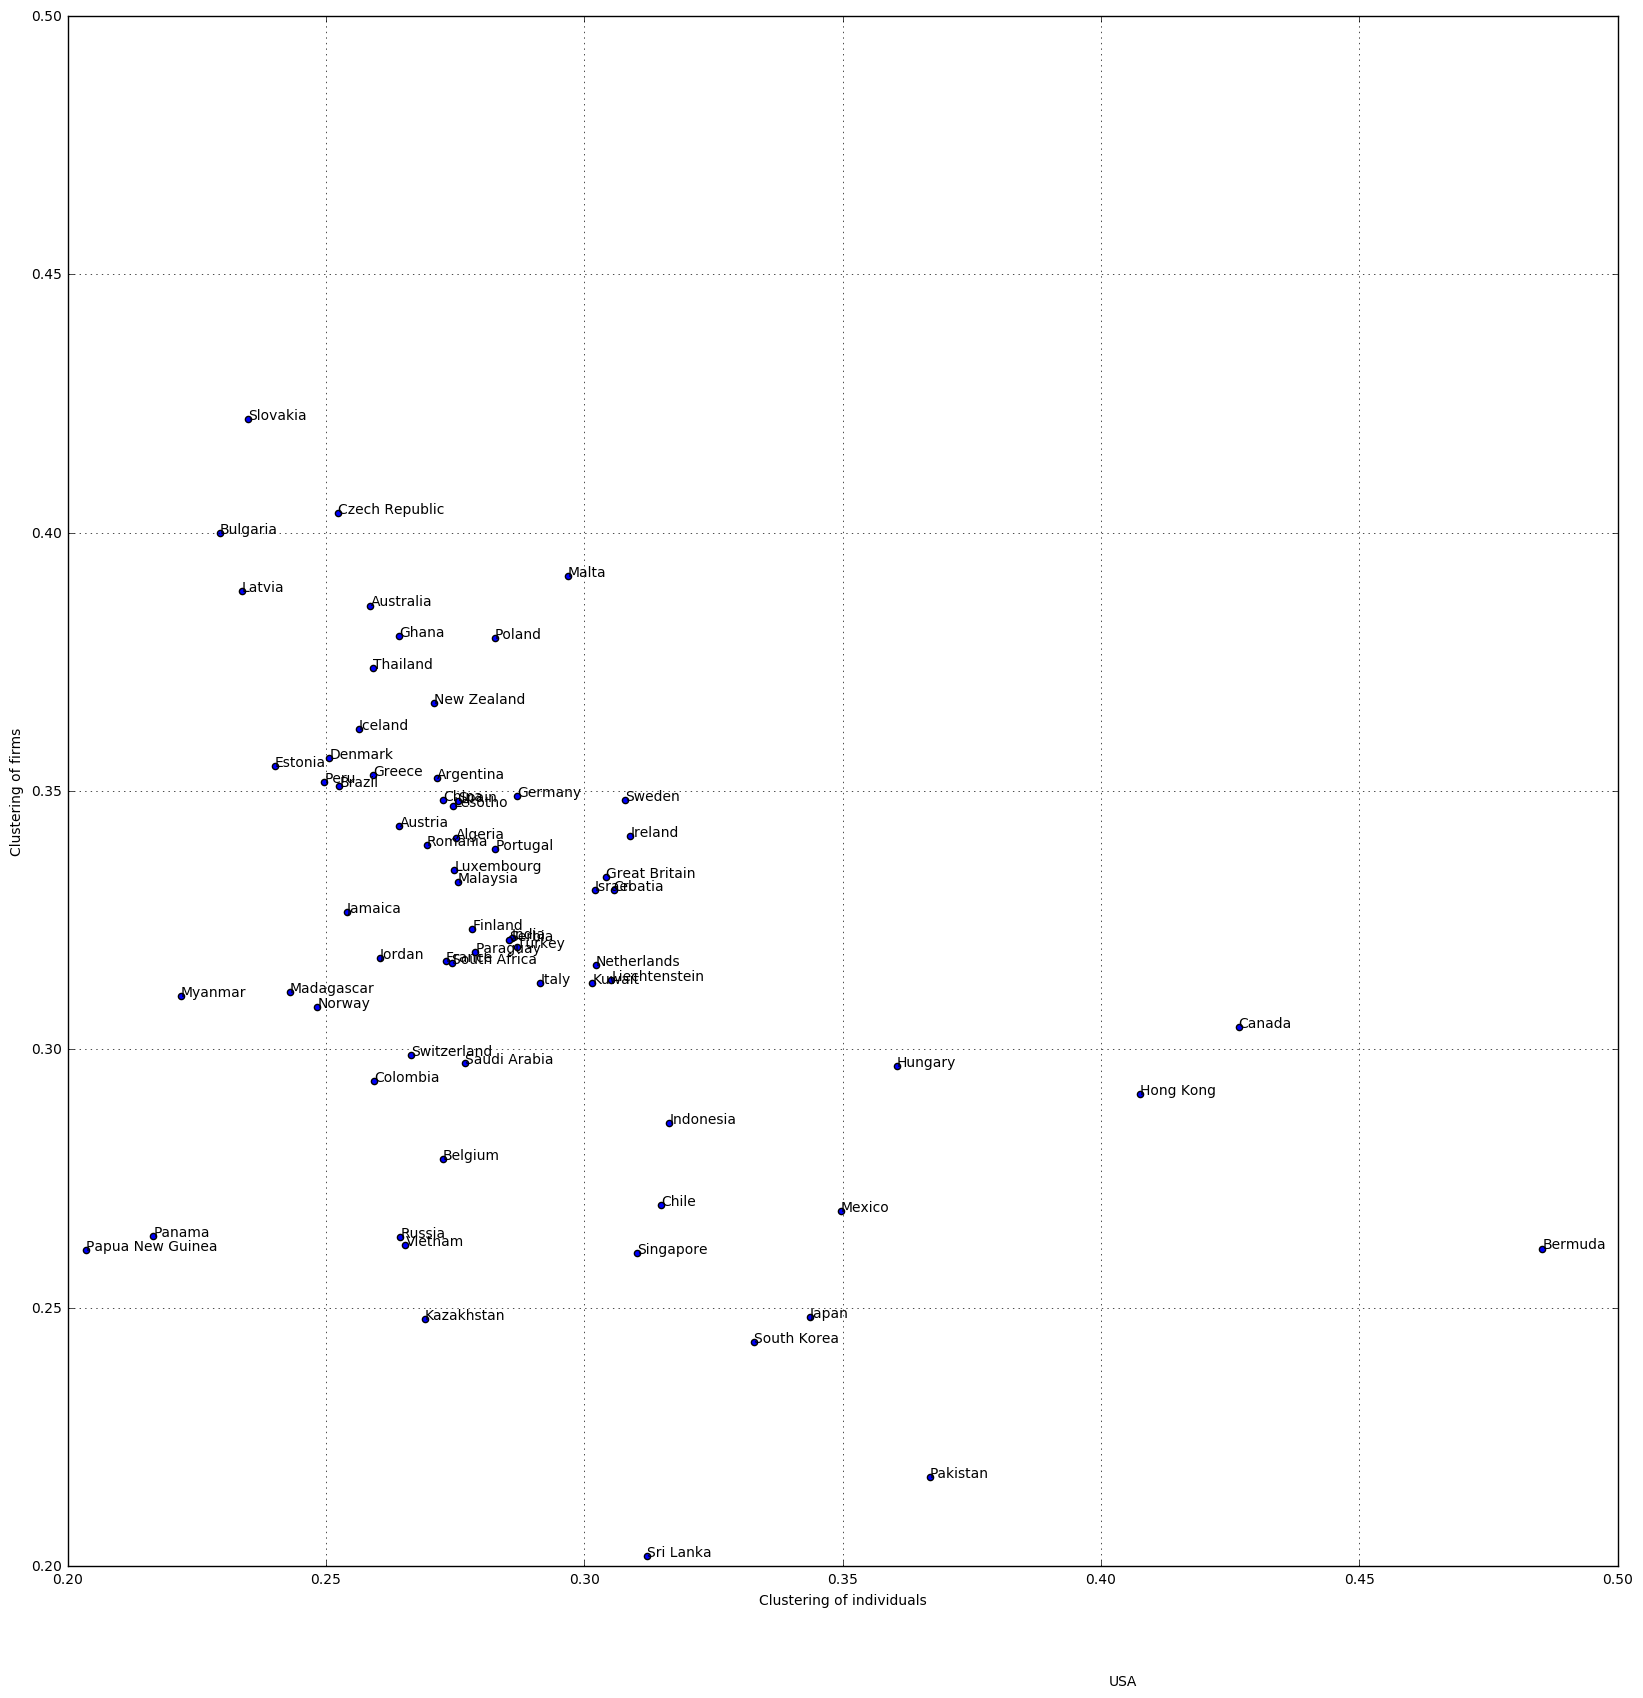

In [411]:
## Take the largest networks
df2 = stat2.loc[stat2['no_nodes'] > 1000]
ax = df2.plot.scatter(x='ave_clu_inds',y='ave_clu_firms', figsize=(20,20))
ax.grid(True)
df2[['ave_clu_inds','ave_clu_firms','country_name']].apply(lambda x: ax.text(*x),axis=1)
plt.ylabel('Clustering of firms')
plt.xlabel('Clustering of individuals')
plt.xlim((0.2, 0.50))
plt.ylim((0.2, 0.50))
plt.savefig('clu_firms_inds_dec1_1000.png')

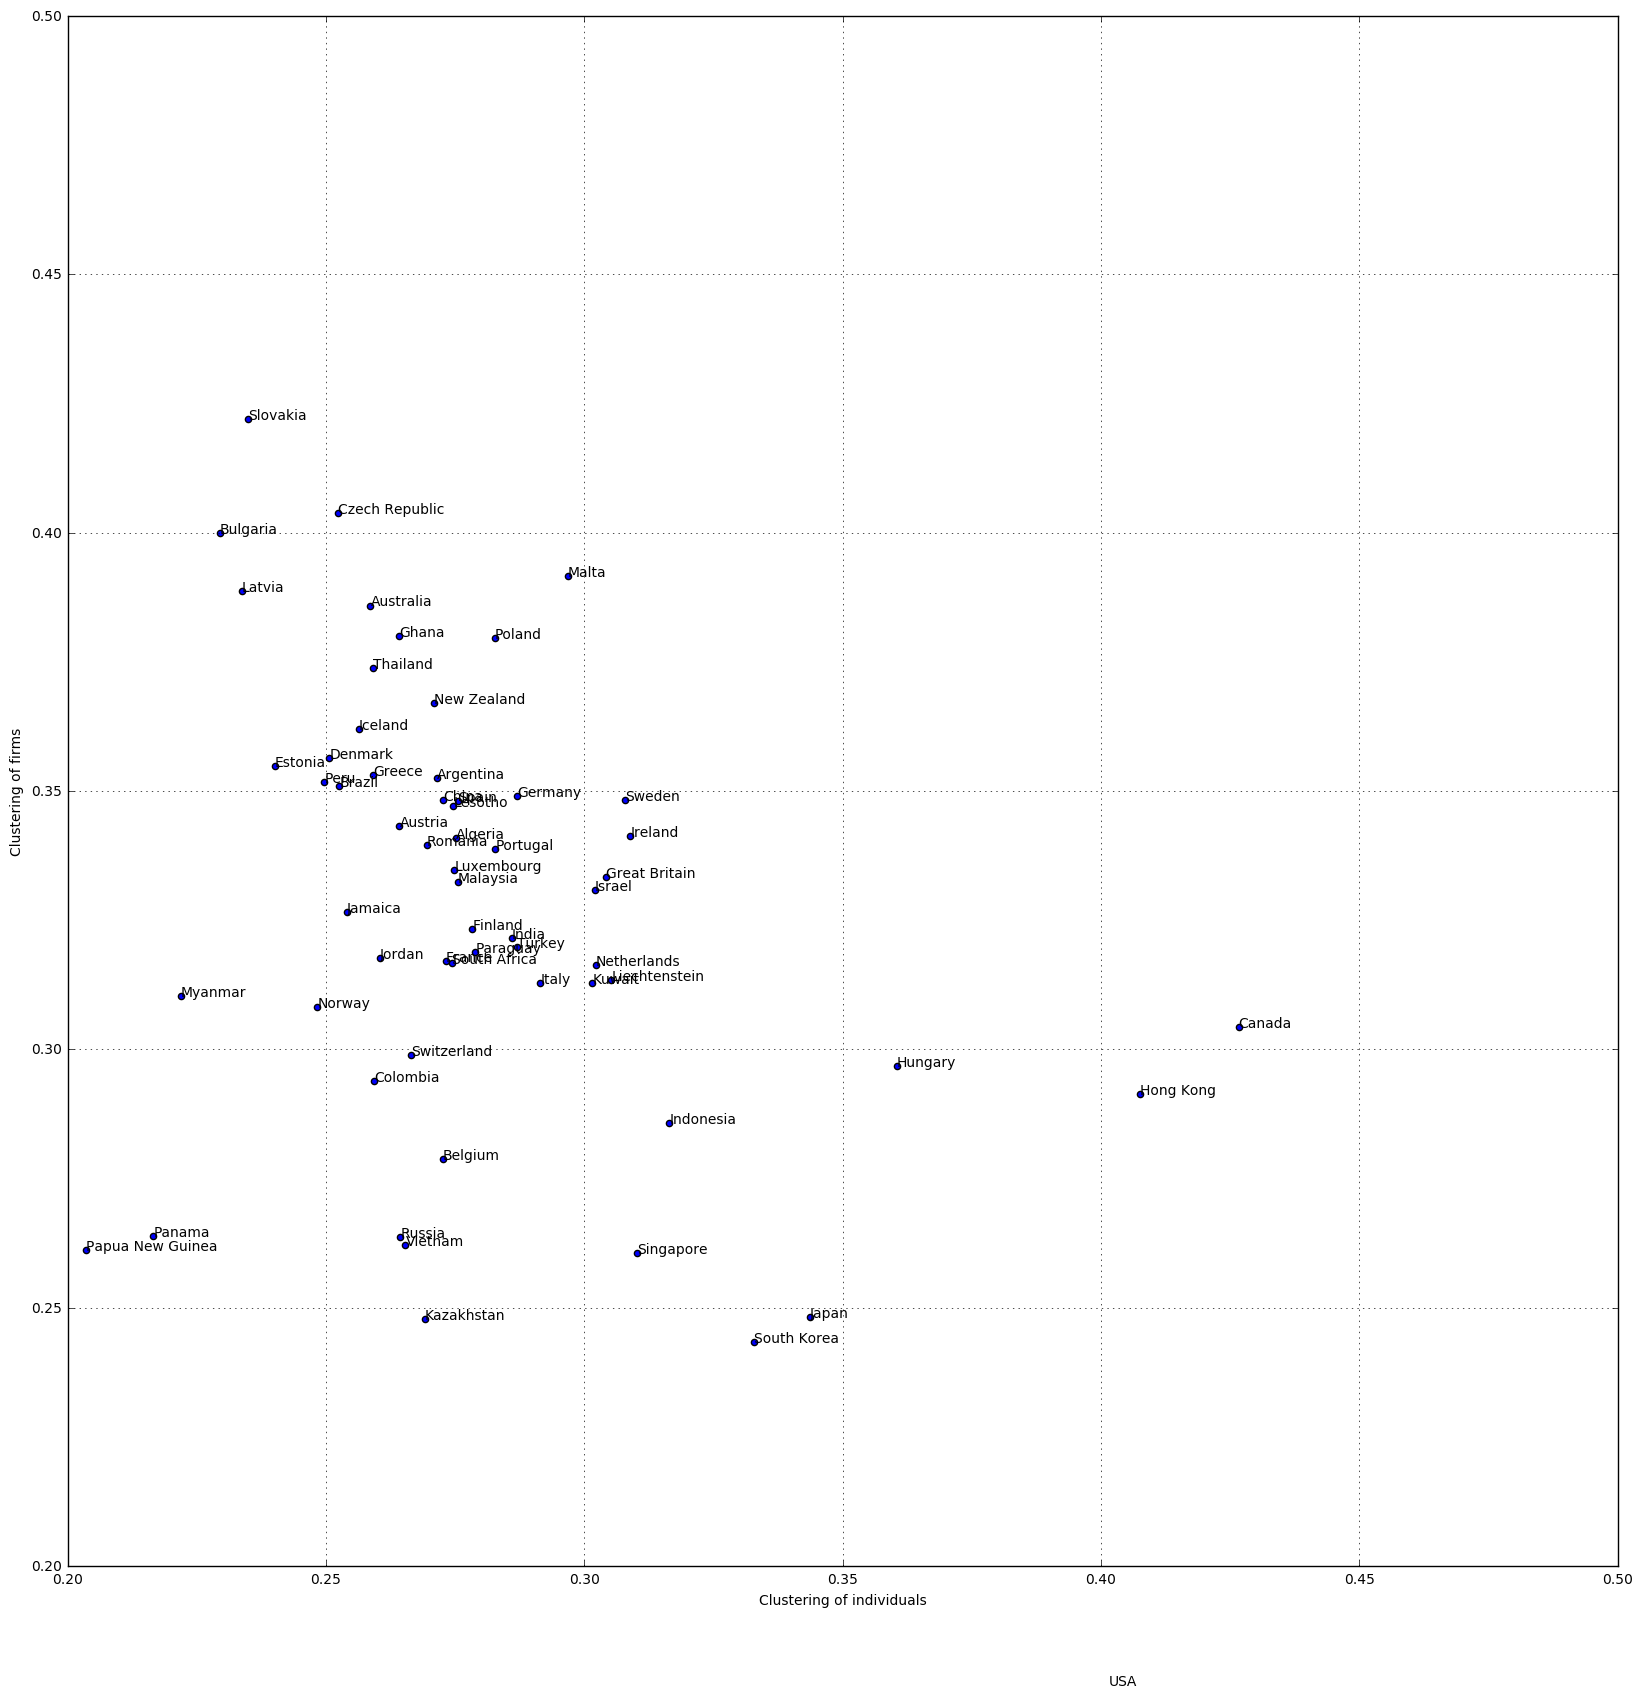

In [422]:
## Take the largest networks
df2 = stat2.loc[stat2['no_nodes'] > 3000]
ax = df2.plot.scatter(x='ave_clu_inds',y='ave_clu_firms', figsize=(20,20))
ax.grid(True)
df2[['ave_clu_inds','ave_clu_firms','country_name']].apply(lambda x: ax.text(*x),axis=1)
plt.ylabel('Clustering of firms')
plt.xlabel('Clustering of individuals')
plt.xlim((0.2, 0.50))
plt.ylim((0.2, 0.50))
plt.savefig('clu_firms_inds_dec1_3000.png')

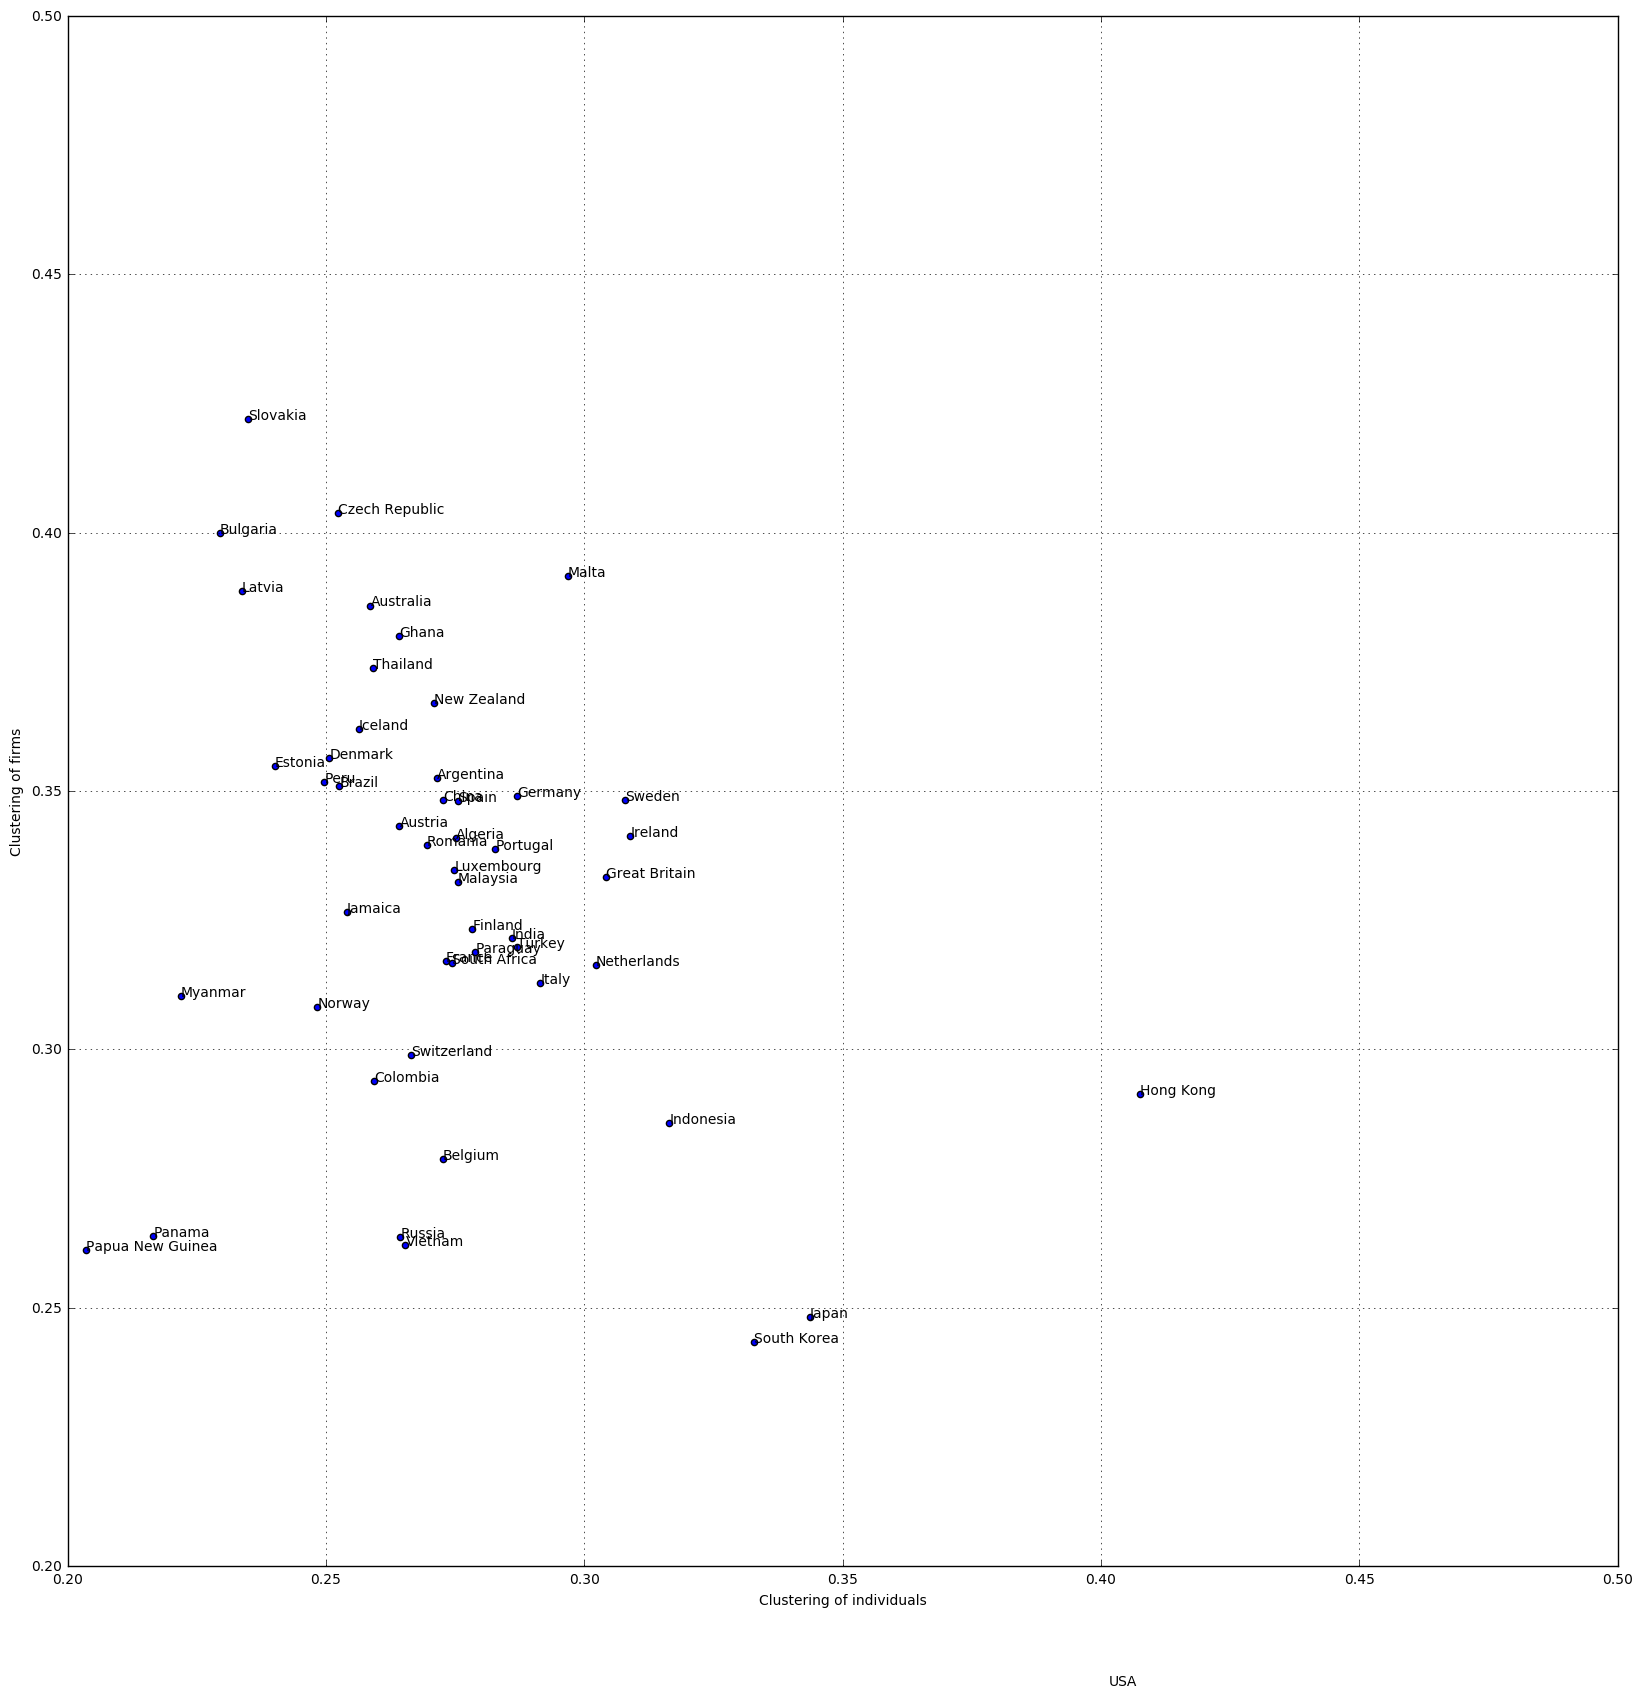

In [421]:
## Take the largest networks
df2 = stat2.loc[stat2['no_nodes'] > 5000]
ax = df2.plot.scatter(x='ave_clu_inds',y='ave_clu_firms', figsize=(20,20))
ax.grid(True)
df2[['ave_clu_inds','ave_clu_firms','country_name']].apply(lambda x: ax.text(*x),axis=1)
plt.ylabel('Clustering of firms')
plt.xlabel('Clustering of individuals')
plt.xlim((0.2, 0.50))
plt.ylim((0.2, 0.50))
plt.savefig('clu_firms_inds_dec1_5000.png')

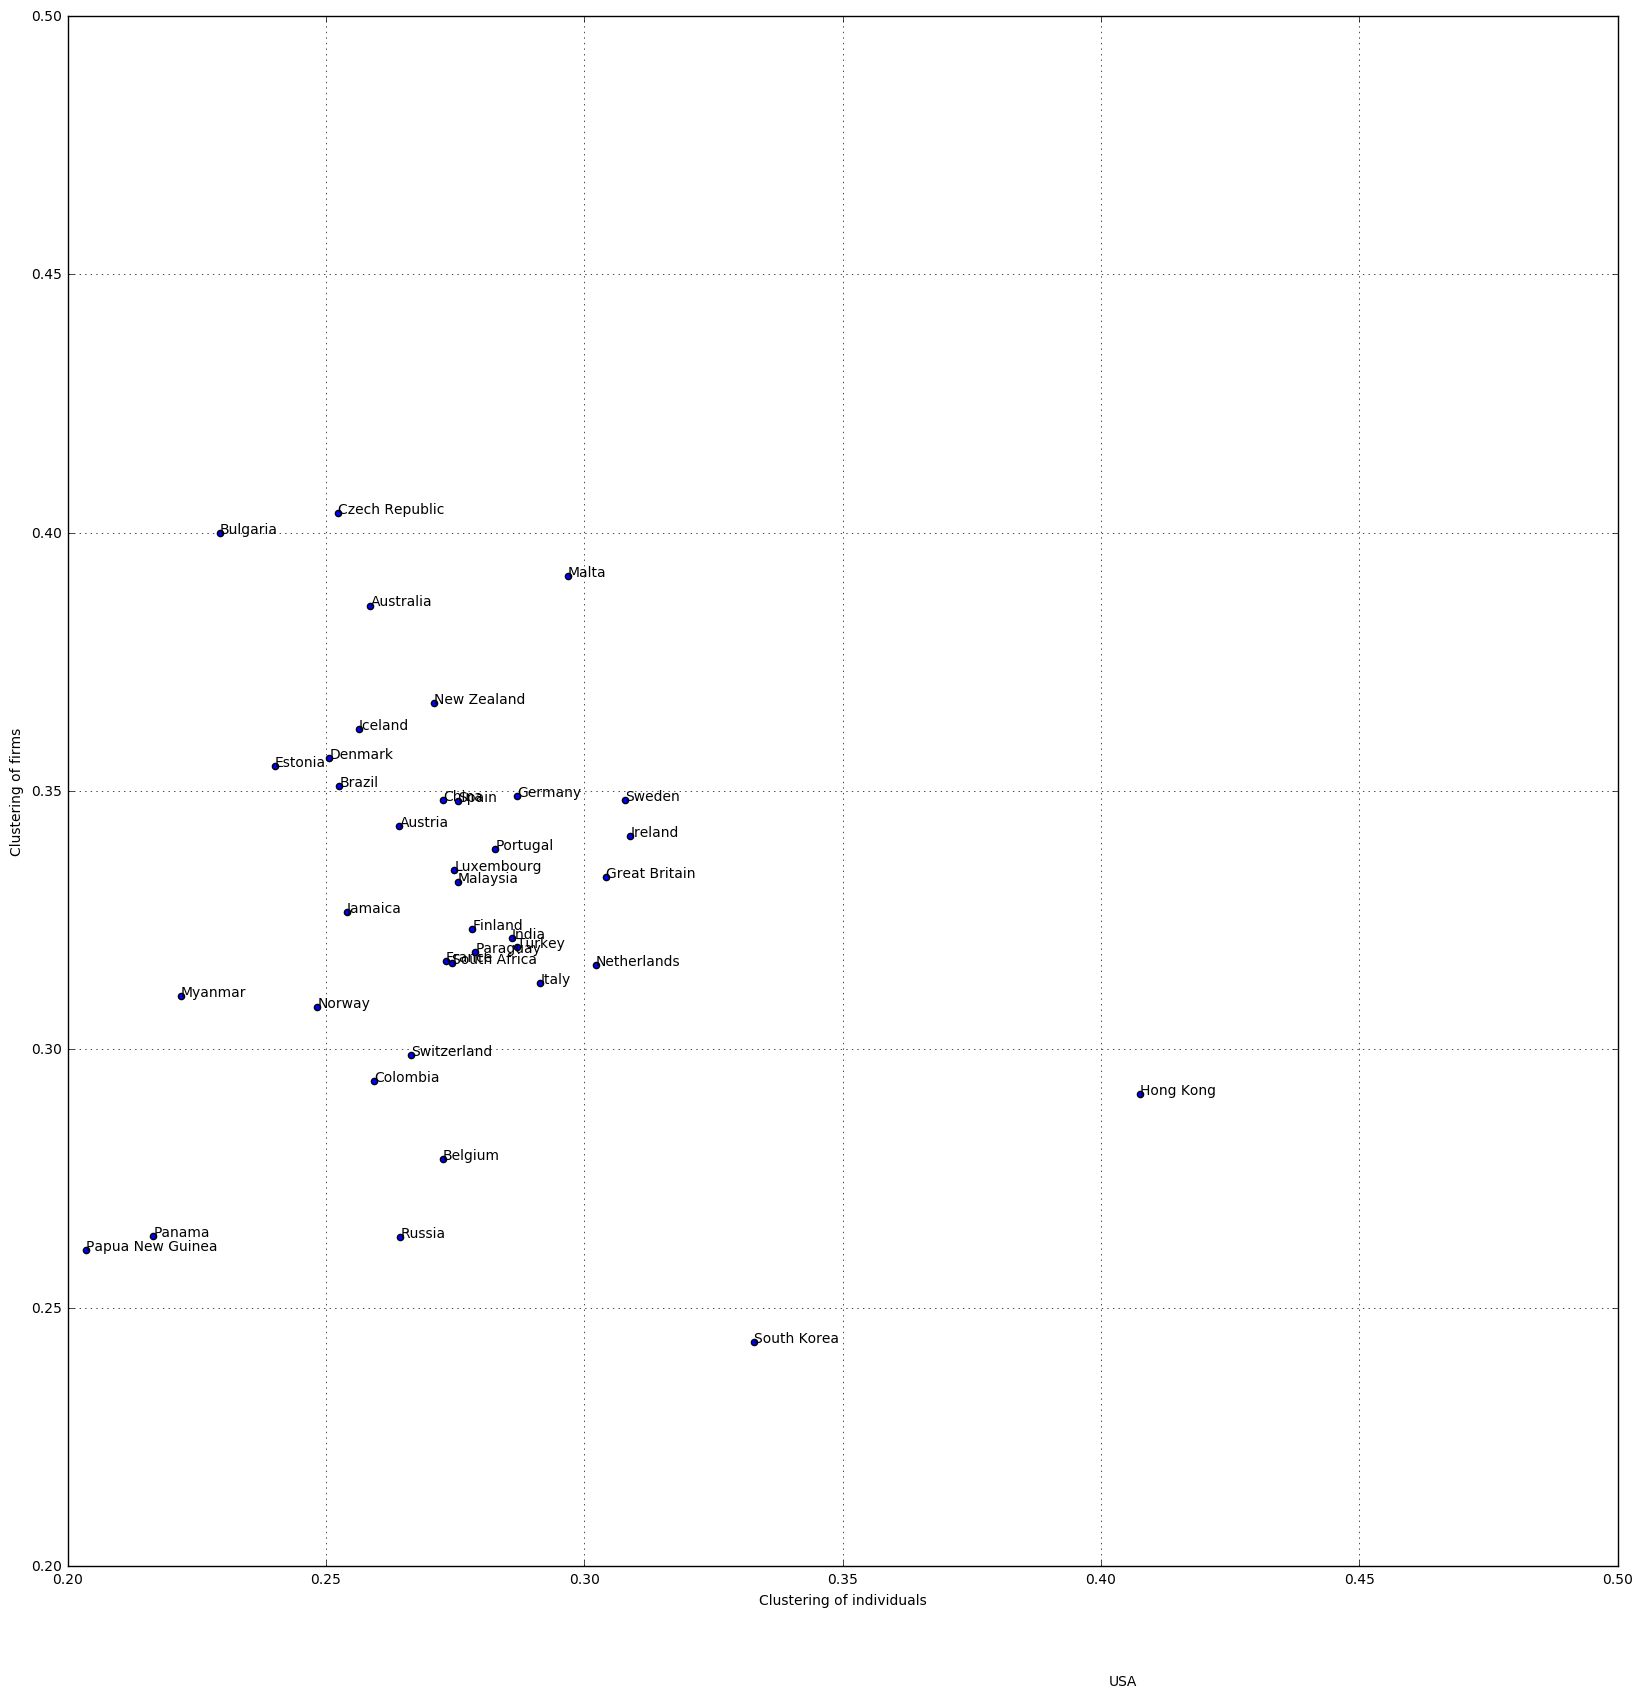

In [423]:
## Take the largest networks
df2 = stat2.loc[stat2['no_nodes'] > 8000]
ax = df2.plot.scatter(x='ave_clu_inds',y='ave_clu_firms', figsize=(20,20))
ax.grid(True)
df2[['ave_clu_inds','ave_clu_firms','country_name']].apply(lambda x: ax.text(*x),axis=1)
plt.ylabel('Clustering of firms')
plt.xlabel('Clustering of individuals')
plt.xlim((0.2, 0.50))
plt.ylim((0.2, 0.50))
plt.savefig('clu_firms_inds_dec1_8000.png')

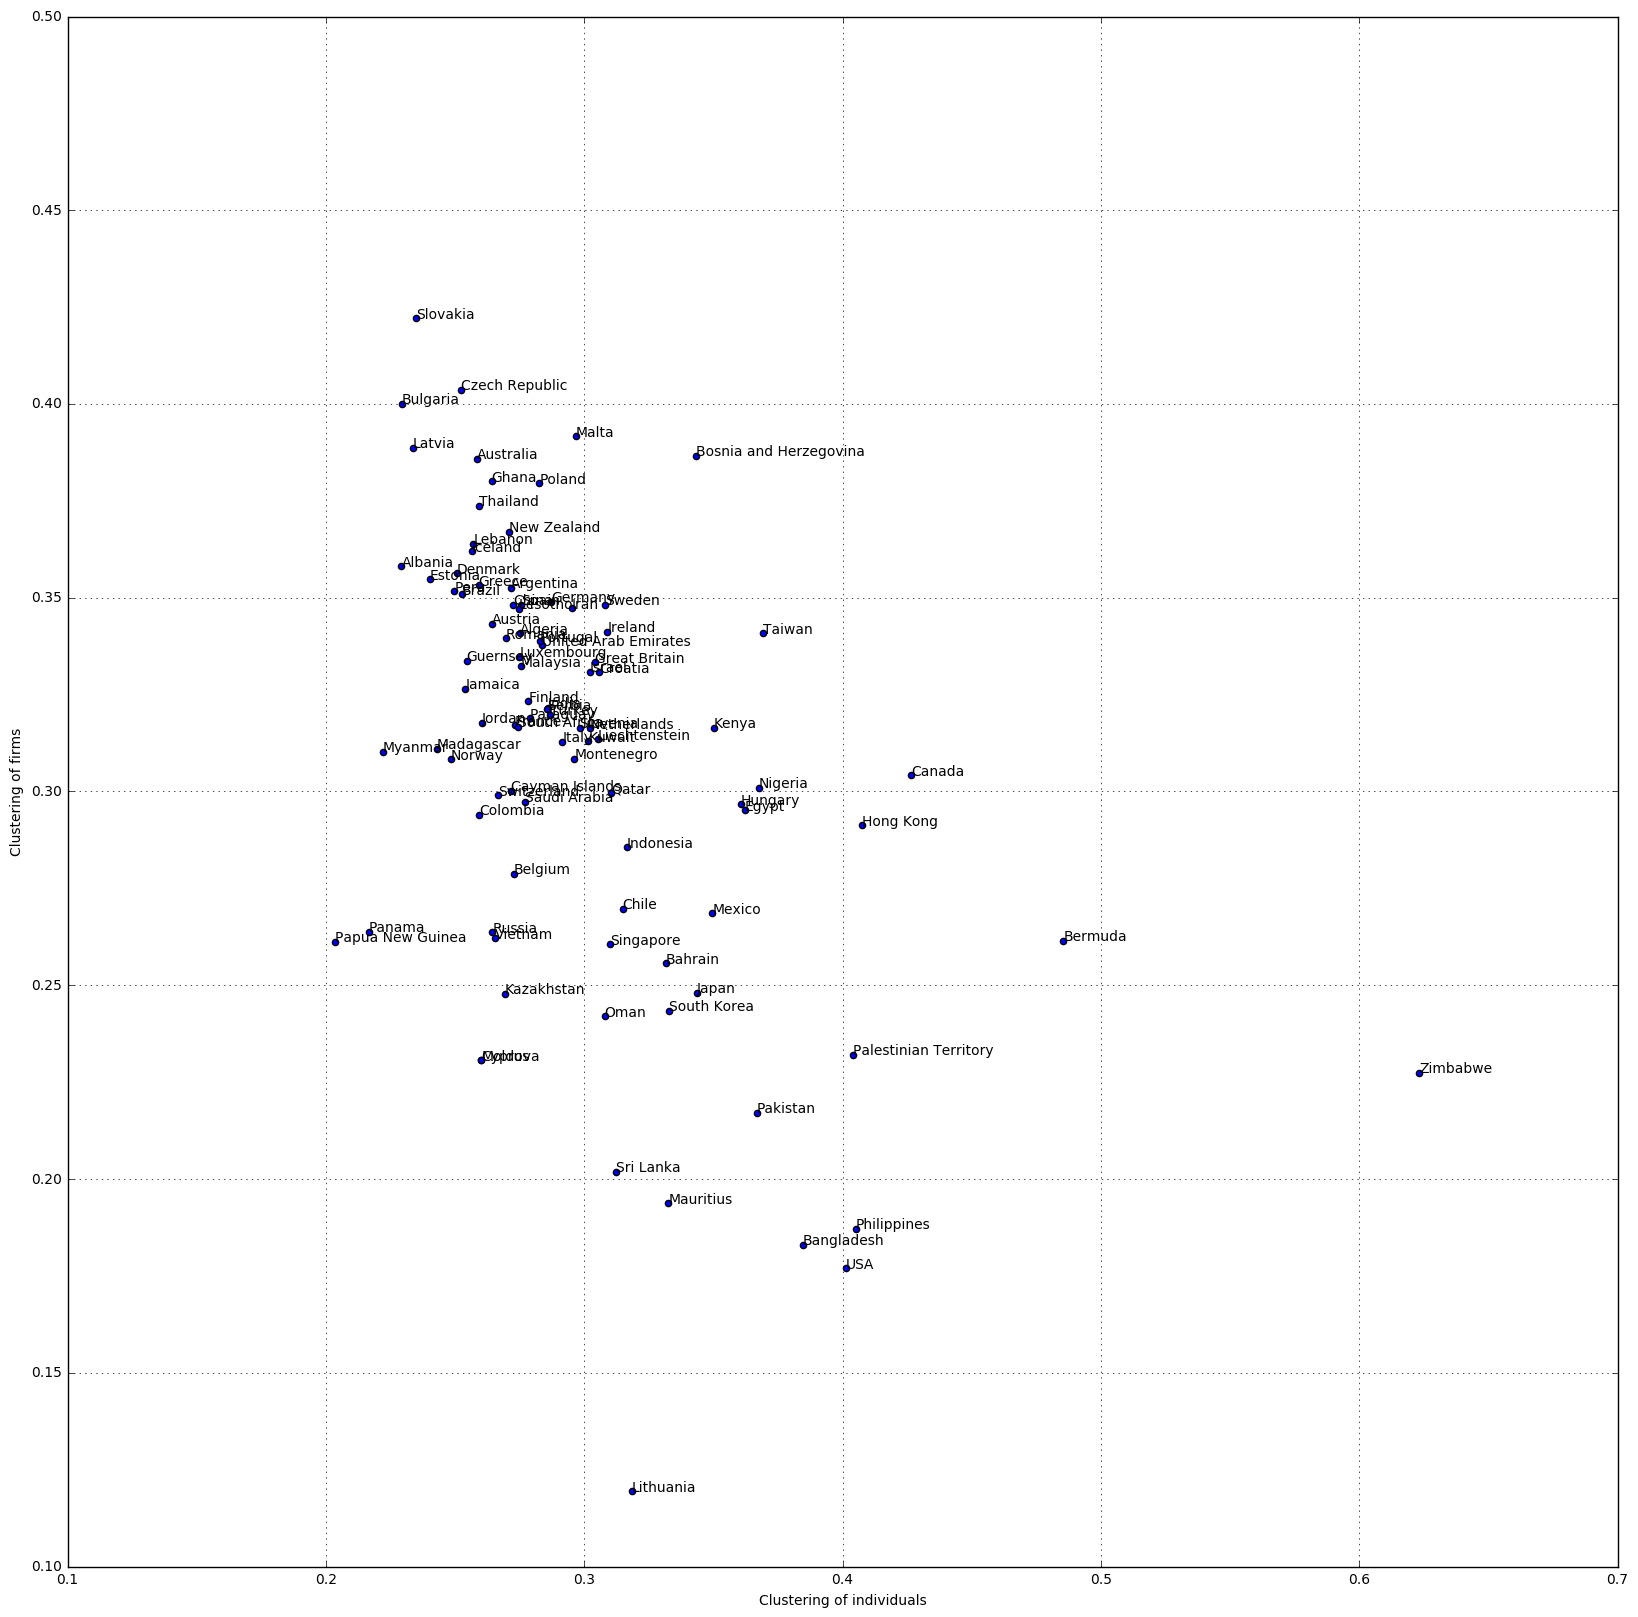

In [415]:
## Take the largest networks
df2 = stat2.loc[stat2['no_nodes'] > 100]
ax = df2.plot.scatter(x='ave_clu_inds',y='ave_clu_firms', figsize=(20,20))
ax.grid(True)
df2[['ave_clu_inds','ave_clu_firms','country_name']].apply(lambda x: ax.text(*x),axis=1)
plt.ylabel('Clustering of firms')
plt.xlabel('Clustering of individuals')
plt.xlim((0.1, 0.70))
plt.ylim((0.1, 0.50))
plt.savefig('clu_firms_inds_dec1_100.png')

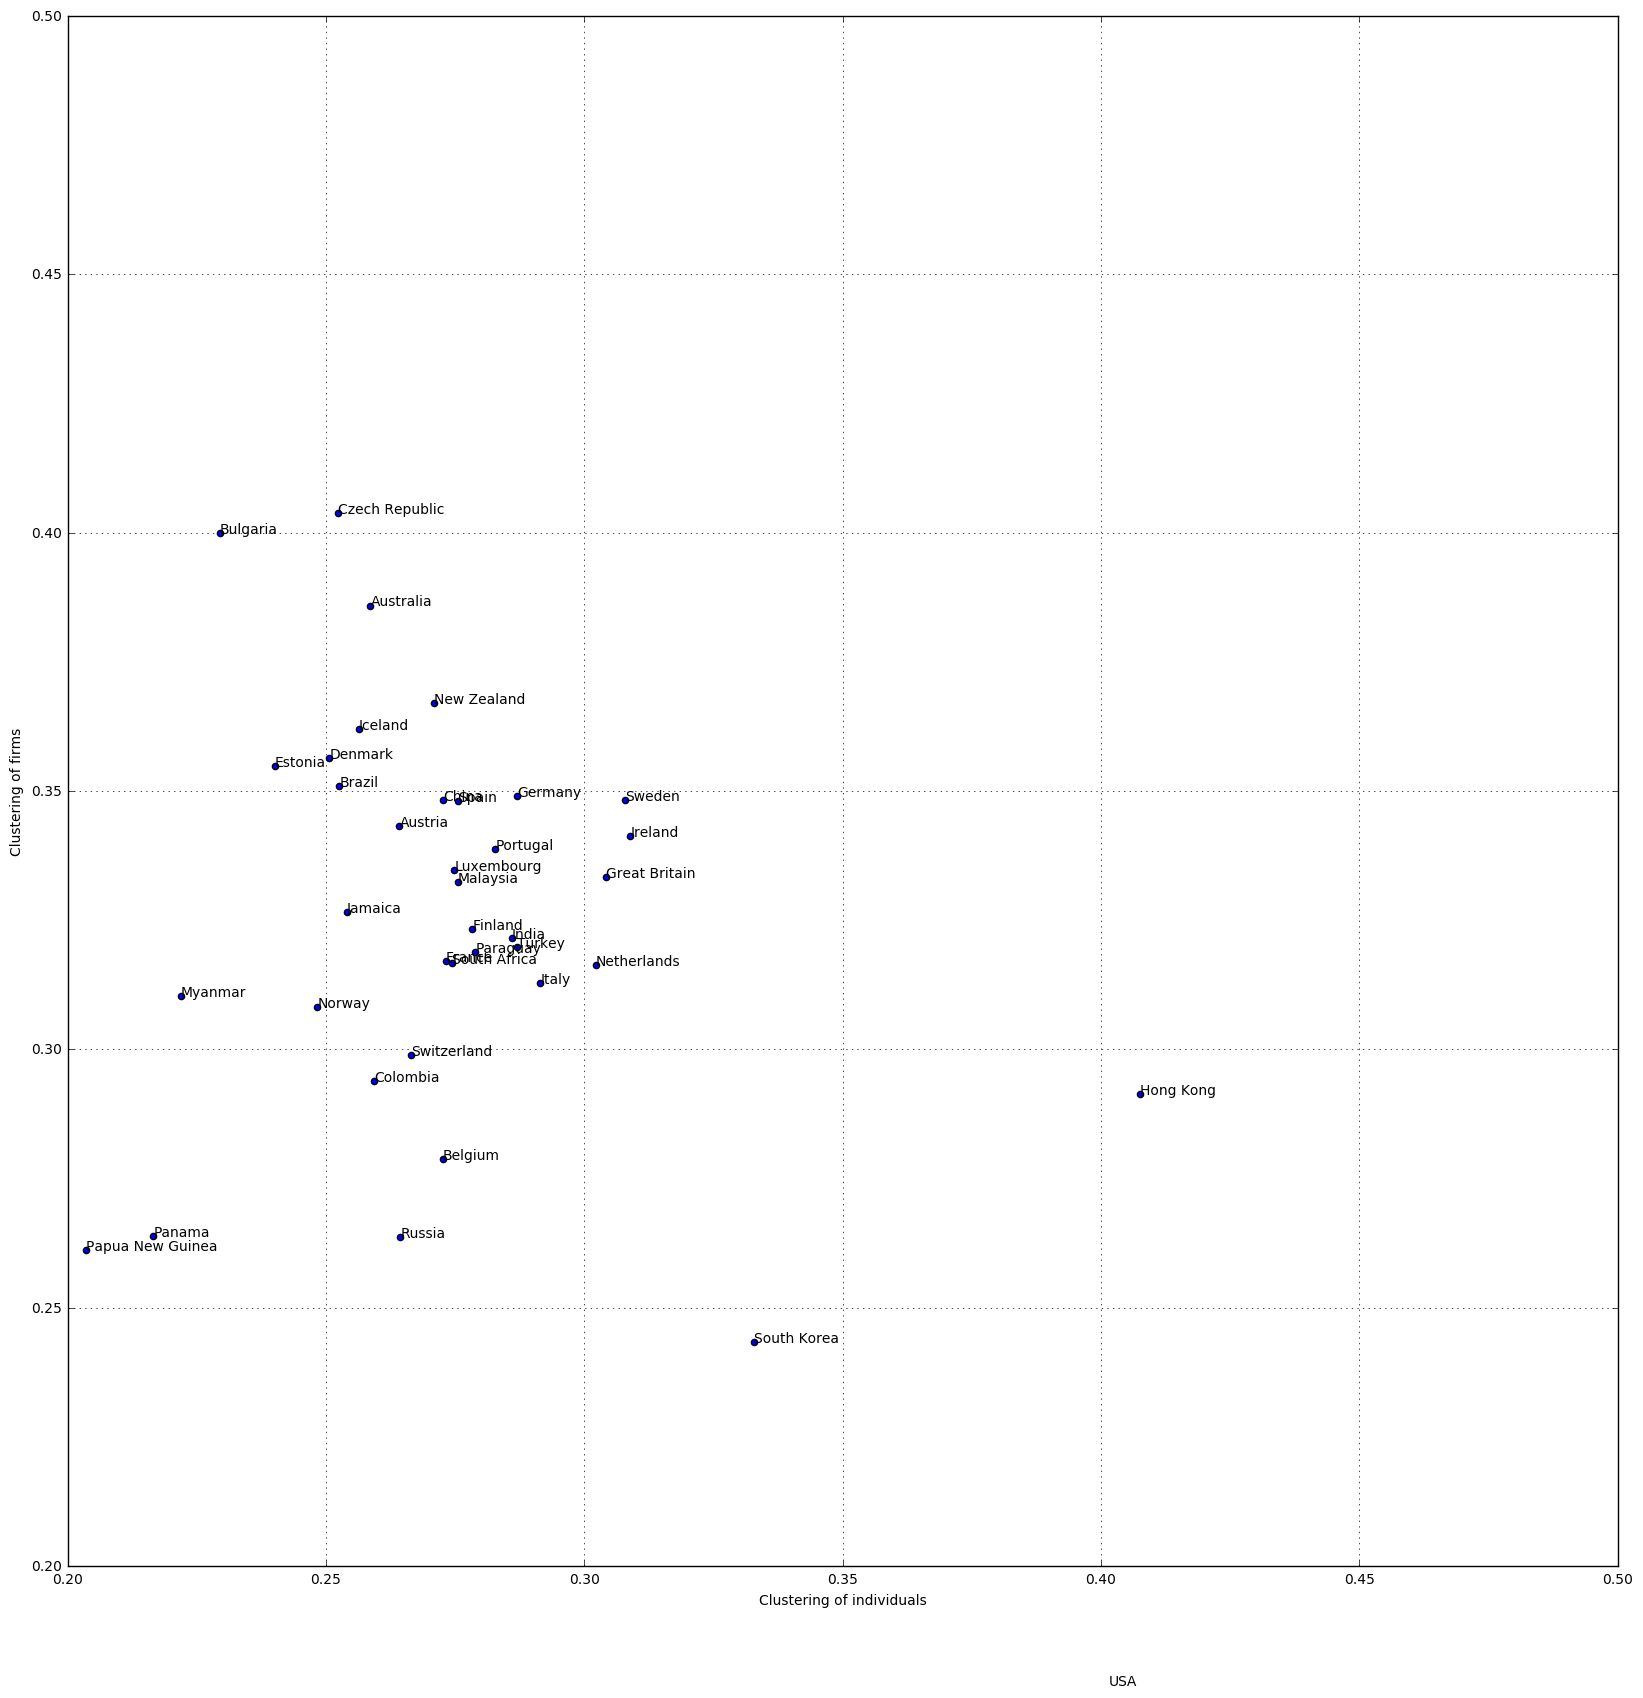

In [425]:
## Take the largest networks
df2 = stat2.loc[stat2['no_nodes'] > 10000]
ax = df2.plot.scatter(x='ave_clu_inds',y='ave_clu_firms', figsize=(20,20))
ax.grid(True)
df2[['ave_clu_inds','ave_clu_firms','country_name']].apply(lambda x: ax.text(*x),axis=1)
plt.ylabel('Clustering of firms')
plt.xlabel('Clustering of individuals')
plt.xlim((0.2, 0.50))
plt.ylim((0.2, 0.50))
plt.savefig('clu_firms_inds_dec1_10000.png')

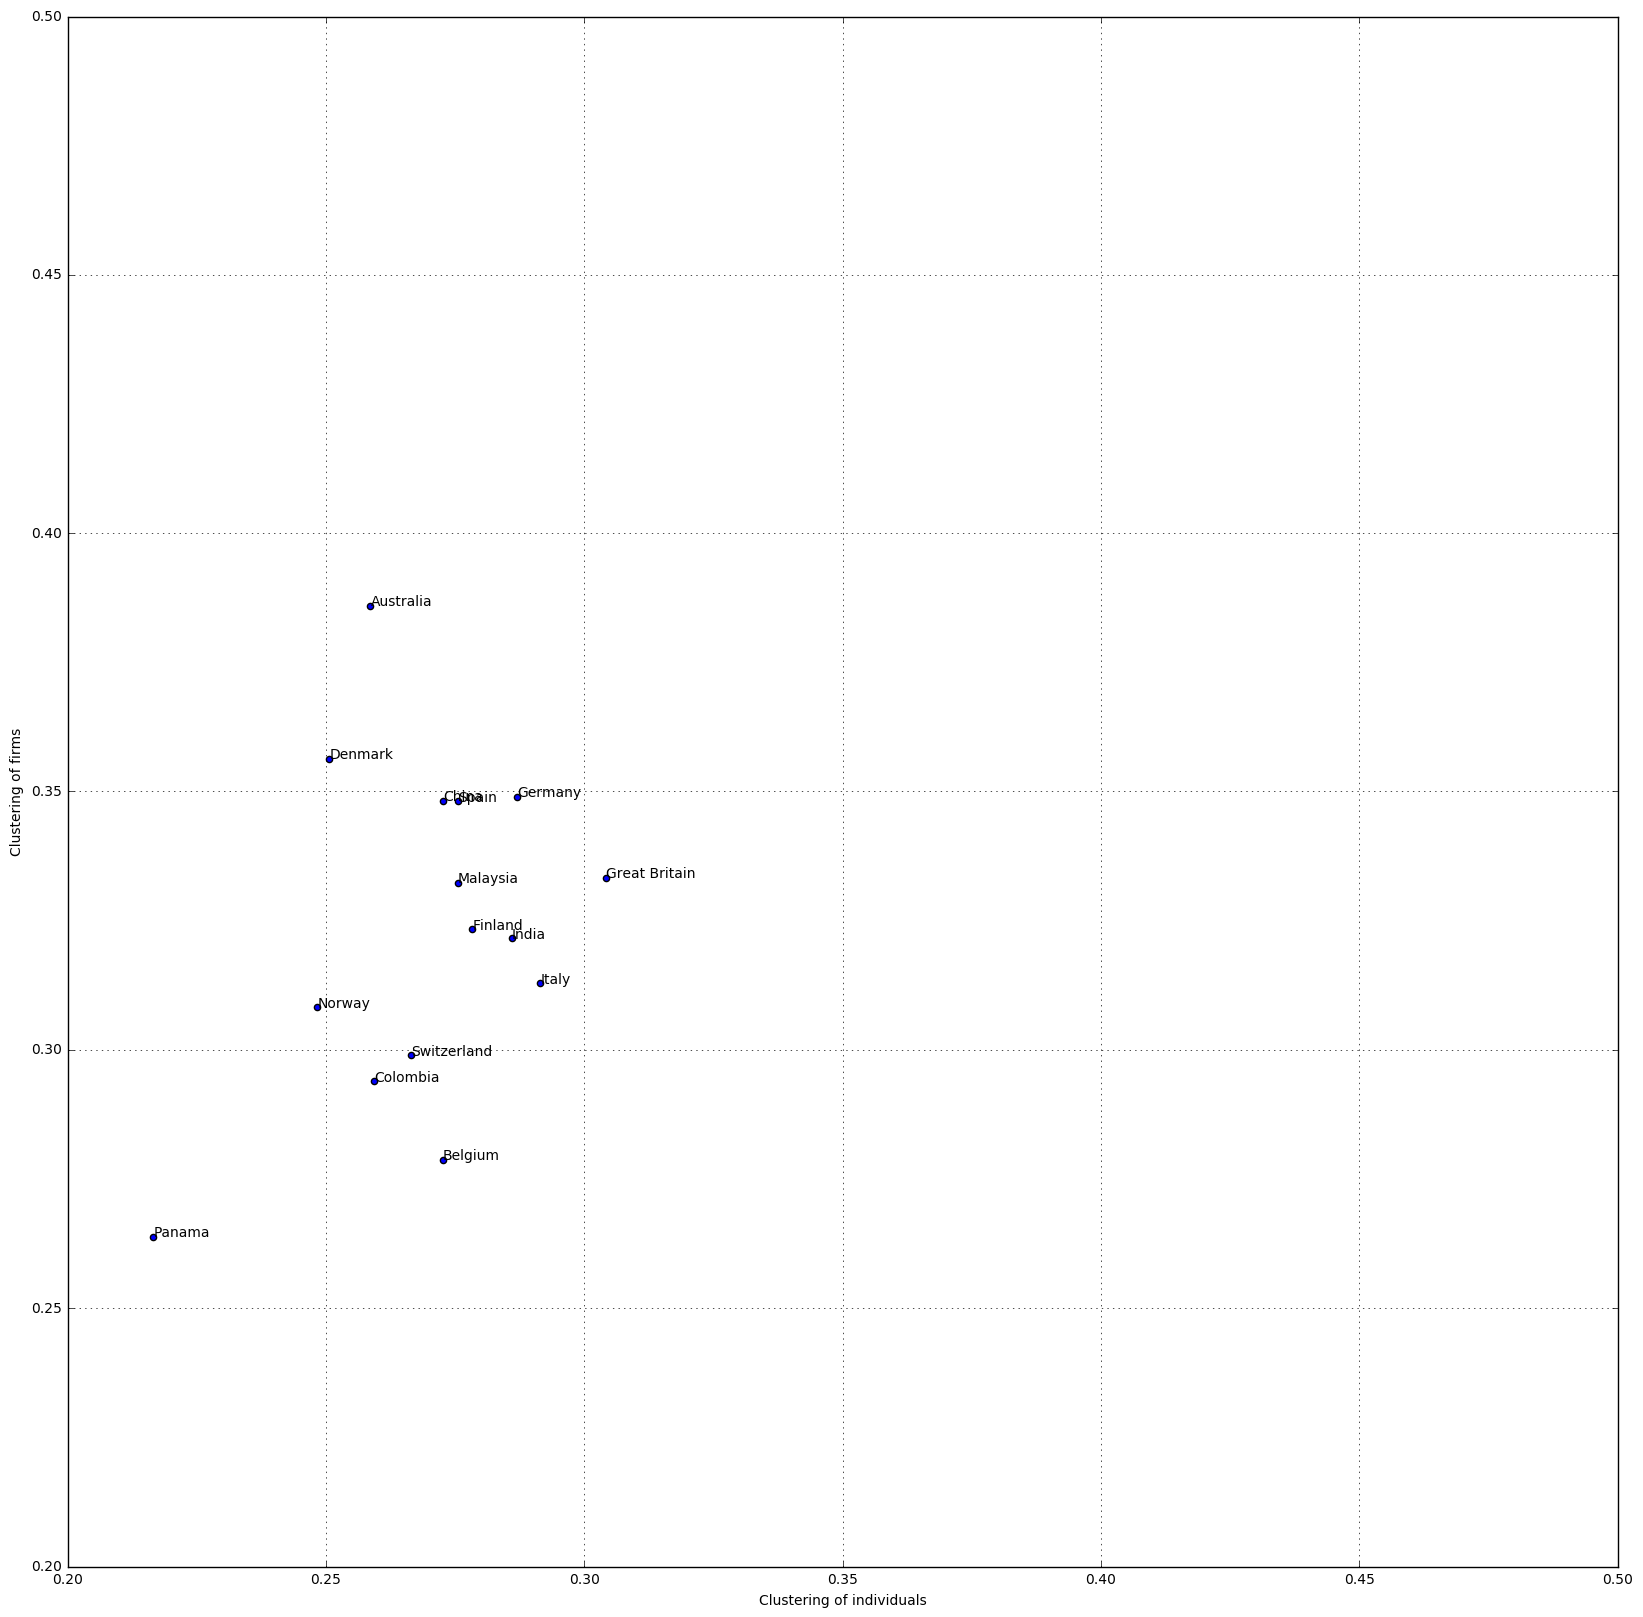

In [427]:
## Take the largest networks
df2 = stat2.loc[stat2['no_nodes'] > 100000]
ax = df2.plot.scatter(x='ave_clu_inds',y='ave_clu_firms', figsize=(20,20))
ax.grid(True)
df2[['ave_clu_inds','ave_clu_firms','country_name']].apply(lambda x: ax.text(*x),axis=1)
plt.ylabel('Clustering of firms')
plt.xlabel('Clustering of individuals')
plt.xlim((0.2, 0.50))
plt.ylim((0.2, 0.50))
plt.savefig('clu_firms_inds_dec1_100000.png')

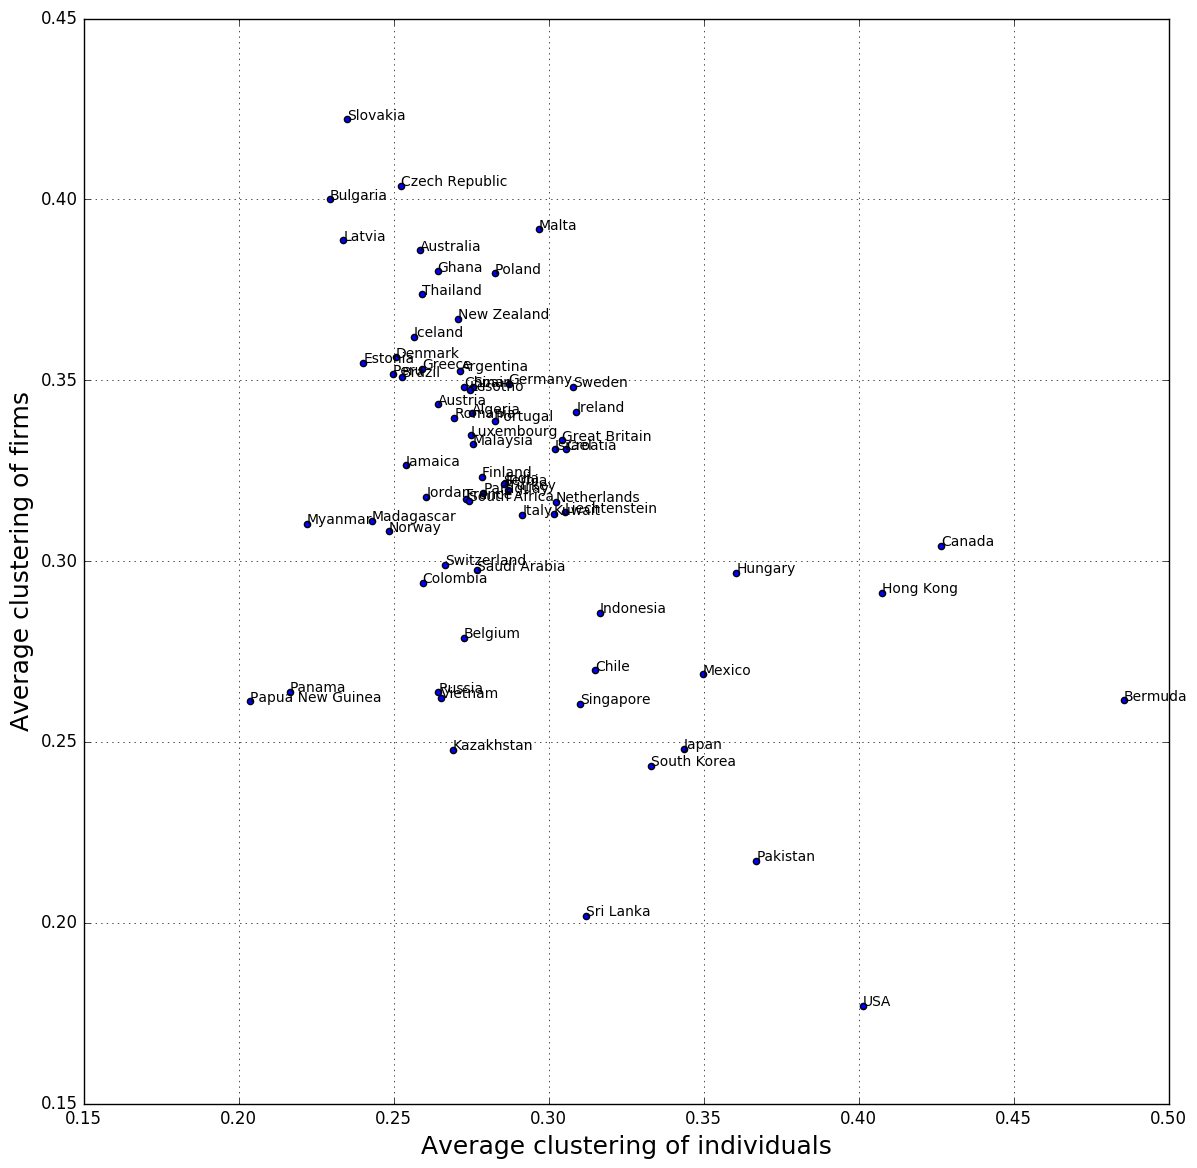

In [12]:
## Take the largest networks
df2 = stat2.loc[stat2['no_nodes'] > 1000]
ax = df2.plot.scatter(x='ave_clu_inds',y='ave_clu_firms', figsize=(14,14))
ax.grid(True)
df2[['ave_clu_inds','ave_clu_firms','country_name']].apply(lambda x: ax.text(*x),axis=1)
#plt.ylabel('Clustering of firms')
#plt.xlabel('Clustering of individuals')
plt.xlim((0.15, 0.50))
plt.ylim((0.15, 0.45))

ax.set_ylabel("Average clustering of firms",fontsize=18)
ax.set_xlabel("Average clustering of individuals", fontsize=18)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)


plt.savefig('clu_firms_inds_jan9_1000.png')

### Assortativity

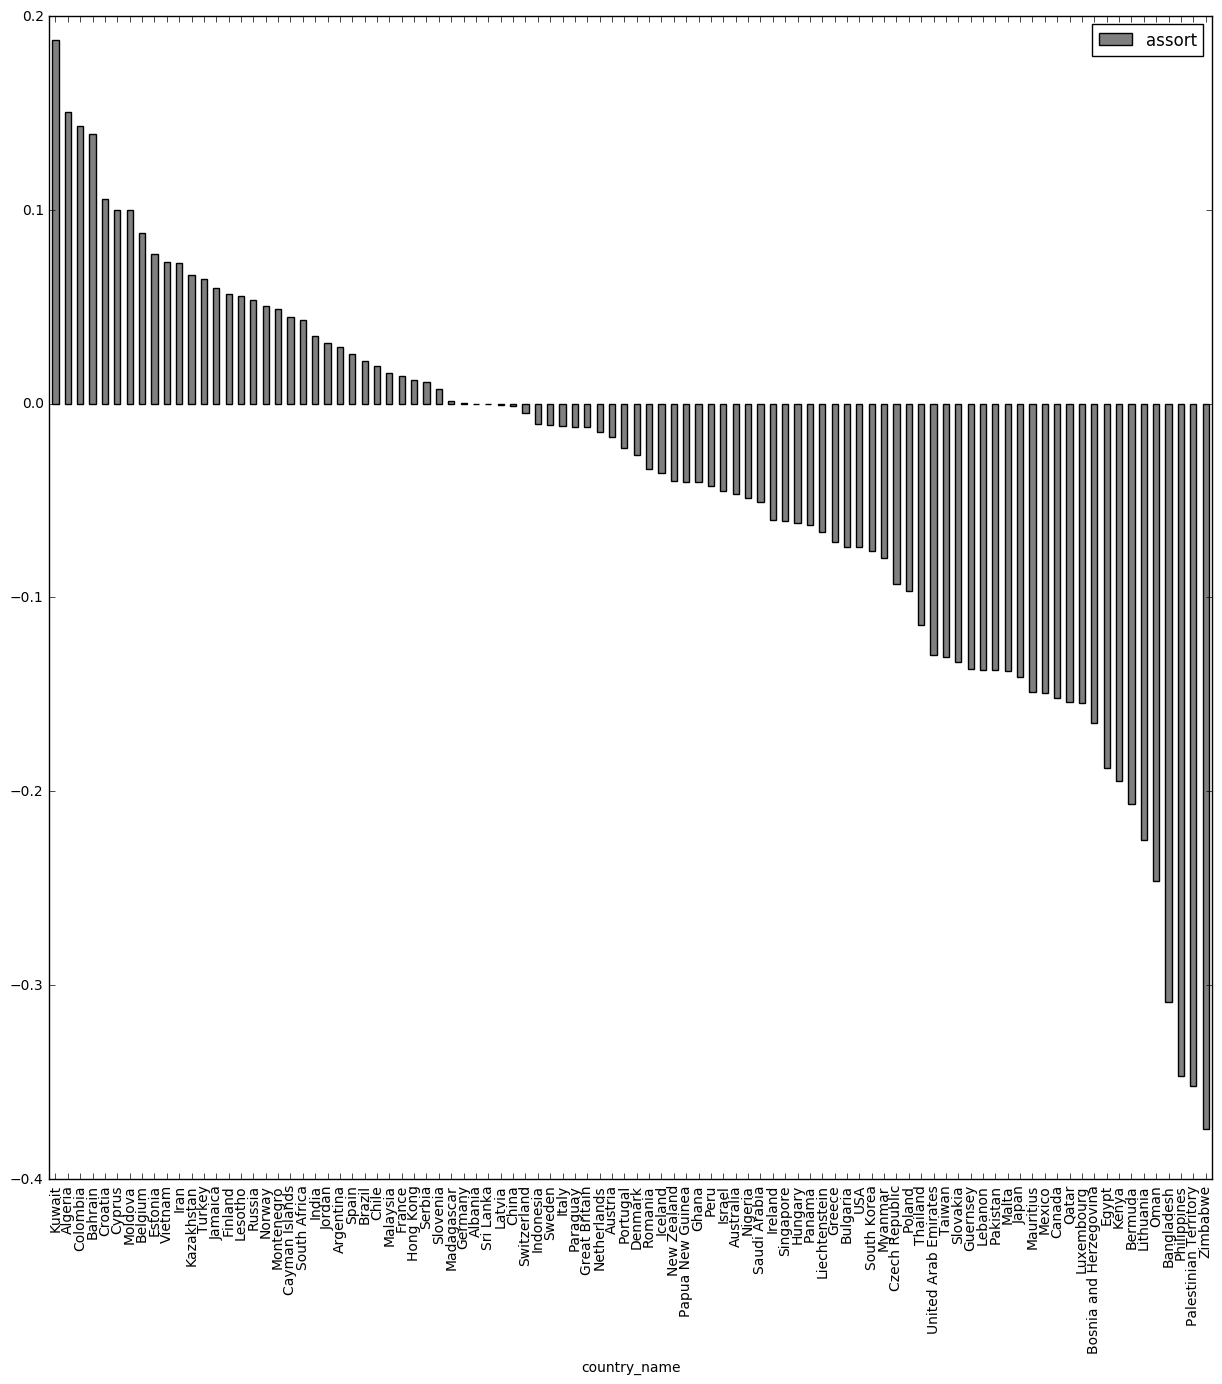

In [431]:
df6 = stat2.loc[stat2['no_nodes'] > 100]
df6.sort_values('assort', ascending=False).plot(kind='bar',x='country_name', y= 'assort', color = 'grey', figsize=(15,15))
#plt.ylabel('Assortativity')

In [ ]:
# correlate no nodes and assort

(0.0, 1000000)

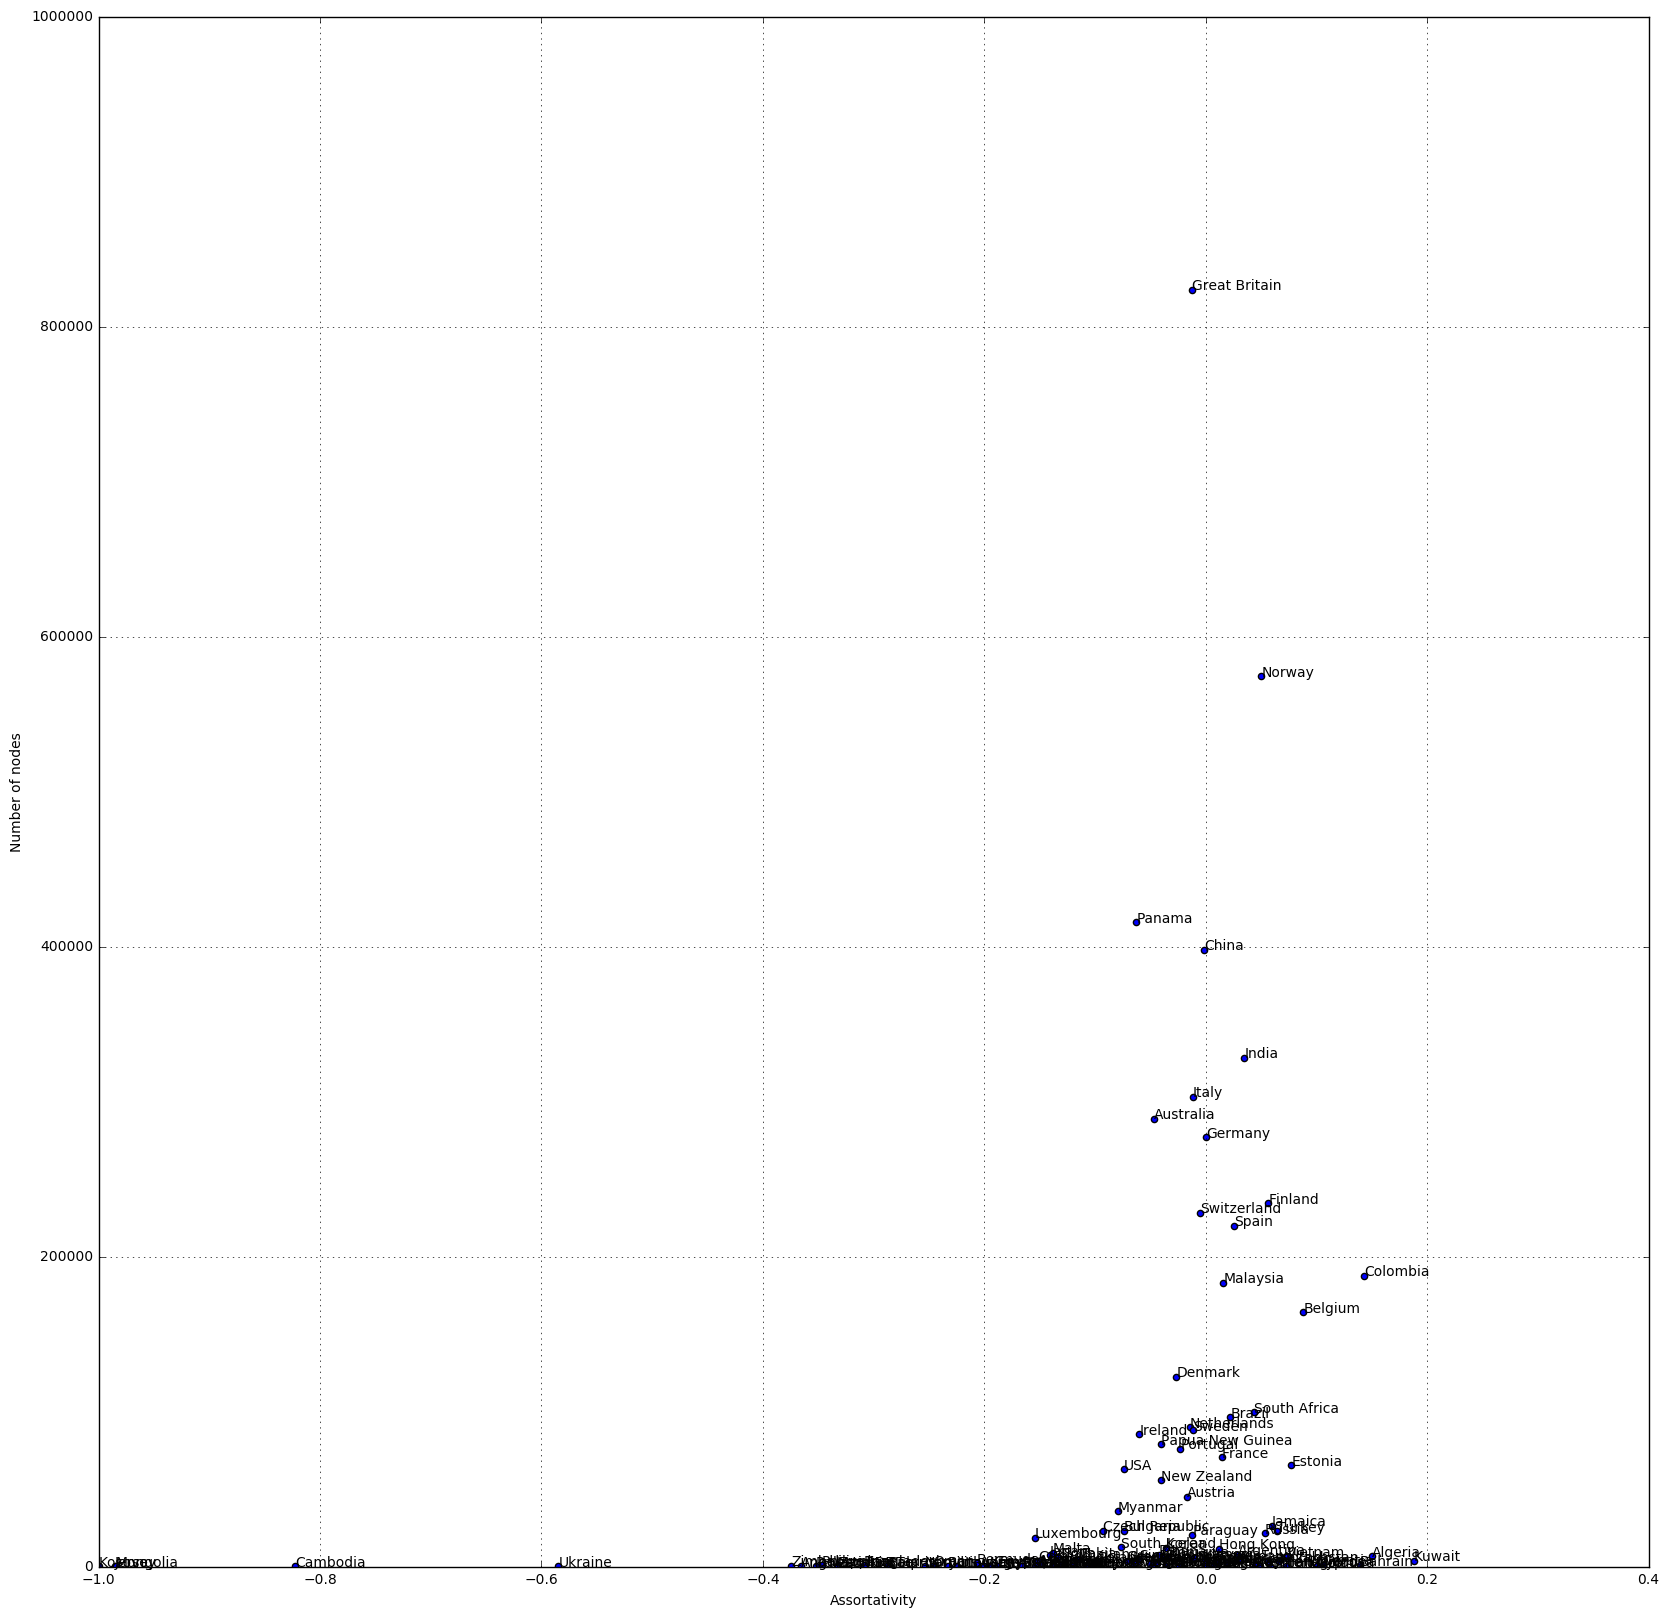

In [438]:
ax = stat2.plot.scatter(x='assort',y='no_nodes', figsize=(20,20))
ax.grid(True)
stat2[['assort','no_nodes','country_name']].apply(lambda x: ax.text(*x),axis=1)
plt.xlabel('Assortativity')
plt.ylabel('Number of nodes')
plt.xlim((-1.0, 0.40))
plt.ylim((0.0, 1000000))

In [ ]:
## Assort and clustering

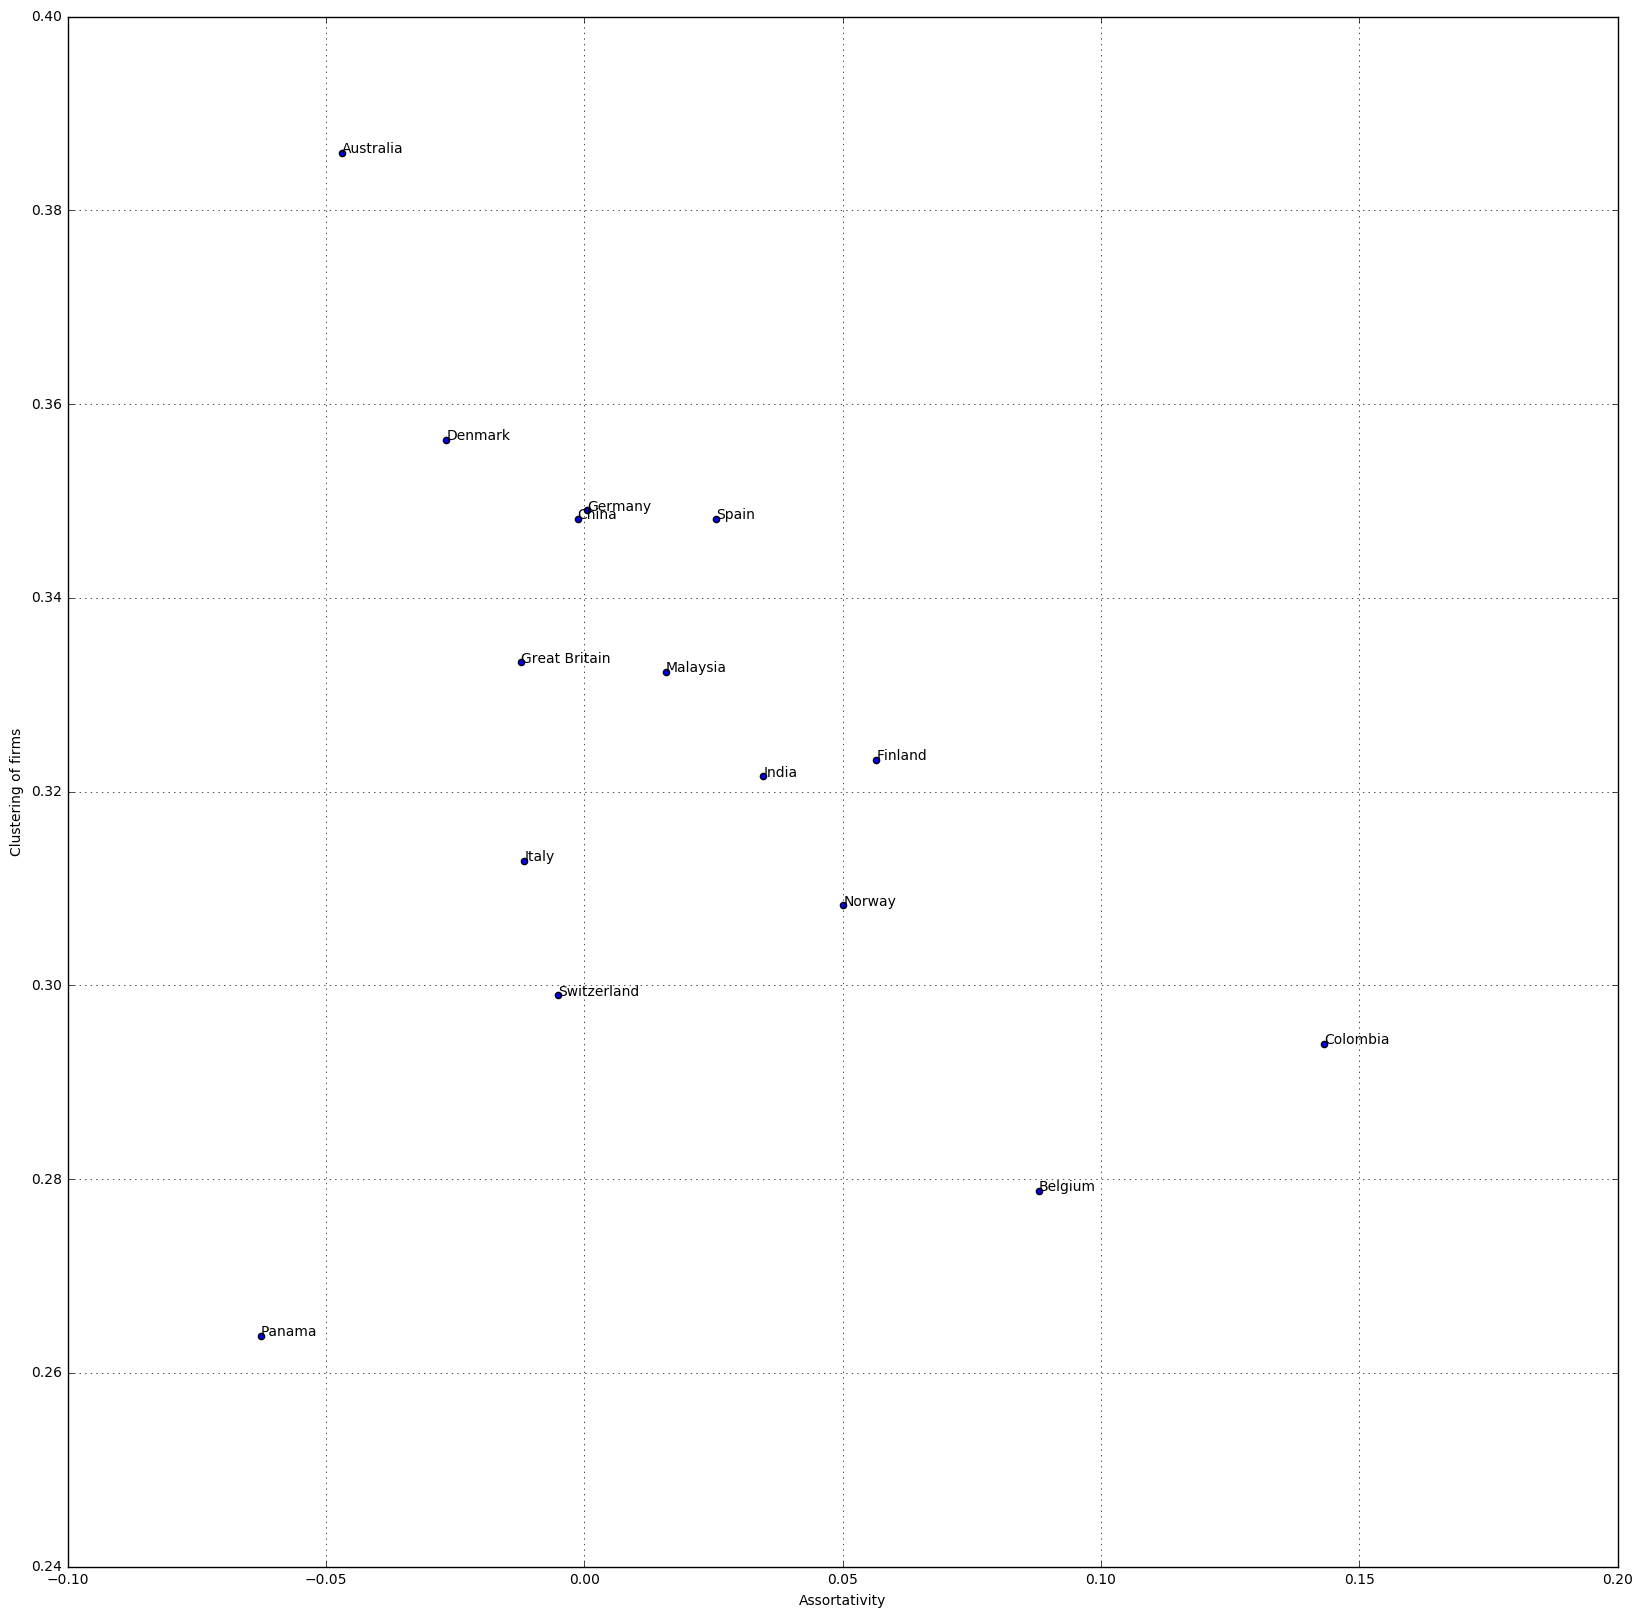

In [440]:
## Take the largest networks
df2 = stat2.loc[stat2['no_nodes'] > 100000]
ax = df2.plot.scatter(x='assort',y='ave_clu_firms', figsize=(20,20))
ax.grid(True)
df2[['assort','ave_clu_firms','country_name']].apply(lambda x: ax.text(*x),axis=1)
plt.ylabel('Clustering of firms')
plt.xlabel('Assortativity')
#plt.xlim((0.2, 0.50))
#plt.ylim((0.2, 0.50))
#plt.savefig('clu_firms_inds_dec1_100000.png')


## Average shortest path length

In [ ]:
for i in giant:
    print(nx.average_shortest_path_length(i))
# calculates first 5 cases for a day

(0, 0.0012)

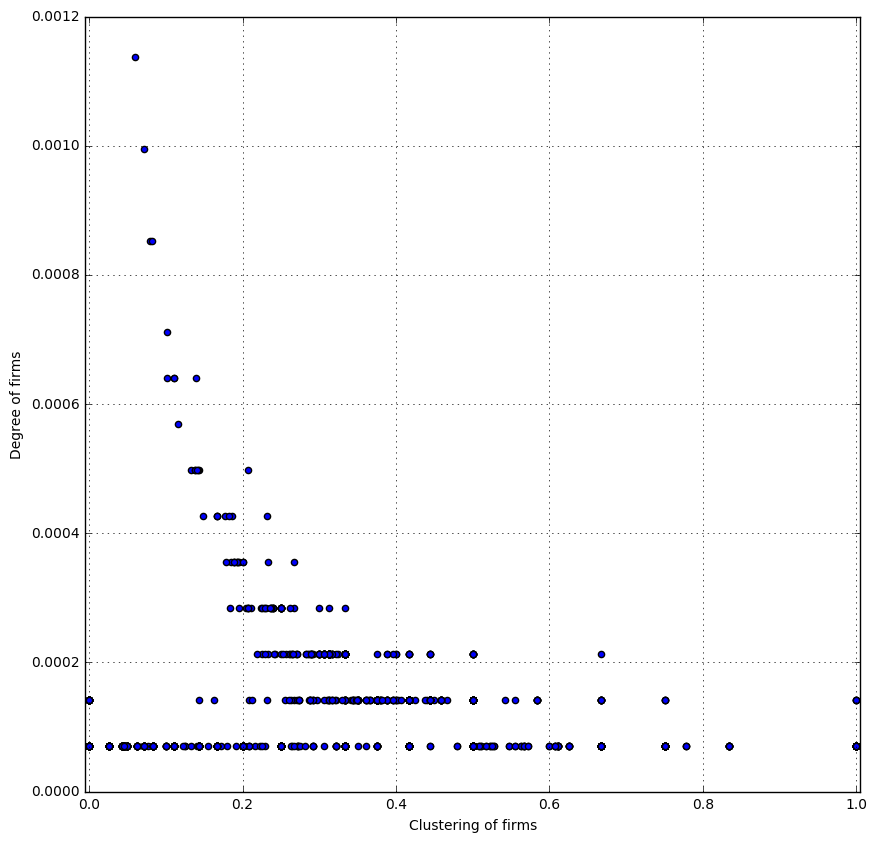

In [464]:
# Lithualina
BvD_nodes = set(n for n, d in LTG.nodes(data=True) if d['bipartite']==0)
UCI_nodes = set(LTG) - BvD_nodes

fcluLT = nx.bipartite.latapy_clustering(LTG, BvD_nodes)
icluLT = nx.bipartite.latapy_clustering(LTG, UCI_nodes)
fdegcenLT = nx.bipartite.degree_centrality(LTG, BvD_nodes)

# dict to df
df_fcluLT = pd.DataFrame(list(fcluLT.items()), columns=['firm', 'clu'])
df_icluLT = pd.DataFrame(list(icluLT.items()), columns=['ind', 'clu'])
df_degLT = pd.DataFrame(list(fdegcenLT.items()), columns=['node', 'degree'])
df_fcluLT['mode'] = 'upper'
df_icluLT['mode'] = 'lower'

df1 = pd.merge(df_degLT, df_fcluLT, left_on='node', right_on='firm', how='left')
df2 = pd.merge(df1, df_icluLT, left_on='node', right_on='ind', how='left')

# take cases where non NaN in firm = take only firms
df3 = df2.dropna(subset = ['firm'])

ax = df3.plot.scatter(x='clu_x',y='degree' , figsize=(10,10))
ax.grid(True)
plt.ylabel('Degree of firms')
plt.xlabel('Clustering of firms')
plt.xlim((-0.005, 1.005))
plt.ylim((0, 0.0012))
# plt.title('LT')

In [466]:
# df6 = df3.loc[stat['ave_clu_both'] > 0.4]
# df3.sort_values('degree', ascending=False).plot(kind='bar',x='degree', color = 'grey')

## Average board size / No of positions

In [483]:
nx.write_edgelist(USC, "USC.edgelist")
USCdf = pd.read_csv("USC.edgelist", header=None,delim_whitespace=True, low_memory=False)
USCdf.head()

0                                1   2
0  US149210472L                       P154260145  {}
1    P014167138                      US133398766  {}
2    P014167138                      US270540158  {}
3    P011367380  NA_GUO:US431257251:USFEI1017572  {}
4    P011367380                     US149128489L  {}

In [498]:
USCdf2['boardSize'].describe()

count    43673.000000
mean         2.551164
std          4.794303
min          1.000000
25%          1.000000
50%          2.000000
75%          2.000000
max        476.000000
Name: boardSize, dtype: float64

## Degree and clustering (giant component)

(0, 0.014)

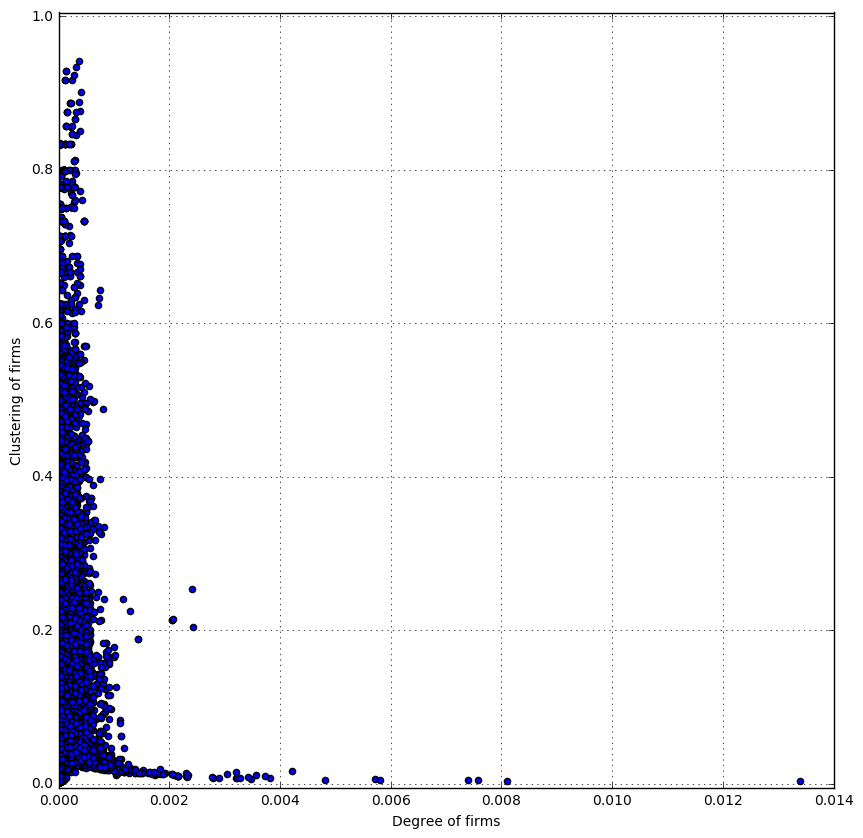

In [552]:
# US: firms
BvD_nodes = set(n for n, d in USC.nodes(data=True) if d['bipartite']==0)
UCI_nodes = set(USC) - BvD_nodes

fcluUS = nx.bipartite.latapy_clustering(USC, BvD_nodes)
icluUS = nx.bipartite.latapy_clustering(USC, UCI_nodes)
fdegcenUS = nx.bipartite.degree_centrality(USC, BvD_nodes)

# dict to df
df_fcluUS = pd.DataFrame(list(fcluUS.items()), columns=['firm', 'clu'])
df_icluUS = pd.DataFrame(list(icluUS.items()), columns=['ind', 'clu'])
df_degUS = pd.DataFrame(list(fdegcenUS.items()), columns=['node', 'degree'])
df_fcluUS['mode'] = 'upper'
df_icluUS['mode'] = 'lower'

df1 = pd.merge(df_degUS, df_fcluUS, left_on='node', right_on='firm', how='left')
df2 = pd.merge(df1, df_icluUS, left_on='node', right_on='ind', how='left')

# take cases where non NaN in firm = take only firms
df3 = df2.dropna(subset = ['firm'])

ax = df3.plot.scatter(y='clu_x',x='degree' , figsize=(10,10))
ax.grid(True)
plt.xlabel('Degree of firms')
plt.ylabel('Clustering of firms')
plt.ylim((-0.005, 1.005))
plt.xlim((0, 0.014))

(0, 0.004)

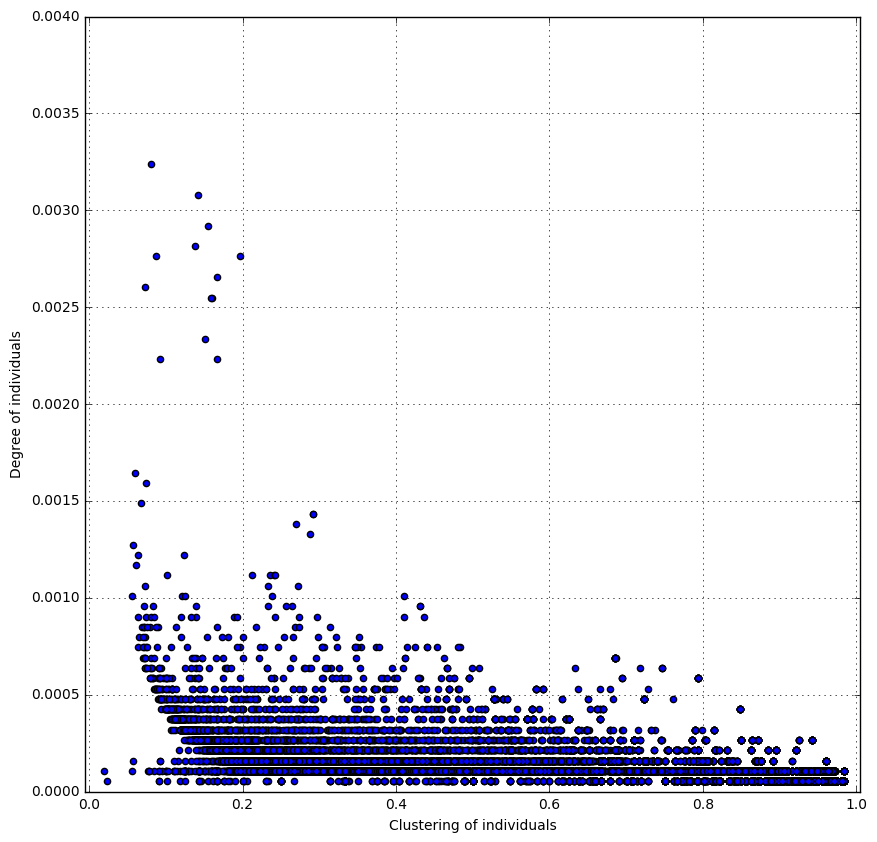

In [543]:
# US ind
BvD_nodes = set(n for n, d in USC.nodes(data=True) if d['bipartite']==0)
UCI_nodes = set(USC) - BvD_nodes

fcluUS = nx.bipartite.latapy_clustering(USC, BvD_nodes)
icluUS = nx.bipartite.latapy_clustering(USC, UCI_nodes)
fdegcenUS = nx.bipartite.degree_centrality(USC, BvD_nodes)

# dict to df
df_fcluUS = pd.DataFrame(list(fcluUS.items()), columns=['firm', 'clu'])
df_icluUS = pd.DataFrame(list(icluUS.items()), columns=['ind', 'clu'])
df_degUS = pd.DataFrame(list(fdegcenUS.items()), columns=['node', 'degree'])
df_fcluUS['mode'] = 'upper'
df_icluUS['mode'] = 'lower'

df1 = pd.merge(df_degUS, df_fcluUS, left_on='node', right_on='firm', how='left')
df2 = pd.merge(df1, df_icluUS, left_on='node', right_on='ind', how='left')

# take cases where non NaN in firm = take only inds
df3 = df2.dropna(subset = ['ind'])

ax = df3.plot.scatter(x='clu_y',y='degree' , figsize=(10,10))
ax.grid(True)
plt.ylabel('Degree of individuals')
plt.xlabel('Clustering of individuals')
plt.xlim((-0.005, 1.005))
plt.ylim((0, 0.004))



(0, 0.025)

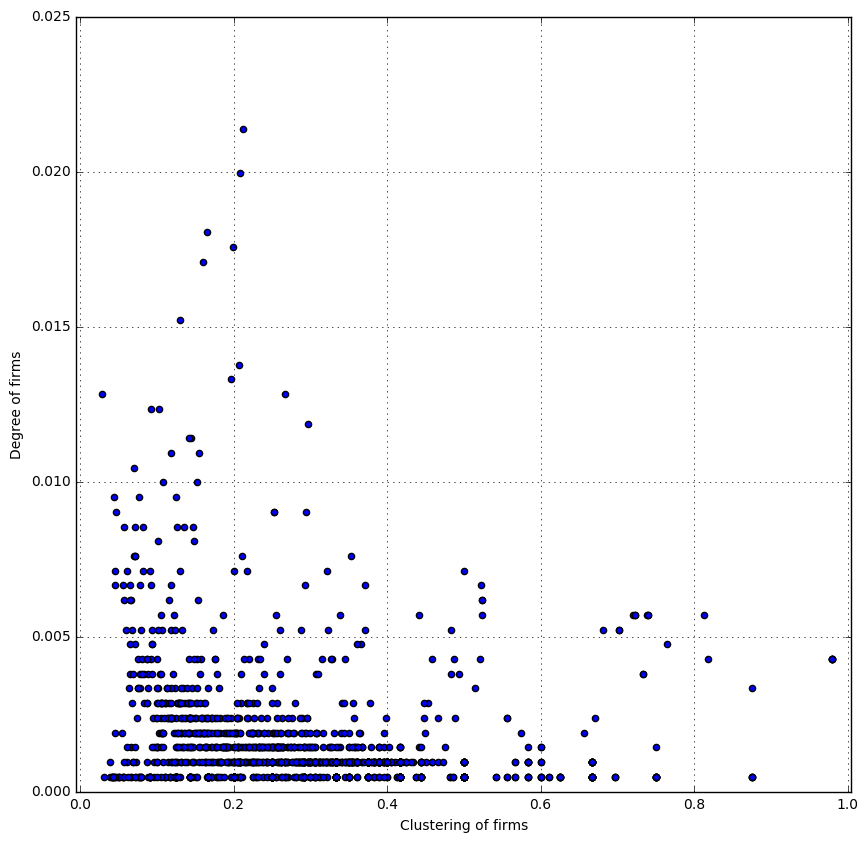

In [527]:
# Cananda: firms
BvD_nodes = set(n for n, d in CAC.nodes(data=True) if d['bipartite']==0)
UCI_nodes = set(CAC) - BvD_nodes

fcluCA = nx.bipartite.latapy_clustering(CAC, BvD_nodes)
icluCA = nx.bipartite.latapy_clustering(CAC, UCI_nodes)
fdegcenCA = nx.bipartite.degree_centrality(CAC, BvD_nodes)

# dict to df
df_fcluCA = pd.DataFrame(list(fcluCA.items()), columns=['firm', 'clu'])
df_icluCA = pd.DataFrame(list(icluCA.items()), columns=['ind', 'clu'])
df_degCA = pd.DataFrame(list(fdegcenCA.items()), columns=['node', 'degree'])
df_fcluCA['mode'] = 'upper'
df_icluCA['mode'] = 'lower'

df1 = pd.merge(df_degCA, df_fcluCA, left_on='node', right_on='firm', how='left')
df2 = pd.merge(df1, df_icluCA, left_on='node', right_on='ind', how='left')

# take cases where non NaN in firm = take only firms
df3 = df2.dropna(subset = ['firm'])

ax = df3.plot.scatter(x='clu_x',y='degree' , figsize=(10,10))
ax.grid(True)
plt.ylabel('Degree of firms')
plt.xlabel('Clustering of firms')
plt.xlim((-0.005, 1.005))
plt.ylim((0, 0.025))
# plt.title('CA')

(0, 0.007)

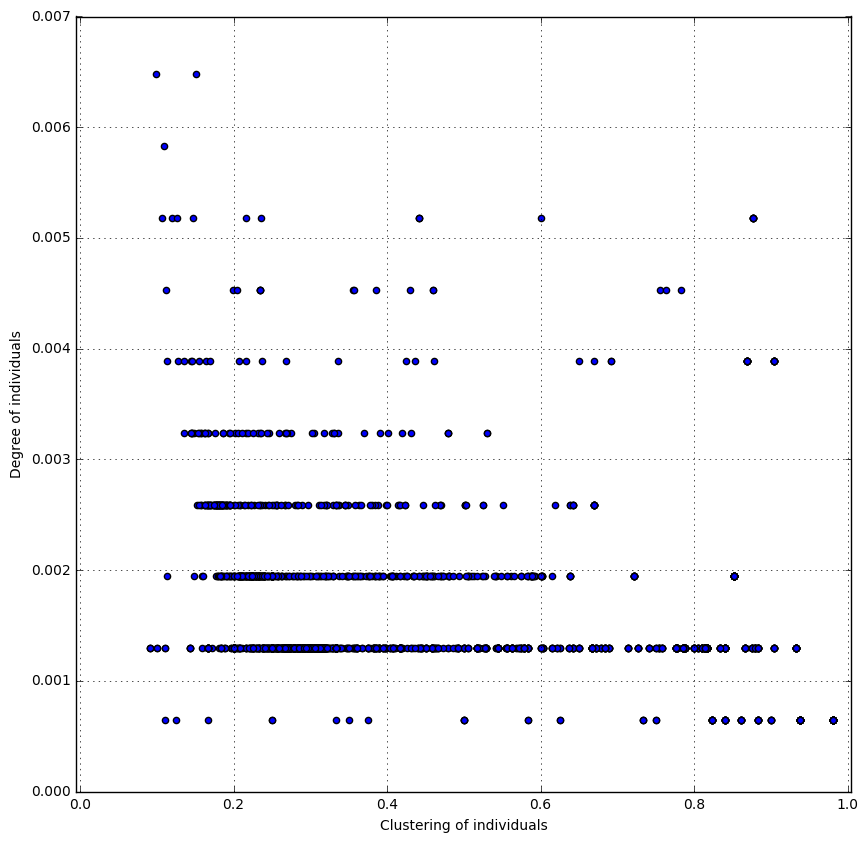

In [546]:
# Canada inds
BvD_nodes = set(n for n, d in CAC.nodes(data=True) if d['bipartite']==0)
UCI_nodes = set(CAC) - BvD_nodes

fcluCA = nx.bipartite.latapy_clustering(CAC, BvD_nodes)
icluCA = nx.bipartite.latapy_clustering(CAC, UCI_nodes)
fdegcenCA = nx.bipartite.degree_centrality(CAC, BvD_nodes)

# dict to df
df_fcluCA = pd.DataFrame(list(fcluCA.items()), columns=['firm', 'clu'])
df_icluCA = pd.DataFrame(list(icluCA.items()), columns=['ind', 'clu'])
df_degCA = pd.DataFrame(list(fdegcenCA.items()), columns=['node', 'degree'])
df_fcluCA['mode'] = 'upper'
df_icluCA['mode'] = 'lower'

df1 = pd.merge(df_degCA, df_fcluCA, left_on='node', right_on='firm', how='left')
df2 = pd.merge(df1, df_icluCA, left_on='node', right_on='ind', how='left')

# take cases where non NaN in firm = take only inds
df3 = df2.dropna(subset = ['ind'])

ax = df3.plot.scatter(x='clu_y',y='degree' , figsize=(10,10))
ax.grid(True)
plt.ylabel('Degree of individuals')
plt.xlabel('Clustering of individuals')
plt.xlim((-0.005, 1.005))
plt.ylim((0, 0.007))

(0, 0.01)

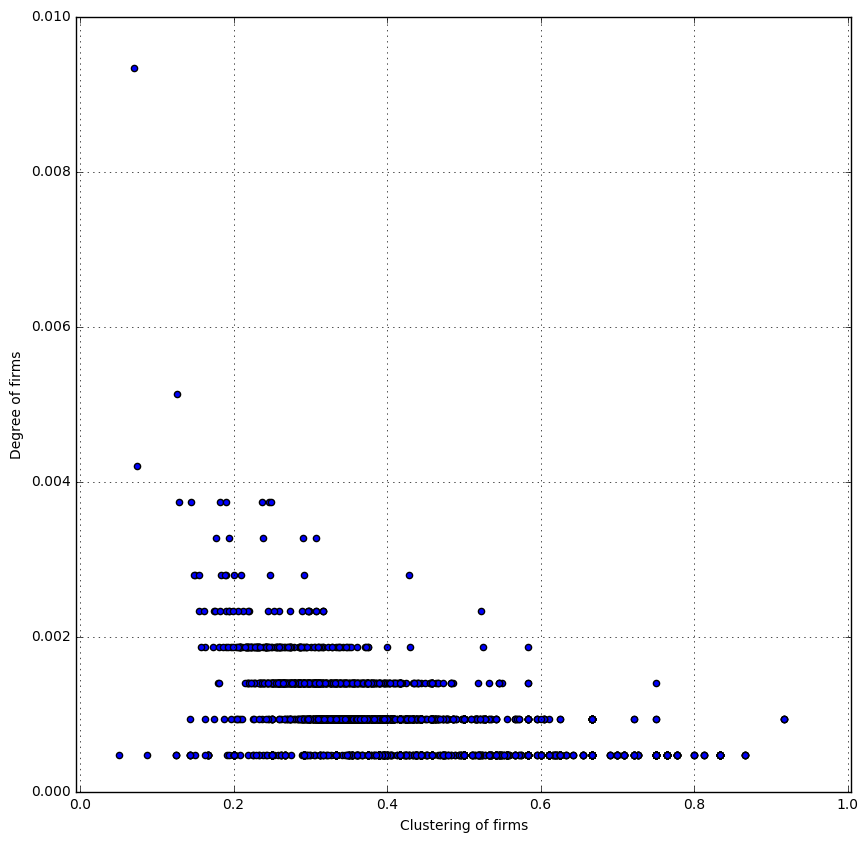

In [539]:
# Slovakia: firms
BvD_nodes = set(n for n, d in SKC.nodes(data=True) if d['bipartite']==0)
UCI_nodes = set(SKC) - BvD_nodes

fcluSK = nx.bipartite.latapy_clustering(SKC, BvD_nodes)
icluSK = nx.bipartite.latapy_clustering(SKC, UCI_nodes)
fdegcenSK = nx.bipartite.degree_centrality(SKC, BvD_nodes)

# dict to df
df_fcluSK = pd.DataFrame(list(fcluSK.items()), columns=['firm', 'clu'])
df_icluSK = pd.DataFrame(list(icluSK.items()), columns=['ind', 'clu'])
df_degSK = pd.DataFrame(list(fdegcenSK.items()), columns=['node', 'degree'])
df_fcluSK['mode'] = 'upper'
df_icluSK['mode'] = 'lower'

df1 = pd.merge(df_degSK, df_fcluSK, left_on='node', right_on='firm', how='left')
df2 = pd.merge(df1, df_icluSK, left_on='node', right_on='ind', how='left')

# take cases where non NaN in firm = take only firms
df3 = df2.dropna(subset = ['firm'])

ax = df3.plot.scatter(x='clu_x',y='degree' , figsize=(10,10))
ax.grid(True)
plt.ylabel('Degree of firms')
plt.xlabel('Clustering of firms')
plt.xlim((-0.005, 1.005))
plt.ylim((0, 0.01))

(0, 0.012)

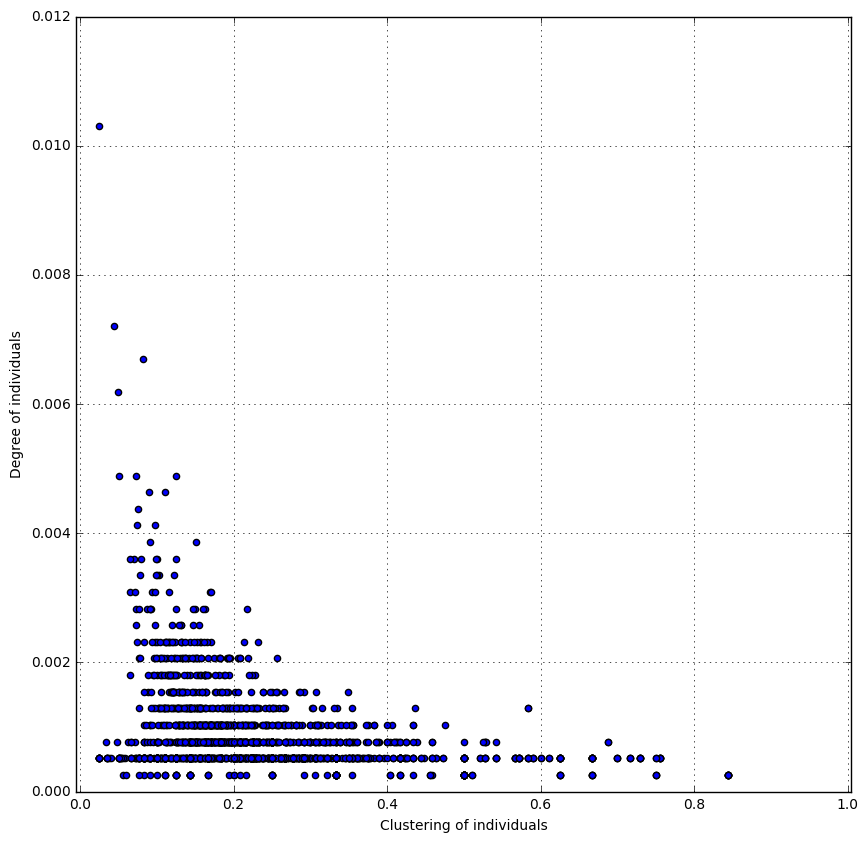

In [548]:
# Slovakia : ind
BvD_nodes = set(n for n, d in SKC.nodes(data=True) if d['bipartite']==0)
UCI_nodes = set(SKC) - BvD_nodes

fcluSK = nx.bipartite.latapy_clustering(SKC, BvD_nodes)
icluSK = nx.bipartite.latapy_clustering(SKC, UCI_nodes)
fdegcenSK = nx.bipartite.degree_centrality(SKC, BvD_nodes)

# dict to df
df_fcluSK = pd.DataFrame(list(fcluSK.items()), columns=['firm', 'clu'])
df_icluSK = pd.DataFrame(list(icluSK.items()), columns=['ind', 'clu'])
df_degSK = pd.DataFrame(list(fdegcenSK.items()), columns=['node', 'degree'])
df_fcluSK['mode'] = 'upper'
df_icluSK['mode'] = 'lower'

df1 = pd.merge(df_degSK, df_fcluSK, left_on='node', right_on='firm', how='left')
df2 = pd.merge(df1, df_icluSK, left_on='node', right_on='ind', how='left')

# take cases where non NaN in firm = take only inds
df3 = df2.dropna(subset = ['ind'])

ax = df3.plot.scatter(x='clu_y',y='degree' , figsize=(10,10))
ax.grid(True)
plt.ylabel('Degree of individuals')
plt.xlabel('Clustering of individuals')
plt.xlim((-0.005, 1.005))
plt.ylim((0, 0.012))

(0, 0.005)

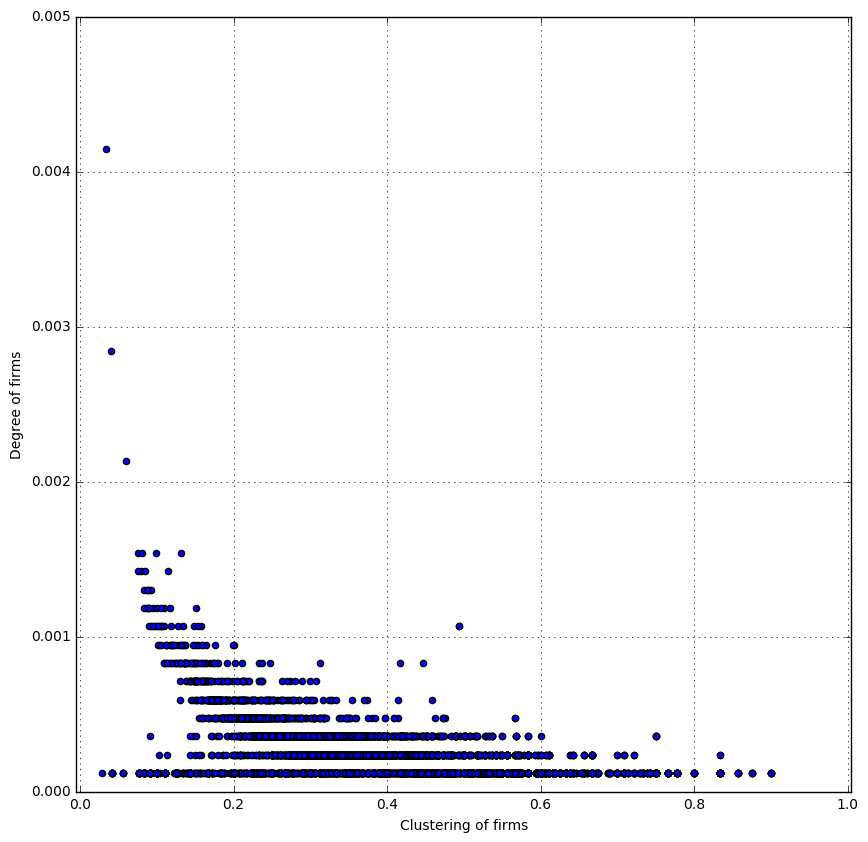

In [541]:
# Bulgaria firms
BvD_nodes = set(n for n, d in BGC.nodes(data=True) if d['bipartite']==0)
UCI_nodes = set(BGC) - BvD_nodes

fcluBG = nx.bipartite.latapy_clustering(BGC, BvD_nodes)
icluBG = nx.bipartite.latapy_clustering(BGC, UCI_nodes)
fdegcenBG = nx.bipartite.degree_centrality(BGC, BvD_nodes)

# dict to df
df_fcluBG = pd.DataFrame(list(fcluBG.items()), columns=['firm', 'clu'])
df_icluBG = pd.DataFrame(list(icluBG.items()), columns=['ind', 'clu'])
df_degBG = pd.DataFrame(list(fdegcenBG.items()), columns=['node', 'degree'])
df_fcluBG['mode'] = 'upper'
df_icluBG['mode'] = 'lower'

df1 = pd.merge(df_degBG, df_fcluBG, left_on='node', right_on='firm', how='left')
df2 = pd.merge(df1, df_icluBG, left_on='node', right_on='ind', how='left')

# take cases where non NaN in firm = take only firms
df3 = df2.dropna(subset = ['firm'])

ax = df3.plot.scatter(x='clu_x',y='degree' , figsize=(10,10))
ax.grid(True)
plt.ylabel('Degree of firms')
plt.xlabel('Clustering of firms')
plt.xlim((-0.005, 1.005))
plt.ylim((0, 0.005))

(0, 0.0017)

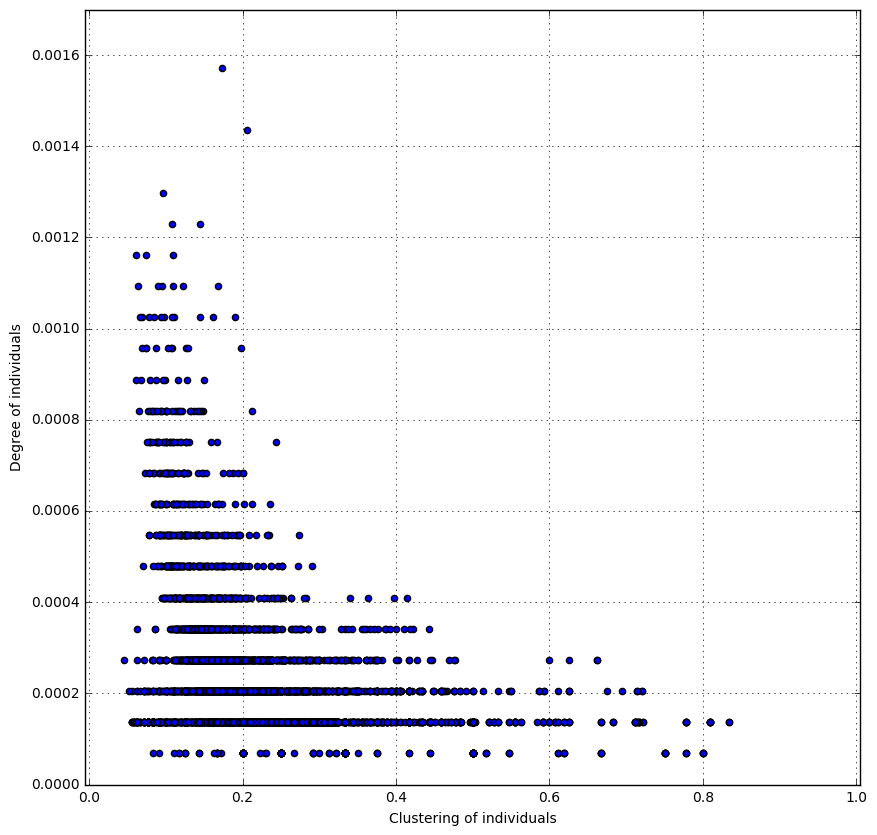

In [551]:
# Bulgaria inds
BvD_nodes = set(n for n, d in BGC.nodes(data=True) if d['bipartite']==0)
UCI_nodes = set(BGC) - BvD_nodes

fcluBG = nx.bipartite.latapy_clustering(BGC, BvD_nodes)
icluBG = nx.bipartite.latapy_clustering(BGC, UCI_nodes)
fdegcenBG = nx.bipartite.degree_centrality(BGC, BvD_nodes)

# dict to df
df_fcluBG = pd.DataFrame(list(fcluBG.items()), columns=['firm', 'clu'])
df_icluBG = pd.DataFrame(list(icluBG.items()), columns=['ind', 'clu'])
df_degBG = pd.DataFrame(list(fdegcenBG.items()), columns=['node', 'degree'])
df_fcluBG['mode'] = 'upper'
df_icluBG['mode'] = 'lower'

df1 = pd.merge(df_degBG, df_fcluBG, left_on='node', right_on='firm', how='left')
df2 = pd.merge(df1, df_icluBG, left_on='node', right_on='ind', how='left')

# take cases where non NaN in firm = take only inds
df3 = df2.dropna(subset = ['ind'])

ax = df3.plot.scatter(x='clu_y',y='degree' , figsize=(10,10))
ax.grid(True)
plt.ylabel('Degree of individuals')
plt.xlabel('Clustering of individuals')
plt.xlim((-0.005, 1.005))
plt.ylim((0, 0.0017))

## Degree distribution

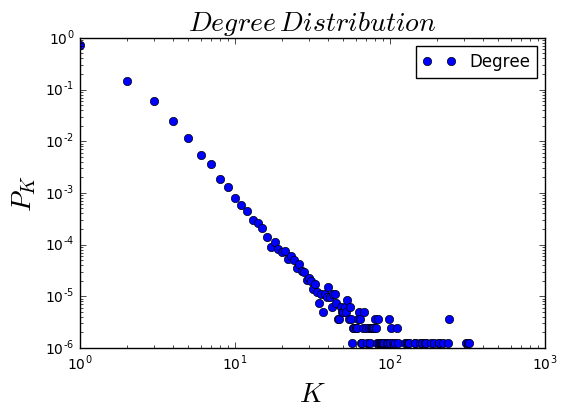

In [196]:
def plotDegreeDistribution(G):
    from collections import defaultdict
    import numpy as np
    import matplotlib.pyplot as plt
    %matplotlib inline
    degs = defaultdict(int)
    for i in G.degree().values(): degs[i]+=1
    items = sorted ( degs.items () )
    x, y = np.array(items).T
    y = [float(i) / sum(y) for i in y]
    plt.plot(x, y, 'bo')
    plt.xscale('log')
    plt.yscale('log')
    plt.legend(['Degree'])
    plt.xlabel('$K$', fontsize = 20)
    plt.ylabel('$P_K$', fontsize = 20)
    plt.title('$Degree\,Distribution$', fontsize = 20)
    plt.show()

# P(k) - degree distribution, K - degree
# see http://www.sciencedirect.com/science/article/pii/S0378437111005206

plotDegreeDistribution(seG)

In [ ]:
# Other network properties to explore:
dk_diam = nx.algorithms.distance_measures.diameter(giant1)
cycle_basis(dkG)
spectral_bipartivity(G[, nodes, weight])
node_redundancy(G[, nodes])
cycles: https://networkx.github.io/documentation/networkx-1.10/reference/algorithms.cycles.html
        
# Expensive to compute: average distance, ave shortest path, diameter